# Data preprocesssing

Import necessary packages and read in data

In [1]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
try:
    import shap
except ImportError:
  install("shap")
try:
    import numpy as np
except ImportError:
    install("numpy")

try:
    import pandas as pd
except ImportError:
    install("pandas")

try:
    from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
    from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from sklearn.linear_model import LinearRegression, Ridge, Lasso
except ImportError:
    install("scikit-learn")

try:
    from xgboost import XGBRegressor
    import xgboost as xgb
except ImportError:
    install("xgboost")

try:
    import matplotlib.pyplot as plt
except ImportError:
    install("matplotlib")

try:
    import seaborn as sns
except ImportError:
    install("seaborn")

try:
    from scipy.stats import randint, uniform
except ImportError:
    install("scipy")

try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
except ImportError:
    install("statsmodels")
try:
    import nltk
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
except ImportError:
    install("nltk")

try:
    import pickle
except ImportError:
    install("pickle-mixin")

print("All packages are installed and ready to use.")
from collections import defaultdict
from datetime import datetime, date
from itertools import chain
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Read in data
df = pd.read_excel('/content/Classes.xlsx', header=1)
# Make a copy of the DataFrame
df_copy = df.copy()

All packages are installed and ready to use.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Save a copy of original dataframe so you don't have to spend time waiting for dataset to load in from xlxx.

In [2]:
df = df_copy

Observe head of dataframe. As there can be seen, this dataset is almost entirely categorical (apart from total enrollment and classroom capacity).

In [3]:
df.head()

,Term Code,Term,Subject,Catalog,Descr,Section,Class Nbr,Component,Class Type,Enrollment Capacity,...,Instructor,Start Time,End Time,Mon,Tues,Wed,Thurs,Fri,Sat,Sun
0,4560,2014 Fall,MUS_THRY,316-0,Renaissance Counterpoint,20,16442,LEC,Enrollment Section,20,...,"Gjerdingen,Robert O",09:30:00,10:50:00,N,Y,N,Y,N,N,N
1,4560,2014 Fall,POLI_SCI,499-0,Independent Study,77,18063,IND,Enrollment Section,10,...,"Stevens,Jacqueline",12:00:00,12:00:00,N,N,N,N,N,N,N
2,4560,2014 Fall,POLI_SCI,499-0,Independent Study,78,18064,IND,Enrollment Section,10,...,"Tillery,Alvin Bernard",12:00:00,12:00:00,N,N,N,N,N,N,N
3,4560,2014 Fall,THEATRE,448-0,Studies in Am Theatre & Drama,20,19022,LEC,Enrollment Section,15,...,"Young Jr,Harvey",14:00:00,16:50:00,N,N,Y,N,N,N,N
4,4560,2014 Fall,ENGLISH,206-0,Read/Wrt Poetry,24,19125,SEM,Enrollment Section,15,...,"Kinzie,Mary",11:00:00,12:20:00,N,Y,N,Y,N,N,N


Observe shape of dataframe

In [4]:
df.shape

(224451, 25)

With such a massive dataset, its important to ensure data integrity and handle potentially erroneous data. First, lets see the courses of which there was 0 enrollment capacity or total enrollment. While its possible that a course doesn't have any students, this could be an error (for example IEMS 315 in Fall 2022 should not have 0 total enrollment).

In [5]:
# Count the number of instances where 'Total Enrollment' is 0
total_enrollment_zero_count = df[df['Total Enrollment'] == 0].shape[0]

# Count the number of instances where 'Enrollment Capacity' is 0
enrollment_capacity_zero_count = df[df['Enrollment Capacity'] == 0].shape[0]

# Print the number of instances for 'Total Enrollment' being 0
print(f"Number of instances with 'Total Enrollment' being 0: {total_enrollment_zero_count}")

# Print the number of instances for 'Enrollment Capacity' being 0
print(f"Number of instances with 'Enrollment Capacity' being 0: {enrollment_capacity_zero_count}")

# Check the rows to see which courses have no enrollment capacity or total enrollment
if total_enrollment_zero_count > 0:
    print("\nRows where 'Total Enrollment' is 0:")
    print(df[df['Total Enrollment'] == 0])

if enrollment_capacity_zero_count > 0:
    print("\nRows where 'Enrollment Capacity' is 0:")
    print(df[df['Enrollment Capacity'] == 0])

Number of instances with 'Total Enrollment' being 0: 97354
Number of instances with 'Enrollment Capacity' being 0: 4201

Rows where 'Total Enrollment' is 0:
        Term Code         Term   Subject Catalog                   Descr  \
1            4560    2014 Fall  POLI_SCI   499-0       Independent Study   
2            4560    2014 Fall  POLI_SCI   499-0       Independent Study   
5            4570  2015 Winter  WIND_PER   305-0        Optional Recital   
6            4570  2015 Winter  WIND_PER   305-0        Optional Recital   
7            4570  2015 Winter  WIND_PER   305-0        Optional Recital   
...           ...          ...       ...     ...                     ...   
224413       4910  2023 Summer    ASTRON   499-0       Independent Study   
224415       4910  2023 Summer    ASTRON   590-0                Research   
224420       4910  2023 Summer    ASTRON   590-0                Research   
224422       4910  2023 Summer       MHB   410-1  Special Topics in MH&B   
224425 

For the sake of consisteny, we want to minimize noise from potential errors or highly unusual scenarios. An enrollment capacity of 0 should not be trained on, as there is an expectation that department heads are not planning on forecasting course enrollment for a course that they do not plan to offer any capacity for. Likewise, we will remove total enrollment of 0 because this noise is not reflective of most courses or is an error, and we don't want our model to overfit/perform poorly because of it.

### Preprocess data block

In [6]:
print(f"Shape initially: {df.shape}\n")

# Filter for specific subjects and McCormick Engineering and Applied Sciences
df = df[(df['Course Owner'] == 'MEAS')].copy()
print(f"Shape after filtering for McCormick: {df.shape}\n")

# Include only lectures, seminars, discussions, and labs
df = df[(df['Component'].isin(['LEC', 'SEM', 'DIS', 'LAB']))].copy()
print(f"Shape after filtering for lectures, seminars, discussion, and labs: {df.shape}\n")

# Remove specific project or independent study descriptions
df = df[~df['Descr'].isin(['Projects', 'Research', 'Spec Topics', 'Independent Study', 'Independent Reading', 'Teaching Experience', 'Honors Project']) & ~df['Descr'].str.contains('Special Topics|Special Projects|Special Topic|Special Project', case=False, na=False)].copy()
print(f"Shape after filtering to exclude specific project or independent study descriptions: {df.shape}\n")

# Exclude courses with no capacity or highly unusual capacity (999 capacity)
df = df[~df['Enrollment Capacity'].isin([0, 999])].copy()
print(f"Shape after filtering out 0 and 999 courses: {df.shape}\n")

# Combine 'Subject' and 'Catalog' into 'Subject-Catalog' and remove specific CS classes
df.loc[:, 'Subject-Catalog'] = df['Subject'].str.strip() + '_' + df['Catalog'].str.strip()
df = df[~df['Subject-Catalog'].isin(["COMP_SCI_396-0", "COMP_SCI_397-0", "COMP_SCI_496-0", "COMP_SCI_497-0"])].copy()
print(f"Shape after removing CS 396 and 397 classes (Special Topics and Projects in CS): {df.shape}\n")

# Remove any courses with only a single occurrence (noise in data)
course_key_occurances = defaultdict(int)
for course_key in df['Subject-Catalog']:
    course_key_occurances[course_key] += 1

keys_with_value_one = [key for key, value in course_key_occurances.items() if value == 1]
df = df[~df['Subject-Catalog'].isin(keys_with_value_one)].copy()
unique_course_keys = set(df['Subject-Catalog'].unique())
print(f"Shape after removing courses offered once only: {df.shape}\n")

# Exclude courses offered during COVID times
df = df[~df['Term'].isin(['2020 Spring', '2020 Summer', '2020 Fall', '2020 Winter', '2021 Spring'])].copy()
print(f"Shape after removing COVID years: {df.shape}\n")

# Convert 'Start Time' and 'End Time' to datetime objects and then to time
df['Start Time'] = pd.to_datetime(df['Start Time'], format='%H:%M:%S', errors='coerce').dt.time
df['End Time'] = pd.to_datetime(df['End Time'], format='%H:%M:%S', errors='coerce').dt.time

# Drop rows where either 'Start Time' or 'End Time' is NaT after conversion
df = df.dropna(subset=['Start Time', 'End Time']).copy()
print(f"Shape after dropping rows with NaT times: {df.shape}\n")

# Calculate duration in minutes and create a new 'Duration' column
df['Duration'] = df.apply(
    lambda row: (datetime.combine(date.min, row['End Time']) - datetime.combine(date.min, row['Start Time'])).seconds / 60,
    axis=1
)

# Filter out classes between 7 PM and 6 AM using the hour attribute
df = df[~df['Start Time'].apply(lambda x: x.hour).isin(list(chain(range(19, 24), range(0, 7))))].copy()
print(f"Shape after removing classes from 7 PM to 6 AM: {df.shape}\n")

df = df[df['Enrollment Capacity'] > 0]  # Keeps only rows where enrollment is greater than zero
print(f"Shape after removing classes with 0 enrollment capacity: {df.shape}\n")

df = df[df['Total Enrollment'] > 5]  # Keeps only rows where Total Enrollment is greater than 5 to handle data qualitity issues and unuusal circumstances.
print(f"Shape after removing classes with less than 5 students in Total Enrollment: {df.shape}\n")

# Step 1: Calculate the frequency of each duration
duration_counts = df['Duration'].value_counts()

# Identify durations that occur more than 100 times
frequent_durations = duration_counts[duration_counts > 100].index

# Step 2: Filter the DataFrame to only include rows with these durations
df= df[df['Duration'].isin(frequent_durations)]
print(f"Shape after removing classes dropping courses without duration frequncies of at least 100: {df.shape}\n")

# Define the testing set (most recent year of courses)
test_terms = ['2023 Spring','2023 Summer', '2023 Fall', '2023 Winter']

# Save indices of the rows for these terms
term_indices = df[df['Term'].isin(test_terms)].index

# Make a copy of the 'Term' column for year extraction to avoid interference
df['Original_Term'] = df['Term']

# Extract the season name from 'Term'
df.loc[:, 'Term'] = df['Original_Term'].str.extract('\d{4}\s+([a-zA-Z]+)', expand=False)

# Extract the year from the original 'Term' data
df.loc[:, 'Year'] = df['Original_Term'].str.extract('(\d{4})', expand=False)

# After extraction, you can optionally drop the 'Original_Term' if it's no longer needed
df.drop('Original_Term', axis=1, inplace=True)
print(f"Shape after seperating term and year from the same column: {df.shape}\n")

# Drop columns no longer needed
df.drop(['Start Date', 'End Time', 'End Date', 'Course Career','Class Type', 'Course Owner','Catalog', 'Class Nbr', 'Section', 'Term Code'], axis=1, inplace=True)
# Assuming df['Start Time'] contains datetime.time objects
df['Start Time'] = df['Start Time'].apply(lambda x: x.strftime('%H:%M:%S'))

# Convert all object type columns to categorical
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype('category')

def minutes_to_hours(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    hour_str = "hour" if hours == 1 else "hours"
    minute_str = "minute" if mins == 1 else "minutes"

    if hours == 0 and mins == 0:
        return "0 minutes"
    elif hours == 0:
        return f"{mins} {minute_str}"
    elif mins == 0:
        return f"{hours} {hour_str}"
    else:
        return f"{hours} {hour_str} {mins} {minute_str}"

# Applying the function to the DataFrame
df['Duration'] = df['Duration'].apply(minutes_to_hours)

    # Convert to categorical
df['Duration'] = df['Duration'].astype('category')
print(f"Shape after finishing row and column preprocessing: {df.shape}\n")

Shape initially: (224451, 25)

Shape after filtering for McCormick: (45618, 25)

Shape after filtering for lectures, seminars, discussion, and labs: (19542, 25)

Shape after filtering to exclude specific project or independent study descriptions: (13066, 25)

Shape after filtering out 0 and 999 courses: (12765, 25)

Shape after removing CS 396 and 397 classes (Special Topics and Projects in CS): (12765, 26)

Shape after removing courses offered once only: (12628, 26)

Shape after removing COVID years: (10766, 26)

Shape after dropping rows with NaT times: (10407, 26)

Shape after removing classes from 7 PM to 6 AM: (9991, 27)

Shape after removing classes with 0 enrollment capacity: (9991, 27)

Shape after removing classes with less than 5 students in Total Enrollment: (9183, 27)

Shape after removing classes dropping courses without duration frequncies of at least 100: (8971, 27)

Shape after seperating term and year from the same column: (8971, 28)

Shape after finishing row and colu

Here are the final columns left in the dataset. Note that not all of them will be used as inputs for our model (Desc, Year, Enrollment Capacity, Total Enrollment)

In [7]:
df.columns

Index(['Term', 'Subject', 'Descr', 'Component', 'Enrollment Capacity',
       'Total Enrollment', 'Instructor', 'Start Time', 'Mon', 'Tues', 'Wed',
       'Thurs', 'Fri', 'Sat', 'Sun', 'Subject-Catalog', 'Duration', 'Year'],
      dtype='object')

In [8]:
print(f"The datatypes are: {df.dtypes}\n")

The datatypes are: Term                   category
Subject                category
Descr                  category
Component              category
Enrollment Capacity       int64
Total Enrollment          int64
Instructor             category
Start Time             category
Mon                    category
Tues                   category
Wed                    category
Thurs                  category
Fri                    category
Sat                    category
Sun                    category
Subject-Catalog        category
Duration               category
Year                   category
dtype: object



Now, began preprocessing for LSA

In [9]:
# Initialize DataFrame and preprocess descriptions
df_new = df.copy()
df_new['Descr'] = df_new['Descr'].str.lower()

# Replace slashes and hyphens in 'Descr' with spaces
df_new['Descr'] = df_new['Descr'].str.replace(r'[/-]', ' ', regex=True)

# Tokenize descriptions
df_new['tokens'] = df_new['Descr'].apply(word_tokenize)

# Lemmatization setup
lemmatizer = WordNetLemmatizer()
df_new['tokens'] = df_new['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])

# Apply custom term standardizations
custom_replacements = {
    'engg': 'engineering',
    'eng': 'engineering',
    'engineer': 'engineering',
    'engineerng':'engineering',
    'sci': 'science',
    'chem': 'chemistry',
    'biochem': 'biochemistry',
    'biol': 'biology',
    'econ': 'economics',
    'psy': 'psychology',
    'psych': 'psychology',
    'calc': 'calculus',
    'maths': 'mathematics',
    'math': 'mathematics',
    'phys': 'physics',
    'info': 'information',
    'comp': 'computer',
    'cs': 'computerscience',
    'ee': 'electricalengineering',
    'me': 'mechanicalengineering',
    'ce': 'civilengineering',
    'env': 'environmental',
    'stat': 'statistics',
    'stats': 'statistics',
    'biostat': 'biostatistics',
    'neuro': 'neuroscience',
    'phil': 'philosophy',
    'aero': 'aeronautical',
    'aerospace': 'aeronautical',
    'fin': 'finance',
    'acct': 'accounting',
    'mktg': 'marketing',
    'adm': 'administration',
    'admin': 'administration',
    'mgmt': 'management',
    'manag': 'management',
    'int': 'international',
    'dev': 'development',
    'soc': 'sociology',
    'socy': 'sociology',
    'anthro': 'anthropology',
    'geo': 'geography',
    'geog': 'geography',
    'hist': 'history',
    'liter': 'literature',
    'edu': 'education',
    'englit': 'englishliterature',
    'engl': 'english',
    'ling': 'linguistics',
    'cog': 'cognitive',
    'cogn': 'cognitive',
    'behav': 'behavioral',
    'beh': 'behavioral',
    'pol': 'political',
    'poli': 'political',
    'pls': 'political science',
    'sys': 'systems',
    'biotech': 'biotechnology',
    'tech': 'technology',
    'thermo': 'thermodynamic',
    'quant': 'quantitative',
    'clin': 'clinical',
    'diag': 'diagnostics',
    'diagno': 'diagnostics',
    'med': 'medical',
    'medic': 'medical',
    'pharma': 'pharmacology',
    'pharm': 'pharmacology',
    'viro': 'virology',
    'immuno': 'immunology',
    'patho': 'pathology',
    'epi': 'epidemiology',
    'epidemio': 'epidemiology',
    'nano': 'nanotechnology',
    'org': 'organic',
    'inorg': 'inorganic',
    'metab': 'metabolism',
    'metabo': 'metabolism',
    'gen': 'genetics',
    'genet': 'genetics',
    'cancer': 'oncology',
    'onco': 'oncology',
    'cardio': 'cardiology',
    'neurosci': 'neuroscience',
    'ophth': 'ophthalmology',
    'opthal': 'ophthalmology',
    'derm': 'dermatology',
    'derma': 'dermatology',
    'gastro': 'gastroenterology',
    'ortho': 'orthopedics',
    'orthop': 'orthopedics',
    'ped': 'pediatrics',
    'peds': 'pediatrics',
    'psycho': 'psychology',
    'psychia': 'psychiatry',
    'psychiat': 'psychiatry',
    'anat': 'anatomy',
    'anato': 'anatomy',
    'molec': 'molecular',
    'mach': 'machine',
    'learn': 'learning',
    'algo': 'algorithm',
    'algos': 'algorithm',
    'net': 'network',
    'nets': 'networks',
    'oper': 'operations',
    'stud': 'studies',
    'equil': 'equilibrium',
    'adv': 'advanced',
    'intro': 'introduction',
    'mech': 'mechanical',
    'topic': 'topics',
    'computer': 'computing',
    'fluid': 'fluids',
    'mechanic': 'mechanics',
    'physics': 'physical',
    'mat': 'materials',
    'manuf': 'manufacturing',
    'seminars': 'seminar',
    'selected': 'selection',
    'sem': 'seminar',
    'rcr': 'ResponsibleCondunctResearch',
    'training': 'train',
    'proc': 'process',
    'principle': 'principles',
    'statistic': 'statistics',
    'statistical': 'statistics',
    'model': 'modeling',
    'fundamental': 'fundamentals',
    'advanced': 'advance',
    'sim': 'simulation',
    'dynamic': 'dynamics',
    'probability': 'probabilities',
    'envr': 'environmental',
    'civil': 'civil',
    'quantitative': 'quantify',
    'senior': 'senior',
    'mathematics': 'mathematical',
    'intg': 'integration',
    'foundation': 'foundational',
    'learning': 'learn',
    'data': 'data',
    'opt': 'optimization',
    'spec': 'special',
    'struct': 'structure',
    'biomedical': 'biomedicine',
    'management': 'manage',
    'meth': 'method',
    'transport': 'transportation',
    'lab': 'laboratory',
    'biomed': 'biomedicine',
    'technology': 'technological',
    'solid': 'solids',
    'entrepreneurship': 'entrepreneurial',
    'computational': 'compute',
    'biomechanics': 'biomechanical',
    'mod': 'model',
    'mechan': 'mechanics',
    'eq': 'equation',
    'composite': 'composites',
    'development': 'develop',
    'environ': 'environmental',
    'theory': 'theoretical',
    'phase': 'phases',
    'analytics': 'analytical',
    'syst': 'systems',
    'finance': 'financial',
    'scheduling': 'schedule',
    'circuit': 'circuits',
    'hon': 'honor',
    'experimentl': 'experimental',
    'capstone': 'capstone',
    'programming': 'program',
    'biotechnology': 'biotechnological',
    'heat': 'heating',
    'projectmanagement': 'projectmanagement',
    'social': 'society',
    'prog': 'program',
    'mechatronics': 'mechatronic',
    'algorithm': 'algorithmic',
    'datascience': 'datascience',
    'electronics': 'electronic',
    'ie': 'industrialengineering',
    'analy':'analysis',
    'stoch': 'stochastic',
    'thermodyn':'thermodynamic',
    'thermodynamics':'thermodynamic',
    'dsgn':'design',
    'fld': 'fluid',
    'engin':'engineering',
    'num': 'number',
    'tran': 'transport',
    'digita':'digital',
    'bme': 'biomedical engineering',
    'prod':'production',
    'artif': 'artifical',
    'qual':'qualitative',
    'optic':'optical',
    'engrg':'engineering',
    'ai': 'artifical intellegence',
    'struc':'structure',
    'ml':'machine learning',
    'polym':'polymer',
    'dynami':'dynamics',
    'dyn':'dynamics',
    'modelling':'modeling',
    'anal':'analysis',
    'envir':'enviromental',
    'prob':'probabilities',
    'optim':'optimization',
    'movemt':'movement',
    'princ':'principal',
    'mathematical':'mathematics',
    'optimize':'optimization',
    'probabilistic':'probabilities',
    'procss':'process',
    'measuremnt':'measurement',
    'fundmtl':'fundamentals',
    'fundmtls':'fundamentals',
    'hierarch':'hierarchal',
    'physic':'physics',
    'imag':'image',
    'acctg':'accounting',
    'procss':'process',
    'introductory':'introduction',
    'sciences':'science',
    'analysi':'analysis',
    'theromodyn':'thermodynamic',
    'cataly':'catalyst',
    'softwr':'software',
    'biolog':'biology',
    'prin': 'principle',
    'optimizatn': 'optimization',
    'electromag': 'electromagnetic',
    'dynam': 'dynamic',
    'transfrm':'transform',
    'hlthcare':'healthcare',
    'microproc':'microprocessor',
    'algorithmics':'algorithm',
    'acquisitn':'acquisition',
    'civ':'civil',
    'intermed':'intermediate',
    'appld':'applied',
    'electromagnet':'electromagnetic',
    'bio':'biology',
    'contrl':'control',
    'algorithmic':'algorithm',
    'viscoelast':'viscoelastic',
    'electrochem':'electrochemistry',
    'inno':'innovation',
    'mechanistic':'mechanical',
    'biochemical':'biochemistry',
    'inelastic':'elasticity',
    'ctrl':'control',
    'mathematical':'mathematics',
    'algorithmic':'algorithm',
    'biomechcs':'biomechanics',
    'thermal':'heat',
    'manager':'management',
    'principles':'principle',
    'det':'deterministic',
    'bldg':'building',
    'construc':'construction',
    'constr':'construction',
    'strat':'strategy',
    'mgnt':'management',
    'dig':'digital',
    'log':'logistics',
    'dialog':'discourse',
    'exp':'experience',
    'hydrogeol':'hydrogeology',
    'researc': 'research',
    'devel':'develop',
    'netwks':'networks',
    'ops':'operations',
    'prj':'project',
    'methd':'method',
    'transp':'transportation',
    'desgn':'design',
    'mgt':'management',
    'sig':'signal',
    'methd':'method',
    'proj':'project',
    'comm':'communication',
    'appl':'applied',
    'tpcs':'topics',
    'nanosci':'nanoscience',
    'professnls':'professionals',
    'transit':'transportation',
    'scal':'scale',
    'mvmt':'movement',
    'transitio':'transition',
    'financing':'finance',
    'probl':'problem',
    'solvrs':'solvers',
    'mngmnt':'management',
    'hetr':'heterogenous',
    'solvrs':'solvers',
    'mngmnt':'management',
    'hetr':'heterogenous',
    'dif':'differential',
    'sy':'system',
    'compu':'computation',
    'equ':'equation',
    'lang':'language',
    'dsgng':'design',
    'agnt':'agent',
    'paral':'parallel',
    'equat':'equation',
    'progr':'program',
    'lrn':'learn',
    'interac':'interaction',
    'rndm':'random',
    'dvlp':'develop',
    'negot':'negotiations',
    'biom':'biomedical',
    'crit':'critical',
    'diff':'differential',
    'prop':'properties',
    'ldrshp':'leadership',
    'trn':'transportation',
    'interdiscpl':'interdisciplinary',
    'interdispl': 'interdisciplinary',
    'busines':'business',
    'algorythmics':'algorithms',
    'lngs':'languages',
    'fnct': 'function',
    'biomats':'biomaterial',
    'soln':'solution',
    'reg':'regulation',
    'dvlptmt':'develop',
    'technol':'technology',
    'advanvced':'advanced',
    'sustainabi': 'sustainability',
    'energ':'energy',
    'projec':'project',
    'cntr':'control',
    'fndmntls':'fundamentals',
    'regul':'regulation',
    'dsign':'design',
    'procesng':'processing',
    'managmnt':'management',
    'databs': 'database',
    'ana': 'analysis',
    'entrepren': 'entrepreneurship',
    'artifical': 'artificial',
    'hierarchal': 'hierarchical',
    'intr': 'introduction',
    'agricul': 'agriculture',
    'heterogenous': 'heterogeneous',
    'electroni': 'electronics',
    'markts': 'markets',
    'fundemental': 'fundamental',
    'pertrb': 'perturb',
    'innovat': 'innovation',
    'innov': 'innovation',
    'verif': 'verification',
    'elec': 'electrical',
    'crytalline': 'crystalline',
    'graphcs': 'graphics',

}

def replace_custom_words(tokens):
    return [custom_replacements.get(word, word) for word in tokens]

df_new['tokens'] = df_new['tokens'].apply(replace_custom_words)

# Bigram Replacements
bigram_replacements = {
    "engineering analysis": "engineeringanalysis",
    "design thinking": "designthinking",
    "linear algebra": "linearalgebra",
    "stochastic models": "stochasticmodels",
    "material science": "materialscience",
    "computer science": "computerscience",
    "computer engineering": "computerengineering",
    "industrial engineering": "industrialengineering",
    "mechanical engineering": "mechanicalengineering",
    "electrical engineering": "electricalengineering",
    "industrial engineering": "industriallengineering",
    "civil engineering": "civilengineering",
    "chemical engineering": "chemicalengineering",
    "biomedical engineering": "biomedicalengineering",
    "applied mathematics": "appliedmathematics",
    "molecular biology": "molecularbiology",
    "organic chemistry": "organicchemistry",
    "inorganic chemistry": "inorganicchemistry",
    "physical chemistry": "physicalchemistry",
    "data science": "datascience",
    "data engineering":"dataengineering",
    "machine learning": "machinelearning",
    "artificial intelligence": "artificialintelligence",
    "operations research": "operationsresearch",
    "environmental science": "environmentalscience",
    "management science": "managementscience",
    "natural science": "naturalscience",
    "earth science": "earthscience",
    "material properties": "materialproperties",
    "financial engineering": "financialengineering",
    "systems engineering": "systemsengineering",
    "quantitative methods": "quantitativemethods",
    "quantitative analysis": "quantitativeanalysis",
    "human resources": "humanresources",
    "project management": "projectmanagement",
    "supply chain": "supplychain",
    "social science": "socialscience",
    "political science": "politicalscience",
    "game theory": "gametheory",
    "signal processing": "signalprocessing",
    "information technology": "informationtechnology",
    "network security": "networksecurity",
    "software engineering": "softwareengineering",
    "health informatics": "healthinformatics",
    "public health": "publichealth",
    "health science": "healthscience",
    "health care":"healthcare",
    "life science": "lifescience",
    "decision making": "decisionmaking",
    "cognitive science": "cognitivescience",
    "human computer": "humancomputer",
    "cloud computing": "cloudcomputing",
    "decision science": "decisionscience",
    "deep learning": "deeplearning",
    "machine learning": "machinelearning",
    "reinforcement learning": "reinforcementlearning",
    "real time": "realtime",
    "time series": "timeseries",
    "genetic engineering": "geneticengineering",
    "control systems": "controlsystems",
    "electronic devices": "electronicdevices",
    "power systems": "powersystems",
    "digital media": "digitalmedia",
    "critical thinking": "criticalthinking",
    "human rights": "humanrights",
    "virtual reality": "virtualreality",
    "augmented reality": "augmentedreality",
    "climate change": "climatechange",
    "energy systems": "energysystems",
    "back propagation": "backpropagation",
    'supply chain': 'supplychain',
    'capstone project': 'capstoneproject',
    'material science': 'materialscience',
    'special topics': 'specialtopics',
    'enviromental engineering':'enviromentalengineering',
    'image processing':'imageprocessing',
    'organic chemistry':'organicchemistry',
    'numerical stability': 'numericalstability',
    'first year': 'firstyear',
    'mccormick firstyear experience':'mccormickfirstyearexperience',
    'natural language processing':'naturallanguageprocessing',
    'neural networks':'neuralnetworks',
    'operating systems':'operatingsystems',
    'computer security': 'computersecurity',
    'personal develop':'personaldevelopment'

}
def replace_bigrams(tokens, bigram_replacements):
    i = 0
    new_tokens = []
    while i < len(tokens):
        if i < len(tokens) - 1 and ' '.join([tokens[i], tokens[i+1]]) in bigram_replacements:
            # Replace the bigram with the corresponding unigram
            new_tokens.append(bigram_replacements[' '.join([tokens[i], tokens[i+1]])])
            # Move the index forward by 2 to skip the next token since it's part of the bigram
            i += 2
        else:
            # Add the current token to the new token list if not part of a bigram
            new_tokens.append(tokens[i])
            i += 1
    return new_tokens

df_new['tokens'] = df_new['tokens'].apply(lambda tokens: replace_bigrams(tokens, bigram_replacements))

# Remove stopwords and specific unwanted tokens for improved LSA interpretation
stop_words = set(stopwords.words('english'))
excluded_terms = {'i', 'ii', 'iii', 'iv','engineering','www','getting','know','say','choice','good','essential','course','evaluating'}
df_new['filtered_tokens'] = df_new['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in stop_words and word.isalpha() and word not in excluded_terms]
)
# Proceed with your existing preprocessing
df_new['processed_text'] = df_new['filtered_tokens'].apply(lambda x: ' '.join(x) if x else np.nan)

In [10]:
from collections import Counter
# Calculate and display word frequencies
all_words = [word for tokens in df_new['filtered_tokens'] for word in tokens]
word_freq = Counter(all_words)
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
# Display the most common words
word_freq

Counter({'develop': 128,
         'seminar': 218,
         'field': 14,
         'study': 14,
         'leadership': 70,
         'analytical': 120,
         'project': 233,
         'predictive': 33,
         'data': 224,
         'mining': 44,
         'nanomaterials': 10,
         'deterministic': 43,
         'modeling': 171,
         'optimization': 166,
         'manage': 189,
         'production': 50,
         'logistics': 8,
         'multiscale': 9,
         'simulation': 86,
         'mec': 3,
         'strategic': 10,
         'marketing': 27,
         'material': 251,
         'method': 130,
         'construction': 94,
         'differentiation': 8,
         'design': 890,
         'advanced': 129,
         'thermodynamic': 101,
         'engineeringanalysis': 237,
         'heating': 37,
         'transfer': 53,
         'process': 241,
         'dynamics': 81,
         'control': 39,
         'ec': 14,
         'de': 104,
         'ev': 14,
         'physics': 150,
    

Create TF-IDF matrix for LSA

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_new['processed_text'] = df_new['processed_text'].fillna('')

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=15)

# Fit and transform the 'processed_text' to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df_new['processed_text'])

# Extract the vocabulary used in the TF-IDF model
tfidf_vocab = set(tfidf_vectorizer.get_feature_names_out())

# Create a set of all unique words in the original processed text
all_words = set(w for doc in df_new['processed_text'].str.split() for w in doc)

# Determine which words were dropped
dropped_words = all_words - tfidf_vocab

# Find index of the row(s) with all zero values in TF-IDF matrix
zero_indices = np.where(tfidf_matrix.sum(axis=1) == 0)[0]

# Check if there are any rows with all zero values and print details
if zero_indices.size > 0:
    print("Some rows in TF-IDF matrix have all zero values. These will impact SVD performance.")
    for index in zero_indices:
        # Extract the original text
        original_text = df_new['processed_text'].iloc[index]
        # Find which specific words in the original text were dropped
        words_in_text = set(original_text.split())
        dropped_in_text = words_in_text & dropped_words
        print(f"Original text at index {index}: {original_text}")
        print(f"Dropped words in this text: {dropped_in_text}")
else:
    print("No rows with all zero values in TF-IDF matrix.")

Some rows in TF-IDF matrix have all zero values. These will impact SVD performance.
Original text at index 5: nanomaterials
Dropped words in this text: {'nanomaterials'}
Original text at index 64: adaptive filter
Dropped words in this text: {'adaptive', 'filter'}
Original text at index 128: nanotechnology
Dropped words in this text: {'nanotechnology'}
Original text at index 131: travel demand forecasting
Dropped words in this text: {'demand', 'travel', 'forecasting'}
Original text at index 141: 
Dropped words in this text: set()
Original text at index 245: operating system
Dropped words in this text: {'operating', 'system'}
Original text at index 396: bioseparations
Dropped words in this text: {'bioseparations'}
Original text at index 397: optoelectronics
Dropped words in this text: {'optoelectronics'}
Original text at index 444: robotic manipulation
Dropped words in this text: {'manipulation', 'robotic'}
Original text at index 468: micromanufacturing
Dropped words in this text: {'micr

It can be seen that through the LSA preprocessing, some courses do not have any tokens left in desc (and so this could impact the performance of SVD on tf-idf). In otherwords, there would be no LSA scores for these courses.

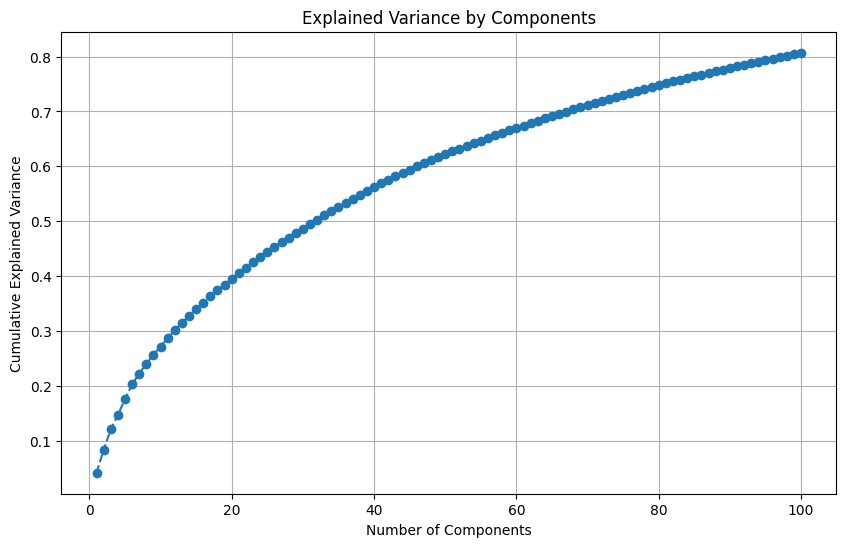

Top 10 terms for component 1:
firstyear: 0.5751
mccormick: 0.5751
experience: 0.5748
communication: 0.0653
designthinking: 0.0569
design: 0.0171
topics: 0.0110
personaldevelopment: 0.0086
qualitative: 0.0050
improv: 0.0049


Top 10 terms for component 2:
communication: 0.7476
designthinking: 0.6551
design: 0.0432
topics: 0.0296
personaldevelopment: 0.0232
introduction: 0.0204
thinking: 0.0098
method: 0.0087
appropriability: 0.0068
technology: 0.0054


Top 10 terms for component 3:
topics: 0.7293
personaldevelopment: 0.6398
design: 0.2039
selection: 0.0567
introduction: 0.0480
civil: 0.0405
environmental: 0.0388
appropriability: 0.0345
advanced: 0.0287
intermediate: 0.0243


Top 10 terms for component 4:
introduction: 0.6949
design: 0.5519
computing: 0.2334
material: 0.2053
appropriability: 0.1334
program: 0.1044
electricalengineering: 0.0647
biomechanical: 0.0625
project: 0.0557
develop: 0.0553


Top 10 terms for component 5:
design: 0.7329
appropriability: 0.2012
project: 0.0653
resea

In [12]:
from sklearn.decomposition import TruncatedSVD

# Fit SVD model
n_components = 100
svd_model = TruncatedSVD(n_components=n_components, random_state=42)
lsa_matrix = svd_model.fit_transform(tfidf_matrix)

# Explained variance
explained_variance = svd_model.explained_variance_ratio_.cumsum()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# Choosing optimal components
optimal_components = 40
svd_model_optimal = TruncatedSVD(n_components=optimal_components, random_state=42)
lsa_matrix_optimal = svd_model_optimal.fit_transform(tfidf_matrix)

# Get the terms from the vectorizer
terms = tfidf_vectorizer.get_feature_names_out()

# Access the loadings (components)
loadings = svd_model_optimal.components_

# Print the top 10 terms for each component
for i, comp in enumerate(loadings, 1):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)
    top_terms = sorted_terms[:10]
    print(f"Top 10 terms for component {i}:")
    for term, weight in top_terms:
        print(f"{term}: {weight:.4f}")
    print("\n")

# Add LSA components to your DataFrame
lsa_df_optimal = pd.DataFrame(lsa_matrix_optimal, columns=[f'LSA_{i+1}' for i in range(optimal_components)])
lsa_df_optimal.index = df_new.index
df_new = pd.concat([df_new, lsa_df_optimal], axis=1)
df.drop(['Descr'],axis=1, inplace=True)

# Optional: Drop columns no longer needed
df_new.drop(['Descr', 'tokens', 'filtered_tokens', 'processed_text'], axis=1, inplace=True)

In [13]:
# Rename LSA concepts to more interpretable names
new_names = [
    "Experience_FirstYear_LSA", "Communication_Design_LSA", "Topics_PersonalDev_LSA",
    "Intro_Design_LSA", "Design_Project_LSA", "EngAnalysis_LSA", "DTC_Method_LSA",
    "Computing_Program_LSA", "Seminar_Manage_LSA", "Statistics_Data_LSA",
    "Material_Process_LSA", "Systems_Physics_LSA", "Mechanics_Fluids_LSA",
    "Project_Management_LSA", "Selection_MechEng_LSA", "Selection_Optimization_LSA",
    "Optimization_Modeling_LSA", "Analysis_Program_LSA", "Probabilities_Program_LSA",
    "Analysis_Human_LSA", "Data_Structure_LSA", "Mechanical_Manufacturing_LSA",
    "Thermodynamic_Env_LSA", "Environmental_Modeling_LSA", "Principles_Entrepreneurial_LSA",
    "Discourse_Statistics_LSA", "Machine_Learning_LSA", "Modeling_Stochastic_LSA",
    "Fundamentals_Transport_LSA", "Construction_Manage_LSA", "Develop_Career_LSA",
    "Advance_Communication_LSA", "Life_Designing_LSA", "Life_DesigningComm_LSA",
    "Structure_Theoretical_LSA", "ResponsibleConduct_Train_LSA", "Construction_Computing_LSA",
    "Advanced_Analytical_LSA", "Management_Transport_LSA", "Simulation_Disc_LSA"
]

# Dictionary to map old names to new names
name_mapping = {f'LSA_{i+1}': new_names[i] for i in range(len(new_names))}

# Renaming the columns
df_new.rename(columns=name_mapping, inplace=True)

### Fully Preprocessed DataFrame

In [14]:
# View head
print(f"{df.head()}\n")
# Print columns and number of columns in the original DataFrame
num_cols_df = df.shape[1]
print(f"Number of columns in original DataFrame: {num_cols_df}\n")
print(f"The columns are: {df.columns}\n")
print(f"The datatypes are: {df.dtypes}\n")

       Term  Subject Component  Enrollment Capacity  Total Enrollment  \
122  Winter  CIV_ENV       SEM                   30                 8   
123  Winter   LDRSHP       SEM                   30                 7   
136  Winter     MSIA       LEC                   34                32   
137  Winter     MSIA       LEC                   36                38   
138  Winter     MSIA       LEC                   36                41   

                  Instructor Start Time Mon Tues Wed Thurs Fri Sat Sun  \
122             Corr,David J   15:30:00   Y    N   N     N   N   N   N   
123       Murphy,Todd Edward   15:30:00   N    N   N     Y   N   N   N   
136  Walker,Russell Franklin   12:00:00   N    Y   N     N   N   N   N   
137             Apley,Daniel   11:00:00   Y    N   Y     N   N   N   N   
138    Malthouse,Edward Carl   14:00:00   Y    N   Y     N   N   N   N   

    Subject-Catalog           Duration  Year  
122   CIV_ENV_301-1            2 hours  2015  
123    LDRSHP_396-0  1

For a sanity check, lets compare this to the df without LSA, ensuring that there are consistencies with row indices

In [15]:
# View head
print(f"{df_new.head()}\n")
# Print columns and number of columns in the original DataFrame
num_cols_df_new = df_new.shape[1]
print(f"Number of columns in original DataFrame: {num_cols_df_new}\n")
print(f"The columns are: {df_new.columns}\n")
print(f"The datatypes are: {df_new.dtypes}\n")

       Term  Subject Component  Enrollment Capacity  Total Enrollment  \
122  Winter  CIV_ENV       SEM                   30                 8   
123  Winter   LDRSHP       SEM                   30                 7   
136  Winter     MSIA       LEC                   34                32   
137  Winter     MSIA       LEC                   36                38   
138  Winter     MSIA       LEC                   36                41   

                  Instructor Start Time Mon Tues Wed  ... Develop_Career_LSA  \
122             Corr,David J   15:30:00   Y    N   N  ...           0.002659   
123       Murphy,Todd Edward   15:30:00   N    N   N  ...           0.001487   
136  Walker,Russell Franklin   12:00:00   N    Y   N  ...          -0.065579   
137             Apley,Daniel   11:00:00   Y    N   Y  ...          -0.026937   
138    Malthouse,Edward Carl   14:00:00   Y    N   Y  ...          -0.063815   

    Advance_Communication_LSA Life_Designing_LSA Life_DesigningComm_LSA  \
122  

# Modeling

For ease of scaling data for linear models, lets create some helper functions:

In [16]:
from sklearn.preprocessing import StandardScaler

def factorize_dataframe(df):
    """ Factorizes all categorical columns of a dataframe. """
    for column in df.columns:
        if df[column].dtype == 'category':
            df[column], _ = pd.factorize(df[column])
    return df

def prepare_data(df):
    # Factorize categorical variables
    df_factorized = factorize_dataframe(df.copy())

    # Initialize the scaler
    scaler = StandardScaler()

    # Scale the data
    scaled_array = scaler.fit_transform(df_factorized)

    # Return a new DataFrame
    scaled_df = pd.DataFrame(scaled_array, columns=df.columns)

    return scaled_df

## Initial Model Evaluations

For another metric of model performance, lets create another "Accuracy" metric, which is more of a precision metric. This is defined to be the percentage of forecasts within a standard deviation of true enrollment. We can choose which standard_deviation to use based on the bin size

In [17]:
def accuracy_metric(original, predicted, std_dev, deviation=1):
    """Calculate accuracy based on deviation from actual values.

    Args:
        original (array-like): The actual values.
        predicted (array-like): The predicted values.
        std_dev (float): The standard deviation of the actual values.
        deviation (int or float): The multiplier of standard deviations to define acceptable accuracy.

    Returns:
        float: The percentage of predictions that fall within the specified deviation.
    """
    # Calculate the absolute differences
    differences = np.abs(predicted - original)
    # Determine which differences are within the acceptable range
    within_range = differences <= deviation * std_dev
    # Calculate accuracy as the percentage of values within the range
    accuracy = np.mean(within_range)
    return accuracy

## Split into training and testing sets

Next, lets create a function to classify the class size type of each course, so we can train models on, and evaluate model performance on certain types of class sizes (small, medium, or large)

In [18]:
def classify_class_size(df, small_threshold, medium_threshold):
    def apply_class_size(row):
        if row['Enrollment Capacity'] < small_threshold:
            return 'Small'
        elif row['Enrollment Capacity'] < medium_threshold:
            return 'Medium'
        else:
            return 'Large'

    df['Class Size Category'] = df.apply(apply_class_size, axis=1)
    return df

Lets define this file to be models with a (0,30,70) threshold split for small, medium, and large classes. Identical files with different bin sizes were created to easily compare and determine the optimal bin sizes (refer to report).

In [19]:
small_threshold = 30
medium_threshold= 70

df_new = classify_class_size(df_new, small_threshold, medium_threshold)
df = classify_class_size(df, small_threshold, medium_threshold)
df['Class Size Category'] = df['Class Size Category'].astype('category')

In [20]:
# Initialize a dictionary to store each column's mapping
mapping_dicts = {}

# Loop through each categorical column and create a mapping dictionary
for column in df.select_dtypes(include=['category']).columns:
    unique_values = df[column].cat.categories
    mapping_dict = {value: i for i, value in enumerate(unique_values)}
    mapping_dicts[column] = mapping_dict

# Print out the mapping dictionaries for review (optional)
for column, mapping in mapping_dicts.items():
    print(f"Mapping for {column}: {mapping}")
### Step 3: Save the Mapping Dictionaries to a File
with open('mapping_dicts.pkl', 'wb') as f:
    pickle.dump(mapping_dicts, f)

Mapping for Term: {'Fall': 0, 'Spring': 1, 'Summer': 2, 'Winter': 3}
Mapping for Subject: {'BMD_ENG': 0, 'CHEM_ENG': 1, 'CIV_ENV': 2, 'COMP_ENG': 3, 'COMP_SCI': 4, 'CRDV': 5, 'DATA_ENG': 6, 'DSGN': 7, 'EECS': 8, 'ELEC_ENG': 9, 'ENTREP': 10, 'ES_APPM': 11, 'GEN_ENG': 12, 'IEMS': 13, 'INF_TECH': 14, 'ISEN': 15, 'LDRSHP': 16, 'MAT_SCI': 17, 'MBAI': 18, 'MBIOTECH': 19, 'MECH_ENG': 20, 'MEM': 21, 'MLDS': 22, 'MPD': 23, 'MSAI': 24, 'MSIA': 25, 'NICO': 26, 'PRDV': 27, 'PROJ_MGT': 28, 'PSED': 29}
Mapping for Component: {'DIS': 0, 'LAB': 1, 'LEC': 2, 'SEM': 3}
Mapping for Instructor: {'Abrams,Daniel Michael': 0, 'Abrevaya,Hayim': 1, 'Acuna,Eduardo L': 2, 'Adelman,Jessica Craigle': 3, 'Adolph,Megan Elizabeth': 4, 'Akono,Ange-Therese': 5, 'Al-Hallaj,Said': 6, 'Al-Najjar,Nabil I': 7, 'Alam,Mohammed Anwarul': 8, 'Alarcon-Fleming,Arantzazu': 9, 'Alizadehsalehi,Sepehr': 10, 'Aloysius,Ignatius Valentine': 11, 'Amaral,Luis A N': 12, 'Ameer,Guillermo Antonio': 13, 'Anderson,John Christopher': 14, 'Anken

### Define X (predictor data) and y (true enrollment labels)

In [21]:
# Create data subsets with and without LSA features
X_lsa = df_new.drop(['Total Enrollment', 'Enrollment Capacity', 'Year'], axis=1)
y_lsa = df_new['Total Enrollment']
X_no_lsa = df_new.drop(columns=[col for col in df_new.columns if 'LSA' in col] + ['Total Enrollment', 'Enrollment Capacity', 'Year'])

# Define class size categories
class_size_categories = ['Small', 'Medium', 'Large']

# Dictionaries to store training and testing sets
train_lsa = {}
test_lsa = {}
train_no_lsa = {}
test_no_lsa = {}

# Selecting test datasets using predefined indices
X_test_lsa = X_lsa.loc[term_indices]
y_test_lsa = y_lsa.loc[term_indices]
X_test_no_lsa = X_no_lsa.loc[term_indices]
y_test_no_lsa = y_lsa.loc[term_indices]

# Remove test set indices to form the training dataset
train_df_lsa = X_lsa.drop(index=term_indices)
train_df_no_lsa = X_no_lsa.drop(index=term_indices)
y_train_lsa = y_lsa.drop(index=term_indices)
y_train_no_lsa = y_lsa.drop(index=term_indices)

# Process each category for training
for category in ['All'] + class_size_categories:
    print(f"\nProcessing category: {category}")

    if category == 'All':
        # Use all data
        category_mask_lsa = train_df_lsa.index
        category_mask_no_lsa = train_df_no_lsa.index
    else:
        # Filter data for the current category in training data
        category_mask_lsa = train_df_lsa[train_df_lsa['Class Size Category'] == category].index
        category_mask_no_lsa = train_df_no_lsa[train_df_no_lsa['Class Size Category'] == category].index

    # Store the training data
    train_lsa[category] = (train_df_lsa.loc[category_mask_lsa], y_train_lsa.loc[category_mask_lsa])
    train_no_lsa[category] = (train_df_no_lsa.loc[category_mask_no_lsa], y_train_no_lsa.loc[category_mask_no_lsa])

    # Testing data is the same across categories but filtered for consistency
    test_lsa[category] = (X_test_lsa[X_test_lsa['Class Size Category'] == category] if category != 'All' else X_test_lsa,
                          y_test_lsa[X_test_lsa['Class Size Category'] == category].index if category != 'All' else y_test_lsa)
    test_no_lsa[category] = (X_test_no_lsa[X_test_no_lsa['Class Size Category'] == category] if category != 'All' else X_test_no_lsa,
                             y_test_no_lsa[X_test_no_lsa['Class Size Category'] == category].index if category != 'All' else y_test_no_lsa)


Processing category: All

Processing category: Small

Processing category: Medium

Processing category: Large


Now that we have created our splits of data for the different class size types, lets observe the size of each training and testing split:

In [22]:
categories = ['All','Small', 'Medium', 'Large']

for category in categories:
    print(f"\nProcessing category: {category}")
    # Print sizes for training and testing sets with LSA
    print(f"{category} - Training with LSA: {train_lsa[category][0].shape}, Testing with LSA: {test_lsa[category][0].shape}")
    # Print sizes for training and testing sets without LSA
    print(f"{category} - Training without LSA: {train_no_lsa[category][0].shape}, Testing without LSA: {test_no_lsa[category][0].shape}")


Processing category: All
All - Training with LSA: (7774, 55), Testing with LSA: (1197, 55)
All - Training without LSA: (7774, 15), Testing without LSA: (1197, 15)

Processing category: Small
Small - Training with LSA: (3199, 55), Testing with LSA: (455, 55)
Small - Training without LSA: (3199, 15), Testing without LSA: (455, 15)

Processing category: Medium
Medium - Training with LSA: (3698, 55), Testing with LSA: (591, 55)
Medium - Training without LSA: (3698, 15), Testing without LSA: (591, 15)

Processing category: Large
Large - Training with LSA: (877, 55), Testing with LSA: (151, 55)
Large - Training without LSA: (877, 15), Testing without LSA: (151, 15)


Lets save these data splits into variables, and observe the heads as a sanity check

In [23]:
# With LSA
X_small_train_lsa = train_lsa['Small'][0].drop(columns=['Class Size Category'])
y_small_train_lsa = train_lsa['Small'][1]
X_small_test_lsa = test_lsa['Small'][0].drop(columns=['Class Size Category'])
y_small_test_lsa = test_lsa['Small'][1]

X_medium_train_lsa = train_lsa['Medium'][0].drop(columns=['Class Size Category'])
y_medium_train_lsa = train_lsa['Medium'][1]
X_medium_test_lsa = test_lsa['Medium'][0].drop(columns=['Class Size Category'])
y_medium_test_lsa = test_lsa['Medium'][1]

X_large_train_lsa = train_lsa['Large'][0].drop(columns=['Class Size Category'])
y_large_train_lsa = train_lsa['Large'][1]
X_large_test_lsa = test_lsa['Large'][0].drop(columns=['Class Size Category'])
y_large_test_lsa = test_lsa['Large'][1]

# Without LSA
X_small_train = train_no_lsa['Small'][0].drop(columns=['Class Size Category'])
y_small_train = train_no_lsa['Small'][1]
X_small_test = test_no_lsa['Small'][0].drop(columns=['Class Size Category'])
y_small_test = test_no_lsa['Small'][1]

X_medium_train = train_no_lsa['Medium'][0].drop(columns=['Class Size Category'])
y_medium_train = train_no_lsa['Medium'][1]
X_medium_test = test_no_lsa['Medium'][0].drop(columns=['Class Size Category'])
y_medium_test = test_no_lsa['Medium'][1]

X_large_train = train_no_lsa['Large'][0].drop(columns=['Class Size Category'])
y_large_train = train_no_lsa['Large'][1]
X_large_test = test_no_lsa['Large'][0].drop(columns=['Class Size Category'])
y_large_test = test_no_lsa['Large'][1]

print("\nSmall Class Size - Training Data Sample with LSA:")
print(X_small_train_lsa.head())
print(y_small_train_lsa.head())

# With LSA
X_all_train_lsa = train_lsa['All'][0].drop(columns=['Class Size Category'])
y_all_train_lsa = train_lsa['All'][1]
X_all_test_lsa = test_lsa['All'][0].drop(columns=['Class Size Category'])
y_all_test_lsa = test_lsa['All'][1]

# Without LSA
X_all_train = train_no_lsa['All'][0].drop(columns=['Class Size Category'])
y_all_train = train_no_lsa['All'][1]
X_all_test = test_no_lsa['All'][0].drop(columns=['Class Size Category'])
y_all_test = test_no_lsa['All'][1]

print("\n'All' Category - Training Data Sample with LSA:")
print(X_all_train_lsa.head())
print(y_all_train_lsa.head())

print("\n'All' Category - Training Data Sample without LSA:")
print(X_all_train.head())
print(y_all_train.head())


Small Class Size - Training Data Sample with LSA:
       Term   Subject Component          Instructor Start Time Mon Tues Wed  \
333  Winter      IEMS       LAB    Waechter,Andreas   16:00:00   Y    N   N   
336  Winter      IEMS       LEC    Lefebvre,Jeffrey   18:30:00   Y    N   N   
350  Winter      IEMS       LEC  Dolinskaya,Irina S   12:30:00   Y    N   Y   
778  Winter  CHEM_ENG       LEC     Cole,Jennifer L   12:00:00   Y    Y   Y   
788  Winter      EECS       LEC            Yan,Chao   11:00:00   N    Y   N   

    Thurs Fri  ... Develop_Career_LSA Advance_Communication_LSA  \
333     N   N  ...          -0.037604                  0.079773   
336     N   N  ...           0.110385                  0.040694   
350     N   N  ...           0.008514                 -0.009233   
778     N   Y  ...          -0.050587                  0.155285   
788     Y   N  ...          -0.053988                 -0.068278   

    Life_Designing_LSA Life_DesigningComm_LSA  Structure_Theoretical_LS

### Define Models

For the sake of ease, lets define each possible model ina  fucntion, so we can easily apply it to a particular training and testing split, then retrieve useful model outpus (predictions, RMSE, actual model)

To ensure that our model is setup to perform the best, lets add some hyperparameter optimization. More specifically, lets define some grids for values of alpha (linear models) and XGboost hyperparemeters. For the linear models, lets perform a grid search (because the grid is rather small). For the XGBoost model, lets perform a random search (reasonable and quick approach to optimize the much larger grid of hyperparameters in the XGBoost models)

In [24]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

def linear_regression_metrics(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    rmse_scorer = make_scorer(mean_squared_error, squared=False)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return y_pred, np.mean(cv_scores), np.std(cv_scores), train_rmse, test_rmse, model

def lasso_regression_metrics(X_train, y_train, X_test, y_test, alphas):
    model = Lasso()
    grid = GridSearchCV(model, {'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_train_pred = best_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    y_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return y_pred, np.sqrt(-grid.best_score_), train_rmse, test_rmse, best_model

def ridge_regression_metrics(X_train, y_train, X_test, y_test, alphas):
    model = Ridge()
    grid = GridSearchCV(model, {'alpha': alphas}, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_train_pred = best_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    y_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return y_pred, np.sqrt(-grid.best_score_), train_rmse, test_rmse, best_model

def xgboost_metrics_with_grid_search(X_train, y_train, X_test, y_test):
    model = XGBRegressor(
        enable_categorical=True,
        use_label_encoder=False,
        eval_metric='rmse',
        early_stopping_rounds=10,
    )
    param_dist = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5],
        'min_child_weight': [1, 2, 3, 4, 5, 6],
        'gamma': [0.0, 0.1, 0.2],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.6, 0.7, 0.8],
        'reg_alpha': [1e-5, 1e-2, 0.1, 1, 5, 10, 20, 30, 50, 100],
        'reg_lambda': [1e-5, 1e-2, 0.1, 1, 5, 10, 20, 30, 50, 100]
    }
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_dist,
        n_iter=200,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    random_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=True)
    best_estimator = random_search.best_estimator_
    y_train_pred = best_estimator.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    predictions = best_estimator.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))

    return predictions, train_rmse, test_rmse, best_estimator

In [25]:
# Define the range of alpha values for Ridge and Lasso regression
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [26]:
# Retrieve actual values using the indices in y_small_test
y_small_test_actual = df_new.loc[y_small_test, 'Total Enrollment']
y_medium_test_actual = df_new.loc[y_medium_test, 'Total Enrollment']
y_large_test_actual = df_new.loc[y_large_test, 'Total Enrollment']
y_all_test_actual = df_new.loc[y_all_test.index, 'Total Enrollment']

#### Small Train:

In [27]:
# Scale data for linear models
X_small_train_lsa_scaled = prepare_data(X_small_train_lsa.copy())
X_small_test_lsa_scaled = prepare_data(X_small_test_lsa.copy())
X_small_train_no_lsa_scaled = prepare_data(X_small_train.copy())
X_small_test_no_lsa_scaled = prepare_data(X_small_test.copy())

# Model evaluation and predictions without LSA
linear_y_pred_small_no_lsa, linear_mean_cv_rmse_small_no_lsa, linear_std_cv_rmse_small_no_lsa, linear_train_rmse_small_no_lsa, linear_test_rmse_small_no_lsa, linear_model_small_no_lsa = linear_regression_metrics(
    X_small_train_no_lsa_scaled, y_small_train, X_small_test_no_lsa_scaled, y_small_test_actual
)

lasso_y_pred_small_no_lsa, lasso_cv_rmse_small_no_lsa, lasso_train_rmse_small_no_lsa, lasso_test_rmse_small_no_lsa, lasso_model_small_no_lsa = lasso_regression_metrics(
    X_small_train_no_lsa_scaled, y_small_train, X_small_test_no_lsa_scaled, y_small_test_actual, alphas
)

ridge_y_pred_small_no_lsa, ridge_cv_rmse_small_no_lsa, ridge_train_rmse_small_no_lsa, ridge_test_rmse_small_no_lsa, ridge_model_small_no_lsa = ridge_regression_metrics(
    X_small_train_no_lsa_scaled, y_small_train, X_small_test_no_lsa_scaled, y_small_test_actual, alphas
)

xgboost_predictions_small_no_lsa, xgboost_train_rmse_small_no_lsa, xgboost_test_rmse_small_no_lsa, xgboost_model_small_no_lsa = xgboost_metrics_with_grid_search(
    X_small_train, y_small_train, X_small_test, y_small_test_actual
)

print("\nWithout LSA:")
print("Linear Regression - Mean CV RMSE:", linear_mean_cv_rmse_small_no_lsa, "Std CV RMSE:", linear_std_cv_rmse_small_no_lsa, "Train RMSE:", linear_train_rmse_small_no_lsa, "Test RMSE:", linear_test_rmse_small_no_lsa)
print("Lasso Regression - CV RMSE:", lasso_cv_rmse_small_no_lsa, "Train RMSE:", lasso_train_rmse_small_no_lsa, "Test RMSE:", lasso_test_rmse_small_no_lsa)
print("Ridge Regression - CV RMSE:", ridge_cv_rmse_small_no_lsa, "Train RMSE:", ridge_train_rmse_small_no_lsa, "Test RMSE:", ridge_test_rmse_small_no_lsa)
print("XGBoost Regression - Train RMSE:", xgboost_train_rmse_small_no_lsa, "Test RMSE:", xgboost_test_rmse_small_no_lsa)

# Model evaluation and predictions with LSA
linear_y_pred_small_lsa, linear_mean_cv_rmse_small_lsa, linear_std_cv_rmse_small_lsa, linear_train_rmse_small_lsa, linear_test_rmse_small_lsa, linear_model_small_lsa = linear_regression_metrics(
    X_small_train_lsa_scaled, y_small_train_lsa, X_small_test_lsa_scaled, y_small_test_actual
)

lasso_y_pred_small_lsa, lasso_cv_rmse_small_lsa, lasso_train_rmse_small_lsa, lasso_test_rmse_small_lsa, lasso_model_small_lsa = lasso_regression_metrics(
    X_small_train_lsa_scaled, y_small_train_lsa, X_small_test_lsa_scaled, y_small_test_actual, alphas
)

ridge_y_pred_small_lsa, ridge_cv_rmse_small_lsa, ridge_train_rmse_small_lsa, ridge_test_rmse_small_lsa, ridge_model_small_lsa = ridge_regression_metrics(
    X_small_train_lsa_scaled, y_small_train_lsa, X_small_test_lsa_scaled, y_small_test_actual, alphas
)

xgboost_predictions_small_lsa, xgboost_train_rmse_small_lsa, xgboost_test_rmse_small_lsa, xgboost_model_small_lsa = xgboost_metrics_with_grid_search(
    X_small_train_lsa, y_small_train_lsa, X_small_test_lsa, y_small_test_actual
)

print("With LSA:")
print("Linear Regression - Mean CV RMSE:", linear_mean_cv_rmse_small_lsa, "Std CV RMSE:", linear_std_cv_rmse_small_lsa, "Train RMSE:", linear_train_rmse_small_lsa, "Test RMSE:", linear_test_rmse_small_lsa)
print("Lasso Regression - CV RMSE:", lasso_cv_rmse_small_lsa, "Train RMSE:", lasso_train_rmse_small_lsa, "Test RMSE:", lasso_test_rmse_small_lsa)
print("Ridge Regression - CV RMSE:", ridge_cv_rmse_small_lsa, "Train RMSE:", ridge_train_rmse_small_lsa, "Test RMSE:", ridge_test_rmse_small_lsa)
print("XGBoost Regression - Train RMSE:", xgboost_train_rmse_small_lsa, "Test RMSE:", xgboost_test_rmse_small_lsa)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[0]	validation_0-rmse:6.24186
[1]	validation_0-rmse:6.14658
[2]	validation_0-rmse:6.04688
[3]	validation_0-rmse:5.97497
[4]	validation_0-rmse:5.89524
[5]	validation_0-rmse:5.82554
[6]	validation_0-rmse:5.80078
[7]	validation_0-rmse:5.72776
[8]	validation_0-rmse:5.66689
[9]	validation_0-rmse:5.63904
[10]	validation_0-rmse:5.58331
[11]	validation_0-rmse:5.51944
[12]	validation_0-rmse:5.47326
[13]	validation_0-rmse:5.43139
[14]	validation_0-rmse:5.38180
[15]	validation_0-rmse:5.36866
[16]	validation_0-rmse:5.33119
[17]	validation_0-rmse:5.29352
[18]	validation_0-rmse:5.25802
[19]	validation_0-rmse:5.22232
[20]	validation_0-rmse:5.19887
[21]	validation_0-rmse:5.18284
[22]	validation_0-rmse:5.16742
[23]	validation_0-rmse:5.14333
[24]	validation_0-rmse:5.11665
[25]	validation_0-rmse:5.10120
[26]	validation_0-rmse:5.09236
[27]	validation_0-rmse:5.07778
[28]	validation_0-rmse:5.06174
[29]	validation_0-rmse:5.04103
[30]	validation_

#### Medium Train:

In [28]:
X_medium_train_lsa_scaled = prepare_data(X_medium_train_lsa.copy())
X_medium_test_lsa_scaled = prepare_data(X_medium_test_lsa.copy())
X_medium_train_no_lsa_scaled = prepare_data(X_medium_train.copy())
X_medium_test_no_lsa_scaled = prepare_data(X_medium_test.copy())

# Model evaluation and predictions without LSA
linear_y_pred_medium_no_lsa, linear_mean_cv_rmse_medium_no_lsa, linear_std_cv_rmse_medium_no_lsa, linear_train_rmse_medium_no_lsa, linear_test_rmse_medium_no_lsa, linear_model_medium_no_lsa = linear_regression_metrics(
    X_medium_train_no_lsa_scaled, y_medium_train, X_medium_test_no_lsa_scaled, y_medium_test_actual
)

lasso_y_pred_medium_no_lsa, lasso_cv_rmse_medium_no_lsa, lasso_train_rmse_medium_no_lsa, lasso_test_rmse_medium_no_lsa, lasso_model_medium_no_lsa = lasso_regression_metrics(
    X_medium_train_no_lsa_scaled, y_medium_train, X_medium_test_no_lsa_scaled, y_medium_test_actual, alphas
)

ridge_y_pred_medium_no_lsa, ridge_cv_rmse_medium_no_lsa, ridge_train_rmse_medium_no_lsa, ridge_test_rmse_medium_no_lsa, ridge_model_medium_no_lsa = ridge_regression_metrics(
    X_medium_train_no_lsa_scaled, y_medium_train, X_medium_test_no_lsa_scaled, y_medium_test_actual, alphas
)

xgboost_predictions_medium_no_lsa, xgboost_train_rmse_medium_no_lsa, xgboost_test_rmse_medium_no_lsa, xgboost_model_medium_no_lsa = xgboost_metrics_with_grid_search(
    X_medium_train, y_medium_train, X_medium_test, y_medium_test_actual
)

print("\nWithout LSA:")
print("Linear Regression - Mean CV RMSE:", linear_mean_cv_rmse_medium_no_lsa, "Std CV RMSE:", linear_std_cv_rmse_medium_no_lsa, "Train RMSE:", linear_train_rmse_medium_no_lsa, "Test RMSE:", linear_test_rmse_medium_no_lsa)
print("Lasso Regression - CV RMSE:", lasso_cv_rmse_medium_no_lsa, "Train RMSE:", lasso_train_rmse_medium_no_lsa, "Test RMSE:", lasso_test_rmse_medium_no_lsa)
print("Ridge Regression - CV RMSE:", ridge_cv_rmse_medium_no_lsa, "Train RMSE:", ridge_train_rmse_medium_no_lsa, "Test RMSE:", ridge_test_rmse_medium_no_lsa)
print("XGBoost Regression - Train RMSE:", xgboost_train_rmse_medium_no_lsa, "Test RMSE:", xgboost_test_rmse_medium_no_lsa)

# Model evaluation and predictions with LSA
linear_y_pred_medium_lsa, linear_mean_cv_rmse_medium_lsa, linear_std_cv_rmse_medium_lsa, linear_train_rmse_medium_lsa, linear_test_rmse_medium_lsa, linear_model_medium_lsa = linear_regression_metrics(
    X_medium_train_lsa_scaled, y_medium_train_lsa, X_medium_test_lsa_scaled, y_medium_test_actual
)

lasso_y_pred_medium_lsa, lasso_cv_rmse_medium_lsa, lasso_train_rmse_medium_lsa, lasso_test_rmse_medium_lsa, lasso_model_medium_lsa = lasso_regression_metrics(
    X_medium_train_lsa_scaled, y_medium_train_lsa, X_medium_test_lsa_scaled, y_medium_test_actual, alphas
)

ridge_y_pred_medium_lsa, ridge_cv_rmse_medium_lsa, ridge_train_rmse_medium_lsa, ridge_test_rmse_medium_lsa, ridge_model_medium_lsa = ridge_regression_metrics(
    X_medium_train_lsa_scaled, y_medium_train_lsa, X_medium_test_lsa_scaled, y_medium_test_actual, alphas
)

xgboost_predictions_medium_lsa, xgboost_train_rmse_medium_lsa, xgboost_test_rmse_medium_lsa, xgboost_model_medium_lsa = xgboost_metrics_with_grid_search(
    X_medium_train_lsa, y_medium_train_lsa, X_medium_test_lsa, y_medium_test_actual
)

print("With LSA:")
print("Linear Regression - Mean CV RMSE:", linear_mean_cv_rmse_medium_lsa, "Std CV RMSE:", linear_std_cv_rmse_medium_lsa, "Train RMSE:", linear_train_rmse_medium_lsa, "Test RMSE:", linear_test_rmse_medium_lsa)
print("Lasso Regression - CV RMSE:", lasso_cv_rmse_medium_lsa, "Train RMSE:", lasso_train_rmse_medium_lsa, "Test RMSE:", lasso_test_rmse_medium_lsa)
print("Ridge Regression - CV RMSE:", ridge_cv_rmse_medium_lsa, "Train RMSE:", ridge_train_rmse_medium_lsa, "Test RMSE:", ridge_test_rmse_medium_lsa)
print("XGBoost Regression - Train RMSE:", xgboost_train_rmse_medium_lsa, "Test RMSE:", xgboost_test_rmse_medium_lsa)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[0]	validation_0-rmse:14.16539
[1]	validation_0-rmse:14.11322
[2]	validation_0-rmse:14.05366
[3]	validation_0-rmse:14.00773
[4]	validation_0-rmse:13.94931
[5]	validation_0-rmse:13.90010
[6]	validation_0-rmse:13.87350
[7]	validation_0-rmse:13.82441
[8]	validation_0-rmse:13.76595
[9]	validation_0-rmse:13.72314
[10]	validation_0-rmse:13.67128
[11]	validation_0-rmse:13.62313
[12]	validation_0-rmse:13.58176
[13]	validation_0-rmse:13.53901
[14]	validation_0-rmse:13.49466
[15]	validation_0-rmse:13.45811
[16]	validation_0-rmse:13.41112
[17]	validation_0-rmse:13.36183
[18]	validation_0-rmse:13.31704
[19]	validation_0-rmse:13.26614
[20]	validation_0-rmse:13.22992
[21]	validation_0-rmse:13.19322
[22]	validation_0-rmse:13.15614
[23]	validation_0-rmse:13.11229
[24]	validation_0-rmse:13.06587
[25]	validation_0-rmse:13.02603
[26]	validation_0-rmse:12.98970
[27]	validation_0-rmse:12.94442
[28]	validation_0-rmse:12.90695
[29]	validation_0-

#### Large Train:

In [29]:
X_large_train_lsa_scaled = prepare_data(X_large_train_lsa.copy())
X_large_test_lsa_scaled = prepare_data(X_large_test_lsa.copy())
X_large_train_no_lsa_scaled = prepare_data(X_large_train.copy())
X_large_test_no_lsa_scaled = prepare_data(X_large_test.copy())

# Model evaluation and predictions without LSA
linear_y_pred_large_no_lsa, linear_mean_cv_rmse_large_no_lsa, linear_std_cv_rmse_large_no_lsa, linear_train_rmse_large_no_lsa, linear_test_rmse_large_no_lsa, linear_model_large_no_lsa = linear_regression_metrics(
    X_large_train_no_lsa_scaled, y_large_train, X_large_test_no_lsa_scaled, y_large_test_actual
)

lasso_y_pred_large_no_lsa, lasso_cv_rmse_large_no_lsa, lasso_train_rmse_large_no_lsa, lasso_test_rmse_large_no_lsa, lasso_model_large_no_lsa = lasso_regression_metrics(
    X_large_train_no_lsa_scaled, y_large_train, X_large_test_no_lsa_scaled, y_large_test_actual, alphas
)

ridge_y_pred_large_no_lsa, ridge_cv_rmse_large_no_lsa, ridge_train_rmse_large_no_lsa, ridge_test_rmse_large_no_lsa, ridge_model_large_no_lsa = ridge_regression_metrics(
    X_large_train_no_lsa_scaled, y_large_train, X_large_test_no_lsa_scaled, y_large_test_actual, alphas
)

xgboost_predictions_large_no_lsa, xgboost_train_rmse_large_no_lsa, xgboost_test_rmse_large_no_lsa, xgboost_model_large_no_lsa = xgboost_metrics_with_grid_search(
    X_large_train, y_large_train, X_large_test, y_large_test_actual
)

print("\nWithout LSA:")
print("Linear Regression - Mean CV RMSE:", linear_mean_cv_rmse_large_no_lsa, "Std CV RMSE:", linear_std_cv_rmse_large_no_lsa, "Train RMSE:", linear_train_rmse_large_no_lsa, "Test RMSE:", linear_test_rmse_large_no_lsa)
print("Lasso Regression - CV RMSE:", lasso_cv_rmse_large_no_lsa, "Train RMSE:", lasso_train_rmse_large_no_lsa, "Test RMSE:", lasso_test_rmse_large_no_lsa)
print("Ridge Regression - CV RMSE:", ridge_cv_rmse_large_no_lsa, "Train RMSE:", ridge_train_rmse_large_no_lsa, "Test RMSE:", ridge_test_rmse_large_no_lsa)
print("XGBoost Regression - Train RMSE:", xgboost_train_rmse_large_no_lsa, "Test RMSE:", xgboost_test_rmse_large_no_lsa)

# Model evaluation and predictions with LSA
linear_y_pred_large_lsa, linear_mean_cv_rmse_large_lsa, linear_std_cv_rmse_large_lsa, linear_train_rmse_large_lsa, linear_test_rmse_large_lsa, linear_model_large_lsa = linear_regression_metrics(
    X_large_train_lsa_scaled, y_large_train, X_large_test_lsa_scaled, y_large_test_actual
)

lasso_y_pred_large_lsa, lasso_cv_rmse_large_lsa, lasso_train_rmse_large_lsa, lasso_test_rmse_large_lsa, lasso_model_large_lsa = lasso_regression_metrics(
    X_large_train_lsa_scaled, y_large_train, X_large_test_lsa_scaled, y_large_test_actual, alphas
)

ridge_y_pred_large_lsa, ridge_cv_rmse_large_lsa, ridge_train_rmse_large_lsa, ridge_test_rmse_large_lsa, ridge_model_large_lsa = ridge_regression_metrics(
    X_large_train_lsa_scaled, y_large_train, X_large_test_lsa_scaled, y_large_test_actual, alphas
)

xgboost_predictions_large_lsa, xgboost_train_rmse_large_lsa, xgboost_test_rmse_large_lsa, xgboost_model_large_lsa = xgboost_metrics_with_grid_search(
    X_large_train_lsa, y_large_train, X_large_test_lsa, y_large_test_actual
)

print("With LSA:")
print("Linear Regression - Mean CV RMSE:", linear_mean_cv_rmse_large_lsa, "Std CV RMSE:", linear_std_cv_rmse_large_lsa, "Train RMSE:", linear_train_rmse_large_lsa, "Test RMSE:", linear_test_rmse_large_lsa)
print("Lasso Regression - CV RMSE:", lasso_cv_rmse_large_lsa, "Train RMSE:", lasso_train_rmse_large_lsa, "Test RMSE:", lasso_test_rmse_large_lsa)
print("Ridge Regression - CV RMSE:", ridge_cv_rmse_large_lsa, "Train RMSE:", ridge_train_rmse_large_lsa, "Test RMSE:", ridge_test_rmse_large_lsa)
print("XGBoost Regression - Train RMSE:", xgboost_train_rmse_large_lsa, "Test RMSE:", xgboost_test_rmse_large_lsa)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[0]	validation_0-rmse:53.83574
[1]	validation_0-rmse:51.58885
[2]	validation_0-rmse:49.13966
[3]	validation_0-rmse:46.92885
[4]	validation_0-rmse:45.36187
[5]	validation_0-rmse:43.72271
[6]	validation_0-rmse:43.56393
[7]	validation_0-rmse:42.53511
[8]	validation_0-rmse:41.68871
[9]	validation_0-rmse:41.28172
[10]	validation_0-rmse:40.64199
[11]	validation_0-rmse:40.01881
[12]	validation_0-rmse:39.49715
[13]	validation_0-rmse:39.31130
[14]	validation_0-rmse:39.20601
[15]	validation_0-rmse:39.12524
[16]	validation_0-rmse:39.14305
[17]	validation_0-rmse:39.22816
[18]	validation_0-rmse:38.85380
[19]	validation_0-rmse:38.69694
[20]	validation_0-rmse:38.71348
[21]	validation_0-rmse:38.53488
[22]	validation_0-rmse:38.48110
[23]	validation_0-rmse:38.42346
[24]	validation_0-rmse:38.42890
[25]	validation_0-rmse:38.45089
[26]	validation_0-rmse:38.31344
[27]	validation_0-rmse:38.30105
[28]	validation_0-rmse:38.39129
[29]	validation_0-

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.297e+05, tolerance: 2.465e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.725e+05, tolerance: 2.160e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.599e+05, tolerance: 2.192e

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[0]	validation_0-rmse:54.26937
[1]	validation_0-rmse:51.76224
[2]	validation_0-rmse:49.74813
[3]	validation_0-rmse:47.92719
[4]	validation_0-rmse:46.50578
[5]	validation_0-rmse:45.10574
[6]	validation_0-rmse:44.11713
[7]	validation_0-rmse:43.21272
[8]	validation_0-rmse:42.42199
[9]	validation_0-rmse:41.82025
[10]	validation_0-rmse:41.12671
[11]	validation_0-rmse:40.60176
[12]	validation_0-rmse:40.67413
[13]	validation_0-rmse:40.37037
[14]	validation_0-rmse:40.35692
[15]	validation_0-rmse:40.05582
[16]	validation_0-rmse:39.74529
[17]	validation_0-rmse:39.89875
[18]	validation_0-rmse:39.60264
[19]	validation_0-rmse:39.42671
[20]	validation_0-rmse:39.60461
[21]	validation_0-rmse:39.46072
[22]	validation_0-rmse:39.24780
[23]	validation_0-rmse:39.36876
[24]	validation_0-rmse:39.23693
[25]	validation_0-rmse:39.46977
[26]	validation_0-rmse:39.43408
[27]	validation_0-rmse:39.42663
[28]	validation_0-rmse:39.33838
[29]	validation_0-

#### All-Data train:

Finally, lets train models on all the data, to compare to the models trained on specific class size types.

In [30]:
X_all_train_lsa_scaled = prepare_data(X_all_train_lsa.copy())
X_all_test_lsa_scaled = prepare_data(X_all_test_lsa.copy())
X_all_train_no_lsa_scaled = prepare_data(X_all_train.copy())
X_all_test_no_lsa_scaled = prepare_data(X_all_test.copy())

# Model evaluation and predictions without LSA
linear_y_pred_all_no_lsa, linear_mean_cv_rmse_all_no_lsa, linear_std_cv_rmse_all_no_lsa, linear_train_rmse_all_no_lsa, linear_test_rmse_all_no_lsa, linear_model_all_no_lsa = linear_regression_metrics(
    X_all_train_no_lsa_scaled, y_all_train, X_all_test_no_lsa_scaled, y_all_test_actual
)

lasso_y_pred_all_no_lsa, lasso_cv_rmse_all_no_lsa, lasso_train_rmse_all_no_lsa, lasso_test_rmse_all_no_lsa, lasso_model_all_no_lsa = lasso_regression_metrics(
    X_all_train_no_lsa_scaled, y_all_train, X_all_test_no_lsa_scaled, y_all_test_actual, alphas
)

ridge_y_pred_all_no_lsa, ridge_cv_rmse_all_no_lsa, ridge_train_rmse_all_no_lsa, ridge_test_rmse_all_no_lsa, ridge_model_all_no_lsa = ridge_regression_metrics(
    X_all_train_no_lsa_scaled, y_all_train, X_all_test_no_lsa_scaled, y_all_test_actual, alphas
)

xgboost_predictions_all_no_lsa, xgboost_train_rmse_all_no_lsa, xgboost_test_rmse_all_no_lsa, xgboost_model_all_no_lsa = xgboost_metrics_with_grid_search(
    X_all_train, y_all_train, X_all_test, y_all_test_actual
)

print("\nWithout LSA:")
print("Linear Regression - Mean CV RMSE:", linear_mean_cv_rmse_all_no_lsa, "Std CV RMSE:", linear_std_cv_rmse_all_no_lsa, "Train RMSE:", linear_train_rmse_all_no_lsa, "Test RMSE:", linear_test_rmse_all_no_lsa)
print("Lasso Regression - CV RMSE:", lasso_cv_rmse_all_no_lsa, "Train RMSE:", lasso_train_rmse_all_no_lsa, "Test RMSE:", lasso_test_rmse_all_no_lsa)
print("Ridge Regression - CV RMSE:", ridge_cv_rmse_all_no_lsa, "Train RMSE:", ridge_train_rmse_all_no_lsa, "Test RMSE:", ridge_test_rmse_all_no_lsa)
print("XGBoost Regression - Train RMSE:", xgboost_train_rmse_all_no_lsa, "Test RMSE:", xgboost_test_rmse_all_no_lsa)

# Model evaluation and predictions with LSA
linear_y_pred_all_lsa, linear_mean_cv_rmse_all_lsa, linear_std_cv_rmse_all_lsa, linear_train_rmse_all_lsa, linear_test_rmse_all_lsa, linear_model_all_lsa = linear_regression_metrics(
    X_all_train_lsa_scaled, y_all_train_lsa, X_all_test_lsa_scaled, y_all_test_actual
)

lasso_y_pred_all_lsa, lasso_cv_rmse_all_lsa, lasso_train_rmse_all_lsa, lasso_test_rmse_all_lsa, lasso_model_all_lsa = lasso_regression_metrics(
    X_all_train_lsa_scaled, y_all_train_lsa, X_all_test_lsa_scaled, y_all_test_actual, alphas
)

ridge_y_pred_all_lsa, ridge_cv_rmse_all_lsa, ridge_train_rmse_all_lsa, ridge_test_rmse_all_lsa, ridge_model_all_lsa = ridge_regression_metrics(
    X_all_train_lsa_scaled, y_all_train_lsa, X_all_test_lsa_scaled, y_all_test_actual, alphas
)

xgboost_predictions_all_lsa, xgboost_train_rmse_all_lsa, xgboost_test_rmse_all_lsa, xgboost_model_all_lsa = xgboost_metrics_with_grid_search(
    X_all_train_lsa, y_all_train_lsa, X_all_test_lsa, y_all_test_actual
)

print("With LSA:")
print("Linear Regression - Mean CV RMSE:", linear_mean_cv_rmse_all_lsa, "Std CV RMSE:", linear_std_cv_rmse_all_lsa, "Train RMSE:", linear_train_rmse_all_lsa, "Test RMSE:", linear_test_rmse_all_lsa)
print("Lasso Regression - CV RMSE:", lasso_cv_rmse_all_lsa, "Train RMSE:", lasso_train_rmse_all_lsa, "Test RMSE:", lasso_test_rmse_all_lsa)
print("Ridge Regression - CV RMSE:", ridge_cv_rmse_all_lsa, "Train RMSE:", ridge_train_rmse_all_lsa, "Test RMSE:", ridge_test_rmse_all_lsa)
print("XGBoost Regression - Train RMSE:", xgboost_train_rmse_all_lsa, "Test RMSE:", xgboost_test_rmse_all_lsa)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[0]	validation_0-rmse:32.61733
[1]	validation_0-rmse:31.76637
[2]	validation_0-rmse:31.07461
[3]	validation_0-rmse:30.46599
[4]	validation_0-rmse:29.68706
[5]	validation_0-rmse:28.94128
[6]	validation_0-rmse:28.65015
[7]	validation_0-rmse:28.03113
[8]	validation_0-rmse:27.52890
[9]	validation_0-rmse:27.13114
[10]	validation_0-rmse:26.57927
[11]	validation_0-rmse:26.03008
[12]	validation_0-rmse:25.53234
[13]	validation_0-rmse:25.01860
[14]	validation_0-rmse:24.57479
[15]	validation_0-rmse:24.28886
[16]	validation_0-rmse:23.92148
[17]	validation_0-rmse:23.52350
[18]	validation_0-rmse:23.14894
[19]	validation_0-rmse:22.80034
[20]	validation_0-rmse:22.47152
[21]	validation_0-rmse:22.21028
[22]	validation_0-rmse:21.97642
[23]	validation_0-rmse:21.72815
[24]	validation_0-rmse:21.59676
[25]	validation_0-rmse:21.40677
[26]	validation_0-rmse:21.24382
[27]	validation_0-rmse:21.09577
[28]	validation_0-rmse:20.98717
[29]	validation_0-

In [31]:
def calculate_rmse(model, X_train, y_train, X_test, y_test):

    # Predict on training data
    y_train_pred = model.predict(X_train)

    # Predict on test data
    y_test_pred = model.predict(X_test)

    # Calculate RMSE for training data
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    # Calculate RMSE for test data
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    return train_rmse, test_rmse

In [32]:
small_class_df = df_new[df_new['Class Size Category'] == 'Small']
medium_class_df = df_new[df_new['Class Size Category'] == 'Medium']
large_class_df = df_new[df_new['Class Size Category'] == 'Large']

#### Small-Classes

Naive RMSE when predicting 'Enrollment Capacity' for small class size as the mean: 7.1446591133625015
Mean of 'Total Enrollment' for small class size: 15.07416529830323
Naive RMSE when predicting 'Total Enrollment' for small class size as the mean: 6.3451199038942026

RMSE for Different Class Sizes Without LSA:
Small Class RMSE - Linear: 6.385550644454054 Lasso: 6.328624961346045 Ridge: 6.341264803598456 XGBoost: 4.840692605407113
All Model (Trained on All, Tested on Small) RMSE - Linear: 18.53716240783167 Lasso: 18.31270689083986 Ridge: 17.670710638786332 XGBoost: 205.89885606188906

RMSE for Different Class Sizes With LSA:
Small Class RMSE - Linear: 6.169078059010046 Lasso: 6.013392287216756 Ridge: 6.077870928716396 XGBoost: 4.8727866379779226
All Model (Trained on All, Tested on Small) RMSE - Linear: 21.715194317580004 Lasso: 21.70959925076915 Ridge: 21.715192135960415 XGBoost: 159.9440853966562

Accuracy for Different Class Sizes Without LSA:
Small Class Accuracy - Linear: 0.694505

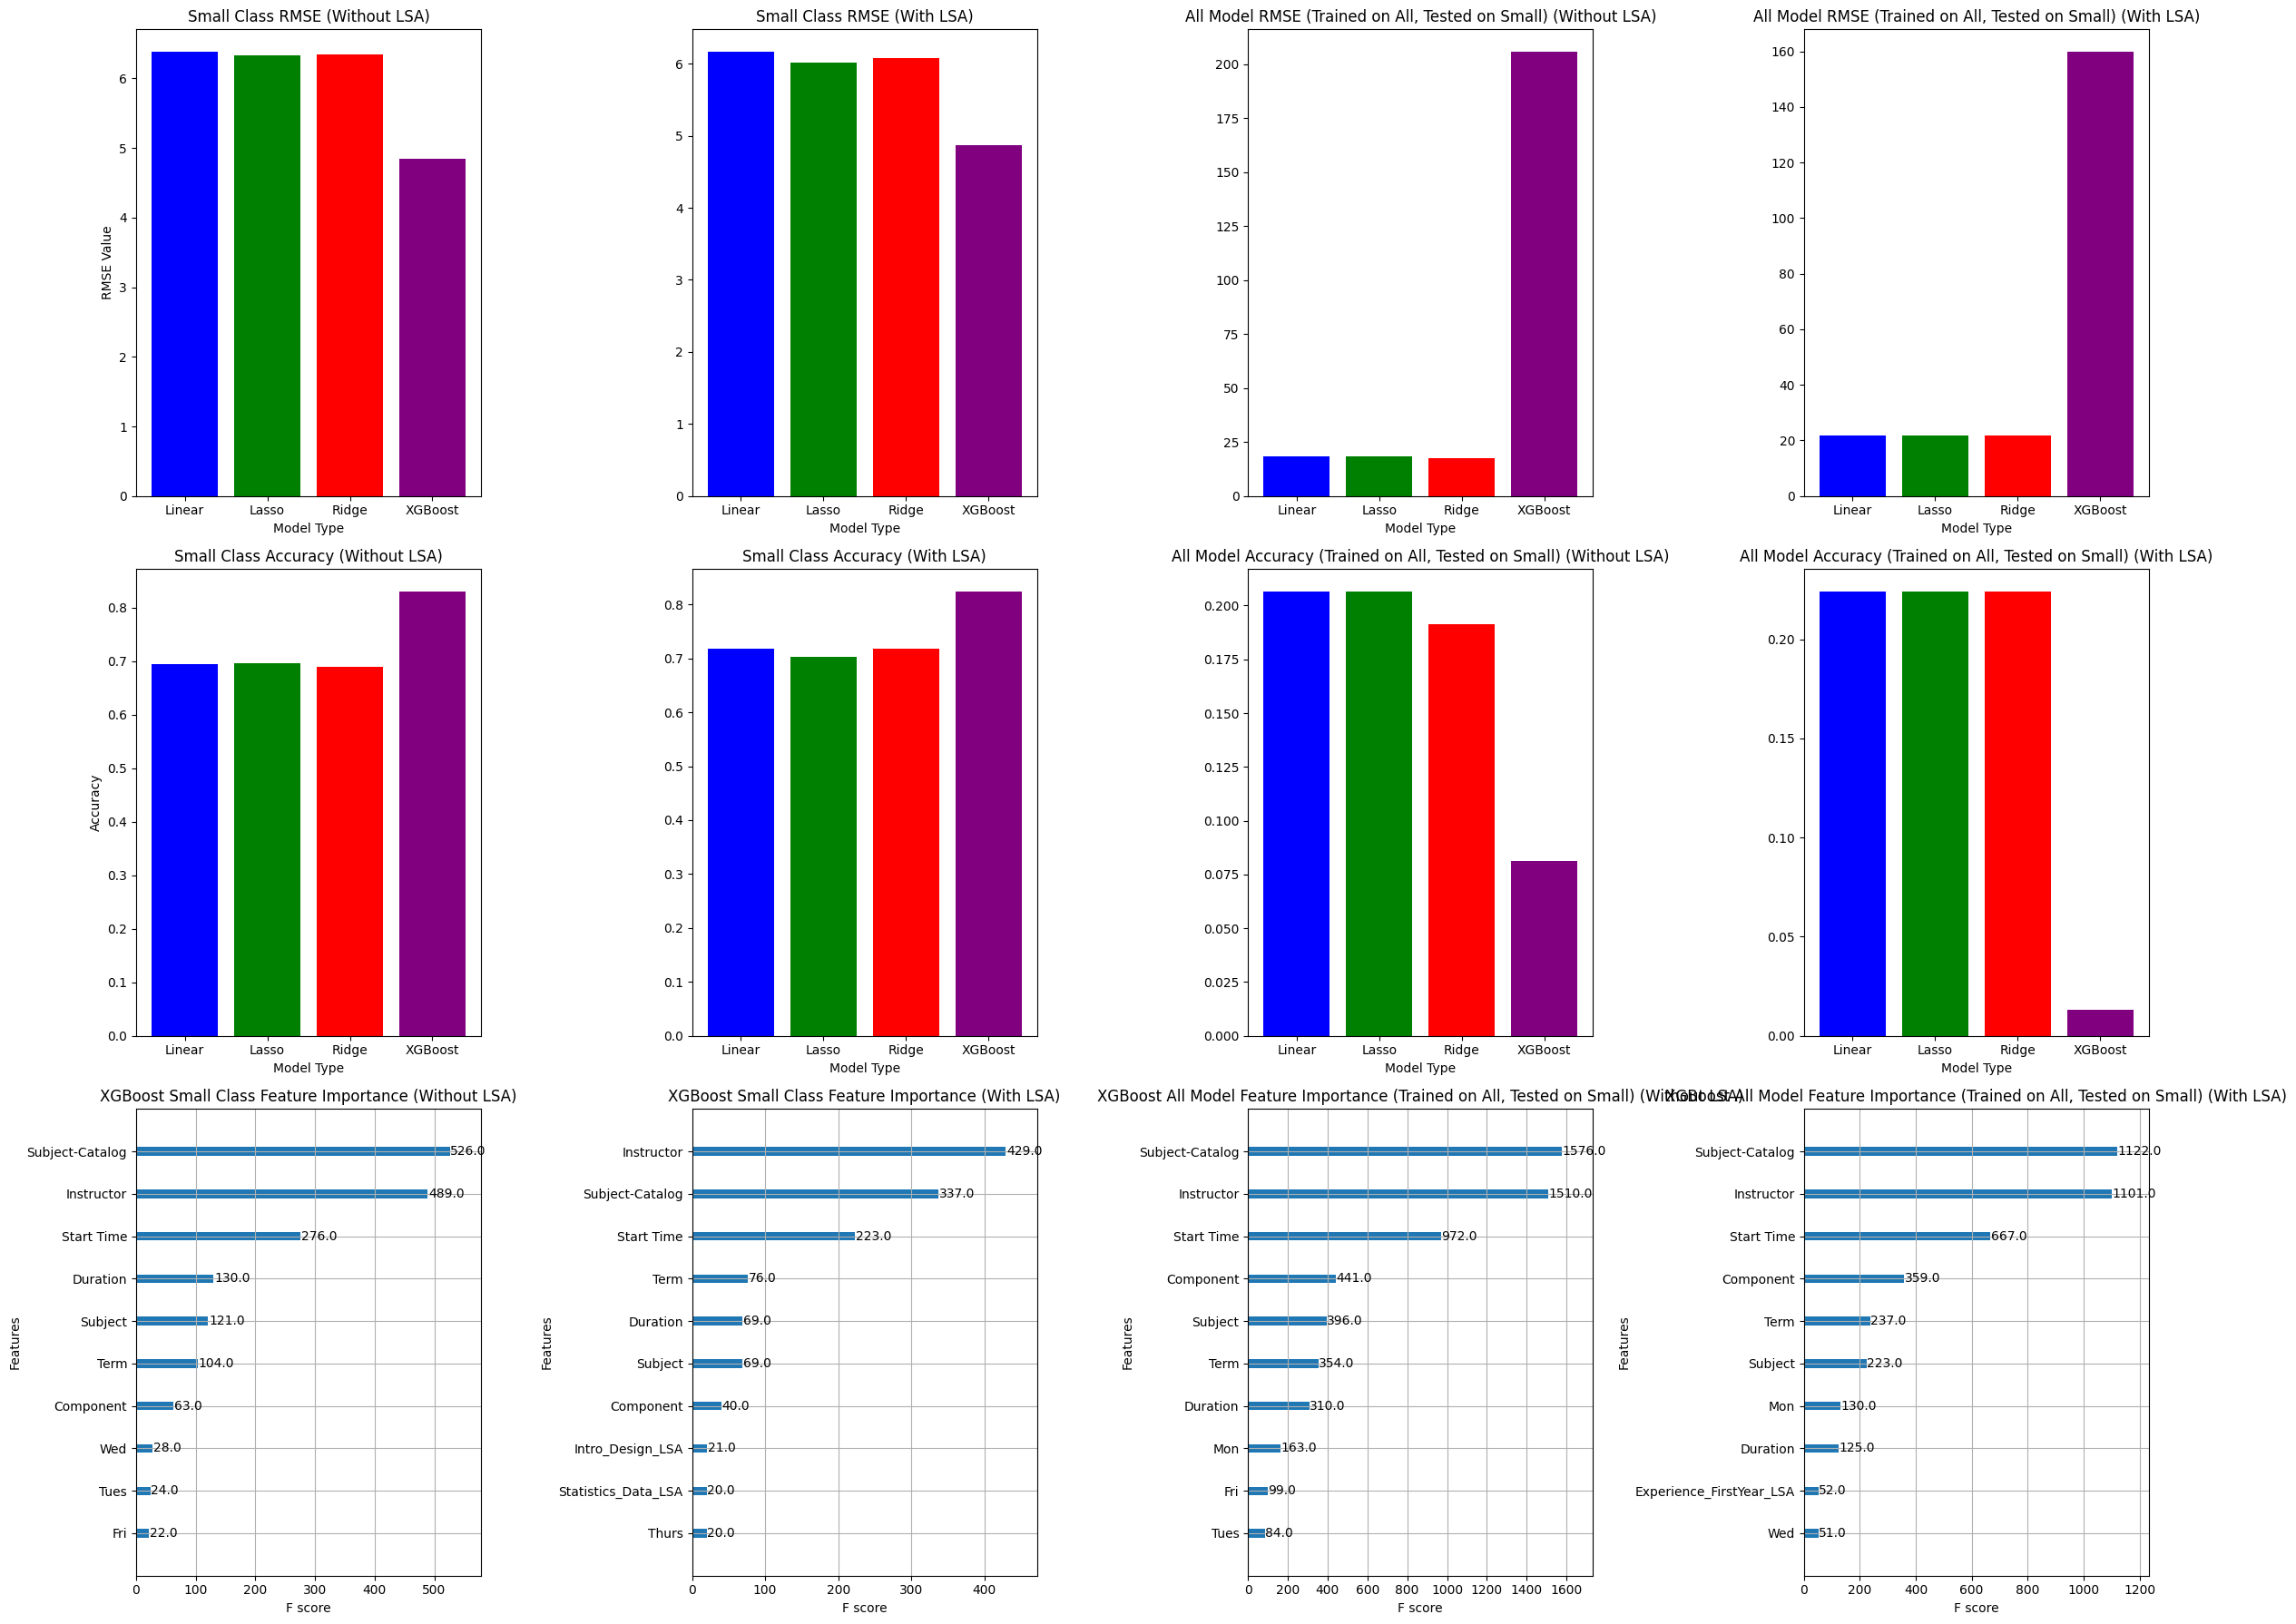

In [33]:
from xgboost import plot_importance

# Fetch the 'Enrollment Capacity' for the test indices to use as naive predictions
naive_predictions_enrollment_capacity_small = df_new.loc[y_small_test, 'Enrollment Capacity']

# Calculate RMSE for these naive predictions
naive_rmse_small = np.sqrt(mean_squared_error(y_small_test_actual, naive_predictions_enrollment_capacity_small))
print(f"Naive RMSE when predicting 'Enrollment Capacity' for small class size as the mean: {naive_rmse_small}")

# Calculate the mean of 'Total Enrollment' for small class size
mean_total_enrollment_small = small_class_df['Total Enrollment'].mean()
print(f"Mean of 'Total Enrollment' for small class size: {mean_total_enrollment_small}")

# Assume a naive prediction where every prediction equals the mean of 'Total Enrollment' for the small class size
naive_predictions_total_enrollment_small = np.full(y_small_test.shape, mean_total_enrollment_small)

# Calculate RMSE for these naive predictions
naive_rmse_total_enrollment_small = np.sqrt(mean_squared_error(y_small_test_actual, naive_predictions_total_enrollment_small))
print(f"Naive RMSE when predicting 'Total Enrollment' for small class size as the mean: {naive_rmse_total_enrollment_small}")

# Calculate the standard deviation for 'Total Enrollment' in small classes
std_deviation_small = small_class_df['Total Enrollment'].std()

# Calculate RMSE for models trained on all data
linear_train_rmse_all_no_lsa, linear_test_rmse_all_no_lsa = calculate_rmse(
    linear_model_all_no_lsa, X_small_train_no_lsa_scaled, y_small_train, X_small_test_no_lsa_scaled, y_small_test_actual)
lasso_train_rmse_all_no_lsa, lasso_test_rmse_all_no_lsa = calculate_rmse(
    lasso_model_all_no_lsa, X_small_train_no_lsa_scaled, y_small_train, X_small_test_no_lsa_scaled, y_small_test_actual)
ridge_train_rmse_all_no_lsa, ridge_test_rmse_all_no_lsa = calculate_rmse(
    ridge_model_all_no_lsa, X_small_train_no_lsa_scaled, y_small_train, X_small_test_no_lsa_scaled, y_small_test_actual)
xgboost_train_rmse_all_no_lsa, xgboost_test_rmse_all_no_lsa = calculate_rmse(
    xgboost_model_all_no_lsa, X_small_train_no_lsa_scaled, y_small_train, X_small_test_no_lsa_scaled, y_small_test_actual)

linear_train_rmse_all_lsa, linear_test_rmse_all_lsa = calculate_rmse(
    linear_model_all_lsa, X_small_train_lsa_scaled, y_small_train, X_small_test_lsa_scaled, y_small_test_actual)
lasso_train_rmse_all_lsa, lasso_test_rmse_all_lsa = calculate_rmse(
    lasso_model_all_lsa, X_small_train_lsa_scaled, y_small_train, X_small_test_lsa_scaled, y_small_test_actual)
ridge_train_rmse_all_lsa, ridge_test_rmse_all_lsa = calculate_rmse(
    ridge_model_all_lsa, X_small_train_lsa_scaled, y_small_train, X_small_test_lsa_scaled, y_small_test_actual)
xgboost_train_rmse_all_lsa, xgboost_test_rmse_all_lsa = calculate_rmse(
    xgboost_model_all_lsa, X_small_train_lsa_scaled, y_small_train, X_small_test_lsa_scaled, y_small_test_actual)

# Calculate accuracy metrics for different models
linear_accuracy_small_no_lsa = accuracy_metric(y_small_test_actual, linear_y_pred_small_no_lsa, std_deviation_small)
lasso_accuracy_small_no_lsa = accuracy_metric(y_small_test_actual, lasso_y_pred_small_no_lsa, std_deviation_small)
ridge_accuracy_small_no_lsa = accuracy_metric(y_small_test_actual, ridge_y_pred_small_no_lsa, std_deviation_small)
xgboost_accuracy_small_no_lsa = accuracy_metric(y_small_test_actual, xgboost_predictions_small_no_lsa, std_deviation_small)
naive_accuracy_small_no_lsa = accuracy_metric(y_small_test_actual, naive_predictions_enrollment_capacity_small, std_deviation_small)

linear_accuracy_small_lsa = accuracy_metric(y_small_test_actual, linear_y_pred_small_lsa, std_deviation_small)
lasso_accuracy_small_lsa = accuracy_metric(y_small_test_actual, lasso_y_pred_small_lsa, std_deviation_small)
ridge_accuracy_small_lsa = accuracy_metric(y_small_test_actual, ridge_y_pred_small_lsa, std_deviation_small)
xgboost_accuracy_small_lsa = accuracy_metric(y_small_test_actual, xgboost_predictions_small_lsa, std_deviation_small)

linear_accuracy_all_no_lsa = accuracy_metric(y_small_test_actual, linear_model_all_no_lsa.predict(X_small_test_no_lsa_scaled), std_deviation_small)
lasso_accuracy_all_no_lsa = accuracy_metric(y_small_test_actual, lasso_model_all_no_lsa.predict(X_small_test_no_lsa_scaled), std_deviation_small)
ridge_accuracy_all_no_lsa = accuracy_metric(y_small_test_actual, ridge_model_all_no_lsa.predict(X_small_test_no_lsa_scaled), std_deviation_small)
xgboost_accuracy_all_no_lsa = accuracy_metric(y_small_test_actual, xgboost_model_all_no_lsa.predict(X_small_test_no_lsa_scaled), std_deviation_small)

linear_accuracy_all_lsa = accuracy_metric(y_small_test_actual, linear_model_all_lsa.predict(X_small_test_lsa_scaled), std_deviation_small)
lasso_accuracy_all_lsa = accuracy_metric(y_small_test_actual, lasso_model_all_lsa.predict(X_small_test_lsa_scaled), std_deviation_small)
ridge_accuracy_all_lsa = accuracy_metric(y_small_test_actual, ridge_model_all_lsa.predict(X_small_test_lsa_scaled), std_deviation_small)
xgboost_accuracy_all_lsa = accuracy_metric(y_small_test_actual, xgboost_model_all_lsa.predict(X_small_test_lsa_scaled), std_deviation_small)

# Print the RMSE and accuracy results
print("\nRMSE for Different Class Sizes Without LSA:")
print("Small Class RMSE - Linear:", linear_test_rmse_small_no_lsa, "Lasso:", lasso_test_rmse_small_no_lsa, "Ridge:", ridge_test_rmse_small_no_lsa, "XGBoost:", xgboost_test_rmse_small_no_lsa)
print("All Model (Trained on All, Tested on Small) RMSE - Linear:", linear_test_rmse_all_no_lsa, "Lasso:", lasso_test_rmse_all_no_lsa, "Ridge:", ridge_test_rmse_all_no_lsa, "XGBoost:", xgboost_test_rmse_all_no_lsa)

print("\nRMSE for Different Class Sizes With LSA:")
print("Small Class RMSE - Linear:", linear_test_rmse_small_lsa, "Lasso:", lasso_test_rmse_small_lsa, "Ridge:", ridge_test_rmse_small_lsa, "XGBoost:", xgboost_test_rmse_small_lsa)
print("All Model (Trained on All, Tested on Small) RMSE - Linear:", linear_test_rmse_all_lsa, "Lasso:", lasso_test_rmse_all_lsa, "Ridge:", ridge_test_rmse_all_lsa, "XGBoost:", xgboost_test_rmse_all_lsa)

print("\nAccuracy for Different Class Sizes Without LSA:")
print("Small Class Accuracy - Linear:", linear_accuracy_small_no_lsa, "Lasso:", lasso_accuracy_small_no_lsa, "Ridge:", ridge_accuracy_small_no_lsa, "XGBoost:", xgboost_accuracy_small_no_lsa)
print("All Model (Trained on All, Tested on Small) Accuracy - Linear:", linear_accuracy_all_no_lsa, "Lasso:", lasso_accuracy_all_no_lsa, "Ridge:", ridge_accuracy_all_no_lsa, "XGBoost:", xgboost_accuracy_all_no_lsa)

print("\nAccuracy for Different Class Sizes With LSA:")
print("Small Class Accuracy - Linear:", linear_accuracy_small_lsa, "Lasso:", lasso_accuracy_small_lsa, "Ridge:", ridge_accuracy_small_lsa, "XGBoost:", xgboost_accuracy_small_lsa)
print("All Model (Trained on All, Tested on Small) Accuracy - Linear:", linear_accuracy_all_lsa, "Lasso:", lasso_accuracy_all_lsa, "Ridge:", ridge_accuracy_all_lsa, "XGBoost:", xgboost_accuracy_all_lsa)

# Define model names
model_names = ['Linear', 'Lasso', 'Ridge', 'XGBoost']

# Define RMSE values
test_rmses_small_no_lsa = [linear_test_rmse_small_no_lsa, lasso_test_rmse_small_no_lsa, ridge_test_rmse_small_no_lsa, xgboost_test_rmse_small_no_lsa]
test_rmses_small_lsa = [linear_test_rmse_small_lsa, lasso_test_rmse_small_lsa, ridge_test_rmse_small_lsa, xgboost_test_rmse_small_lsa]
test_rmses_all_no_lsa = [linear_test_rmse_all_no_lsa, lasso_test_rmse_all_no_lsa, ridge_test_rmse_all_no_lsa, xgboost_test_rmse_all_no_lsa]
test_rmses_all_lsa = [linear_test_rmse_all_lsa, lasso_test_rmse_all_lsa, ridge_test_rmse_all_lsa, xgboost_test_rmse_all_lsa]

# Define accuracy values
accuracies_small_no_lsa = [linear_accuracy_small_no_lsa, lasso_accuracy_small_no_lsa, ridge_accuracy_small_no_lsa, xgboost_accuracy_small_no_lsa]
accuracies_small_lsa = [linear_accuracy_small_lsa, lasso_accuracy_small_lsa, ridge_accuracy_small_lsa, xgboost_accuracy_small_lsa]
accuracies_all_no_lsa = [linear_accuracy_all_no_lsa, lasso_accuracy_all_no_lsa, ridge_accuracy_all_no_lsa, xgboost_accuracy_all_no_lsa]
accuracies_all_lsa = [linear_accuracy_all_lsa, lasso_accuracy_all_lsa, ridge_accuracy_all_lsa, xgboost_accuracy_all_lsa]

# Plot RMSE values
fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey=False)

axes[0, 0].bar(model_names, test_rmses_small_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 0].set_xlabel('Model Type')
axes[0, 0].set_ylabel('RMSE Value')
axes[0, 0].set_title('Small Class RMSE (Without LSA)')

axes[0, 1].bar(model_names, test_rmses_small_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 1].set_xlabel('Model Type')
axes[0, 1].set_title('Small Class RMSE (With LSA)')

axes[0, 2].bar(model_names, test_rmses_all_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 2].set_xlabel('Model Type')
axes[0, 2].set_title('All Model RMSE (Trained on All, Tested on Small) (Without LSA)')

axes[0, 3].bar(model_names, test_rmses_all_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 3].set_xlabel('Model Type')
axes[0, 3].set_title('All Model RMSE (Trained on All, Tested on Small) (With LSA)')

# Plot accuracy values
axes[1, 0].bar(model_names, accuracies_small_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 0].set_xlabel('Model Type')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Small Class Accuracy (Without LSA)')

axes[1, 1].bar(model_names, accuracies_small_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 1].set_xlabel('Model Type')
axes[1, 1].set_title('Small Class Accuracy (With LSA)')

axes[1, 2].bar(model_names, accuracies_all_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 2].set_xlabel('Model Type')
axes[1, 2].set_title('All Model Accuracy (Trained on All, Tested on Small) (Without LSA)')

axes[1, 3].bar(model_names, accuracies_all_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 3].set_xlabel('Model Type')
axes[1, 3].set_title('All Model Accuracy (Trained on All, Tested on Small) (With LSA)')

# Plot XGBoost feature importance
plot_importance(xgboost_model_small_no_lsa, ax=axes[2, 0], max_num_features=10, importance_type='weight')
axes[2, 0].set_title('XGBoost Small Class Feature Importance (Without LSA)')

plot_importance(xgboost_model_small_lsa, ax=axes[2, 1], max_num_features=10, importance_type='weight')
axes[2, 1].set_title('XGBoost Small Class Feature Importance (With LSA)')

plot_importance(xgboost_model_all_no_lsa, ax=axes[2, 2], max_num_features=10, importance_type='weight')
axes[2, 2].set_title('XGBoost All Model Feature Importance (Trained on All, Tested on Small) (Without LSA)')

plot_importance(xgboost_model_all_lsa, ax=axes[2, 3], max_num_features=10, importance_type='weight')
axes[2, 3].set_title('XGBoost All Model Feature Importance (Trained on All, Tested on Small) (With LSA)')

plt.tight_layout()
plt.show()

#### Medium-Classes

Naive RMSE when predicting 'Enrollment Capacity' for medium class size as the mean: 14.845111200834564
Mean of 'Total Enrollment' for medium class size: 29.055024481231055
Naive RMSE when predicting 'Total Enrollment' for medium class size as the mean: 14.225111886014107

RMSE for Different Class Sizes Without LSA:
Medium Class RMSE - Linear: 14.388273876592947 Lasso: 14.227505550066455 Ridge: 14.296410885605237 XGBoost: 10.64004708554542
All Model (Trained on All, Tested on Medium) RMSE - Linear: 16.57563248122441 Lasso: 16.422686900509568 Ridge: 16.058655942210915 XGBoost: 174.48456249342846

RMSE for Different Class Sizes With LSA:
Medium Class RMSE - Linear: 13.069989330351113 Lasso: 13.03877464497065 Ridge: 12.958811828635378 XGBoost: 10.636366585570482
All Model (Trained on All, Tested on Medium) RMSE - Linear: 18.0188254652387 Lasso: 18.01428501357323 Ridge: 18.018823540389906 XGBoost: 133.52174857833708

Accuracy for Different Class Sizes Without LSA:
Medium Class Accuracy - Li

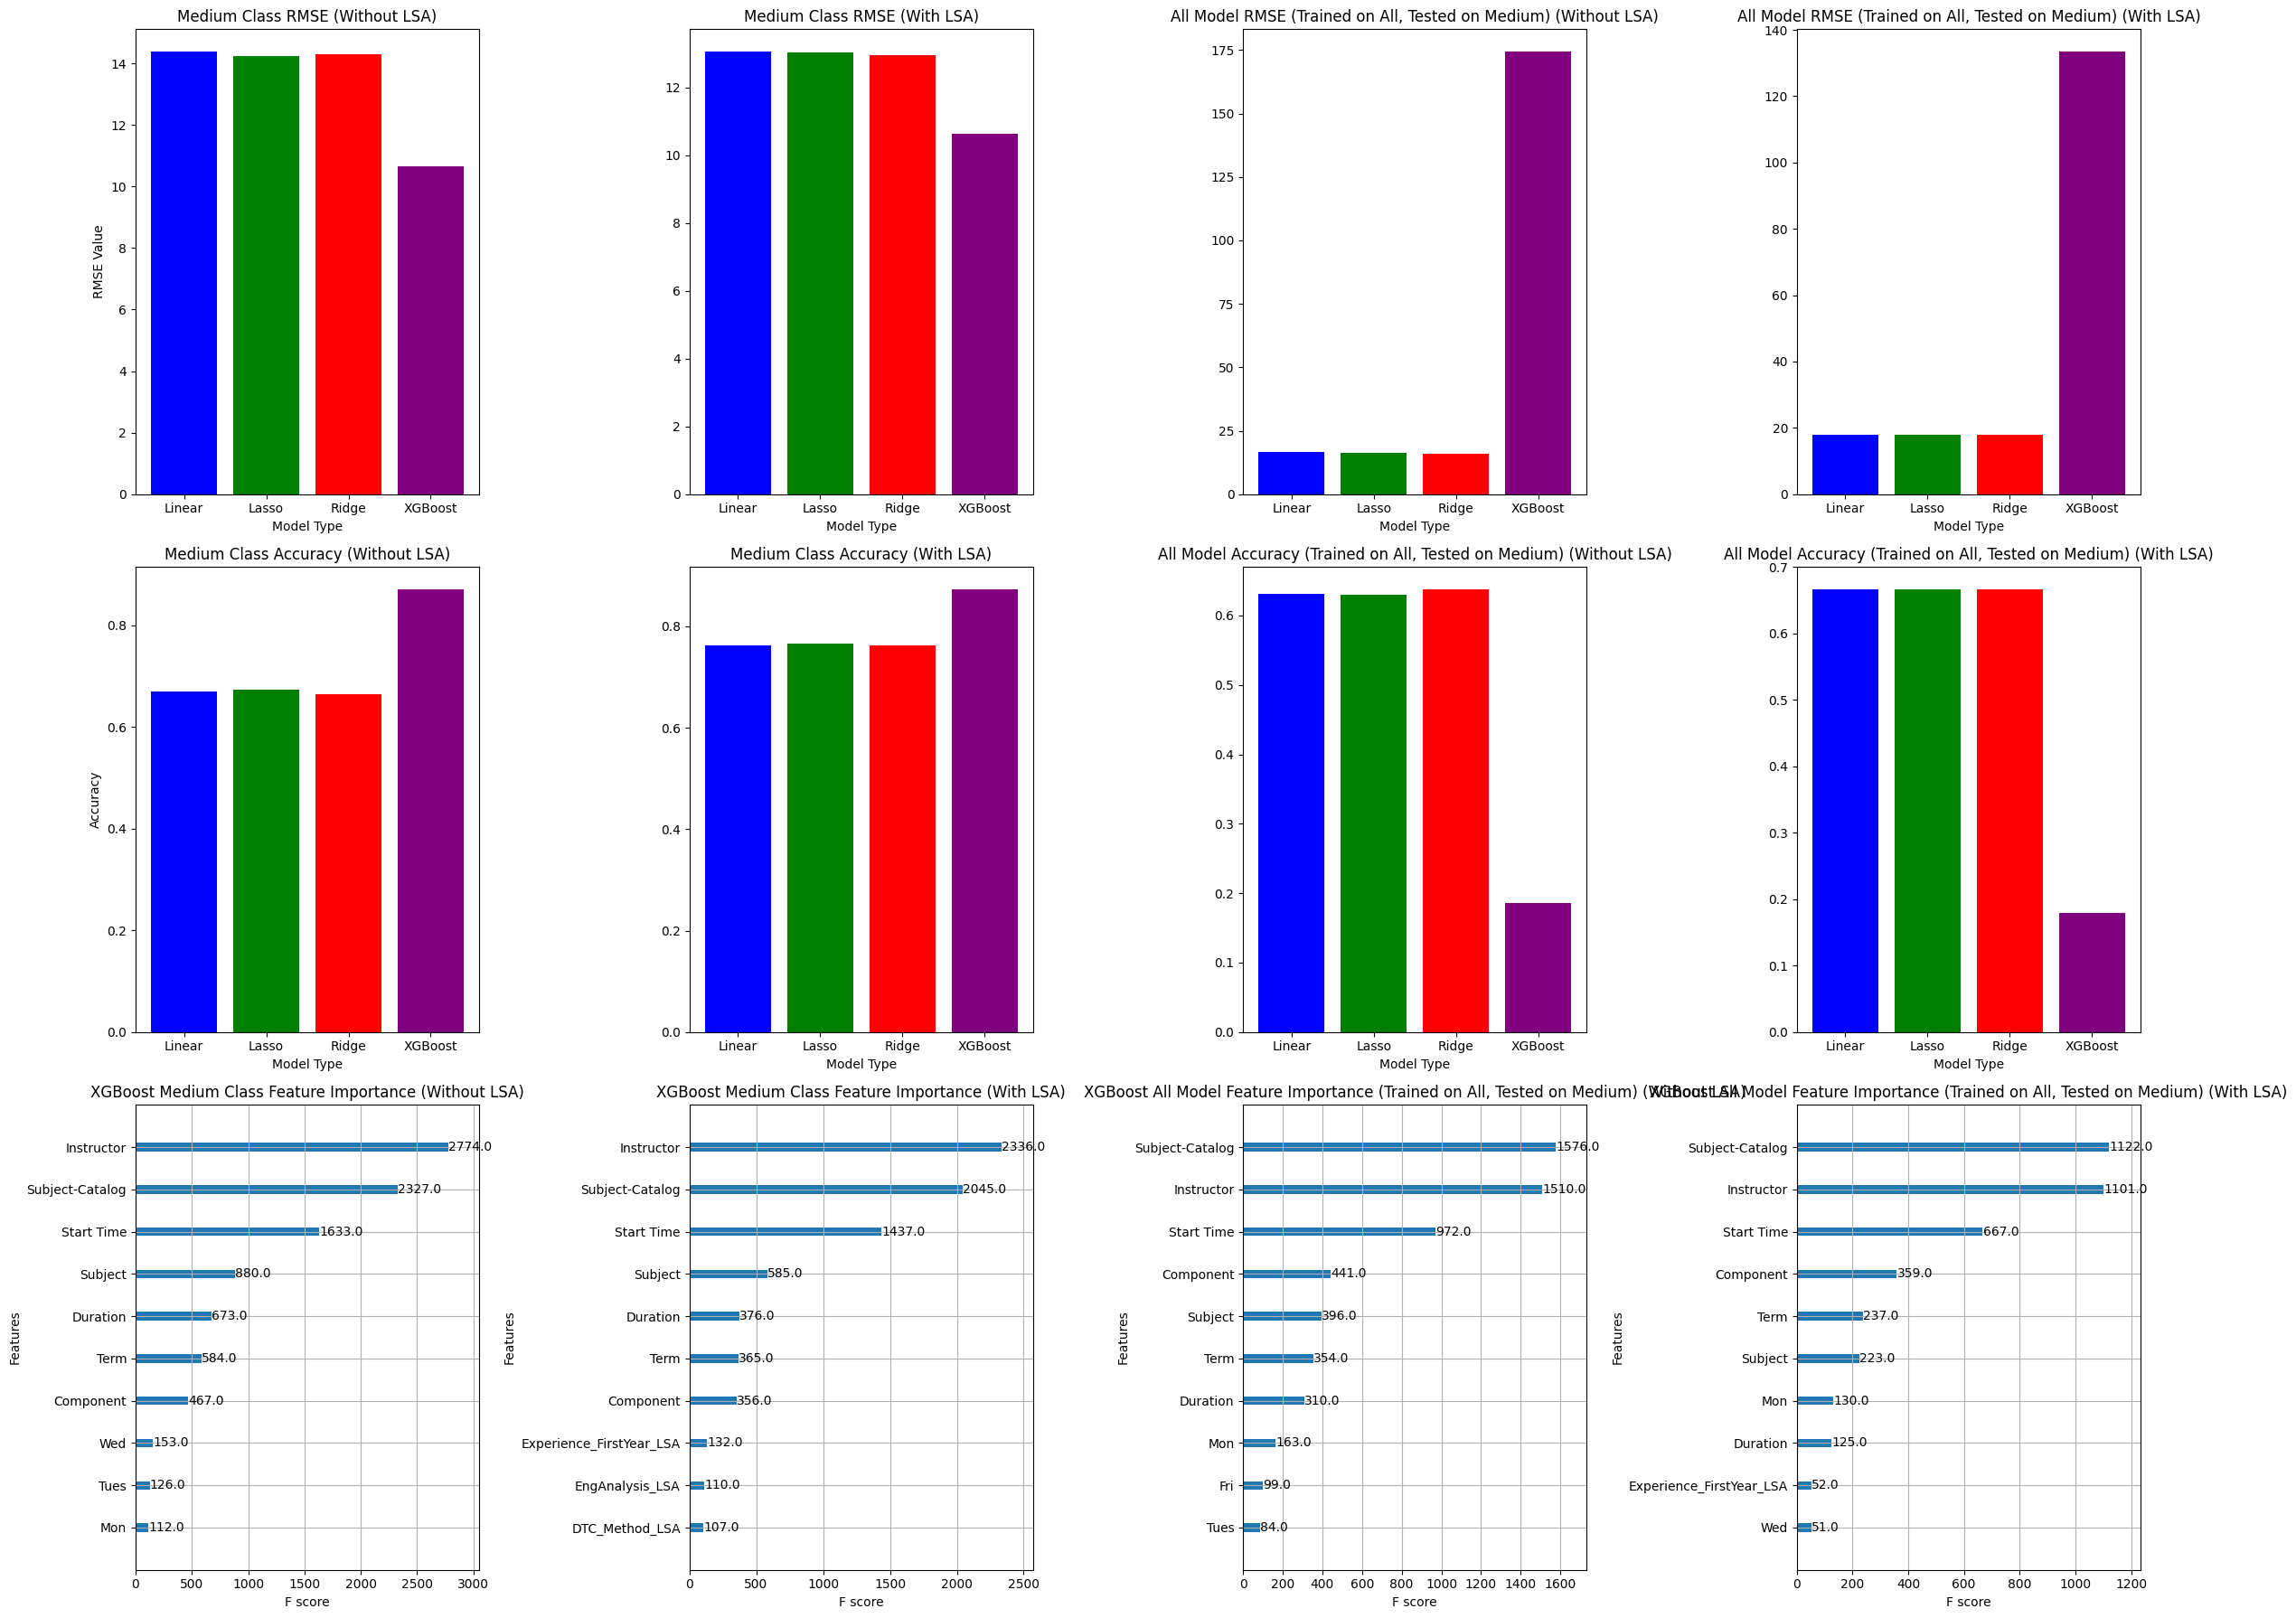

In [69]:
# Fetch the 'Enrollment Capacity' for the test indices to use as naive predictions
naive_predictions_enrollment_capacity_medium = df_new.loc[y_medium_test, 'Enrollment Capacity']

# Calculate RMSE for these naive predictions
naive_rmse_medium = np.sqrt(mean_squared_error(y_medium_test_actual, naive_predictions_enrollment_capacity_medium))
print(f"Naive RMSE when predicting 'Enrollment Capacity' for medium class size as the mean: {naive_rmse_medium}")

# Calculate the mean of 'Total Enrollment' for medium class size
mean_total_enrollment_medium = medium_class_df['Total Enrollment'].mean()
print(f"Mean of 'Total Enrollment' for medium class size: {mean_total_enrollment_medium}")

# Assume a naive prediction where every prediction equals the mean of 'Total Enrollment' for the medium class size
naive_predictions_total_enrollment_medium = np.full(y_medium_test.shape, mean_total_enrollment_medium)

# Calculate RMSE for these naive predictions
naive_rmse_total_enrollment_medium = np.sqrt(mean_squared_error(y_medium_test_actual, naive_predictions_total_enrollment_medium))
print(f"Naive RMSE when predicting 'Total Enrollment' for medium class size as the mean: {naive_rmse_total_enrollment_medium}")

# Calculate the standard deviation for 'Total Enrollment' in medium classes
std_deviation_medium = medium_class_df['Total Enrollment'].std()

# Calculate RMSE for models trained on all data
linear_train_rmse_all_no_lsa, linear_test_rmse_all_no_lsa = calculate_rmse(
    linear_model_all_no_lsa, X_medium_train_no_lsa_scaled, y_medium_train, X_medium_test_no_lsa_scaled, y_medium_test_actual)
lasso_train_rmse_all_no_lsa, lasso_test_rmse_all_no_lsa = calculate_rmse(
    lasso_model_all_no_lsa, X_medium_train_no_lsa_scaled, y_medium_train, X_medium_test_no_lsa_scaled, y_medium_test_actual)
ridge_train_rmse_all_no_lsa, ridge_test_rmse_all_no_lsa = calculate_rmse(
    ridge_model_all_no_lsa, X_medium_train_no_lsa_scaled, y_medium_train, X_medium_test_no_lsa_scaled, y_medium_test_actual)
xgboost_train_rmse_all_no_lsa, xgboost_test_rmse_all_no_lsa = calculate_rmse(
    xgboost_model_all_no_lsa, X_medium_train_no_lsa_scaled, y_medium_train, X_medium_test_no_lsa_scaled, y_medium_test_actual)

linear_train_rmse_all_lsa, linear_test_rmse_all_lsa = calculate_rmse(
    linear_model_all_lsa, X_medium_train_lsa_scaled, y_medium_train, X_medium_test_lsa_scaled, y_medium_test_actual)
lasso_train_rmse_all_lsa, lasso_test_rmse_all_lsa = calculate_rmse(
    lasso_model_all_lsa, X_medium_train_lsa_scaled, y_medium_train, X_medium_test_lsa_scaled, y_medium_test_actual)
ridge_train_rmse_all_lsa, ridge_test_rmse_all_lsa = calculate_rmse(
    ridge_model_all_lsa, X_medium_train_lsa_scaled, y_medium_train, X_medium_test_lsa_scaled, y_medium_test_actual)
xgboost_train_rmse_all_lsa, xgboost_test_rmse_all_lsa = calculate_rmse(
    xgboost_model_all_lsa, X_medium_train_lsa_scaled, y_medium_train, X_medium_test_lsa_scaled, y_medium_test_actual)

# Calculate accuracy metrics for different models
linear_accuracy_medium_no_lsa = accuracy_metric(y_medium_test_actual, linear_y_pred_medium_no_lsa, std_deviation_medium)
lasso_accuracy_medium_no_lsa = accuracy_metric(y_medium_test_actual, lasso_y_pred_medium_no_lsa, std_deviation_medium)
ridge_accuracy_medium_no_lsa = accuracy_metric(y_medium_test_actual, ridge_y_pred_medium_no_lsa, std_deviation_medium)
xgboost_accuracy_medium_no_lsa = accuracy_metric(y_medium_test_actual, xgboost_predictions_medium_no_lsa, std_deviation_medium)
naive_accuracy_medium_no_lsa = accuracy_metric(y_medium_test_actual, naive_predictions_total_enrollment_medium, std_deviation_medium)

linear_accuracy_medium_lsa = accuracy_metric(y_medium_test_actual, linear_y_pred_medium_lsa, std_deviation_medium)
lasso_accuracy_medium_lsa = accuracy_metric(y_medium_test_actual, lasso_y_pred_medium_lsa, std_deviation_medium)
ridge_accuracy_medium_lsa = accuracy_metric(y_medium_test_actual, ridge_y_pred_medium_lsa, std_deviation_medium)
xgboost_accuracy_medium_lsa = accuracy_metric(y_medium_test_actual, xgboost_predictions_medium_lsa, std_deviation_medium)

linear_accuracy_all_no_lsa = accuracy_metric(y_medium_test_actual, linear_model_all_no_lsa.predict(X_medium_test_no_lsa_scaled), std_deviation_medium)
lasso_accuracy_all_no_lsa = accuracy_metric(y_medium_test_actual, lasso_model_all_no_lsa.predict(X_medium_test_no_lsa_scaled), std_deviation_medium)
ridge_accuracy_all_no_lsa = accuracy_metric(y_medium_test_actual, ridge_model_all_no_lsa.predict(X_medium_test_no_lsa_scaled), std_deviation_medium)
xgboost_accuracy_all_no_lsa = accuracy_metric(y_medium_test_actual, xgboost_model_all_no_lsa.predict(X_medium_test_no_lsa_scaled), std_deviation_medium)

linear_accuracy_all_lsa = accuracy_metric(y_medium_test_actual, linear_model_all_lsa.predict(X_medium_test_lsa_scaled), std_deviation_medium)
lasso_accuracy_all_lsa = accuracy_metric(y_medium_test_actual, lasso_model_all_lsa.predict(X_medium_test_lsa_scaled), std_deviation_medium)
ridge_accuracy_all_lsa = accuracy_metric(y_medium_test_actual, ridge_model_all_lsa.predict(X_medium_test_lsa_scaled), std_deviation_medium)
xgboost_accuracy_all_lsa = accuracy_metric(y_medium_test_actual, xgboost_model_all_lsa.predict(X_medium_test_lsa_scaled), std_deviation_medium)

# Print the RMSE and accuracy results
print("\nRMSE for Different Class Sizes Without LSA:")
print("Medium Class RMSE - Linear:", linear_test_rmse_medium_no_lsa, "Lasso:", lasso_test_rmse_medium_no_lsa, "Ridge:", ridge_test_rmse_medium_no_lsa, "XGBoost:", xgboost_test_rmse_medium_no_lsa)
print("All Model (Trained on All, Tested on Medium) RMSE - Linear:", linear_test_rmse_all_no_lsa, "Lasso:", lasso_test_rmse_all_no_lsa, "Ridge:", ridge_test_rmse_all_no_lsa, "XGBoost:", xgboost_test_rmse_all_no_lsa)

print("\nRMSE for Different Class Sizes With LSA:")
print("Medium Class RMSE - Linear:", linear_test_rmse_medium_lsa, "Lasso:", lasso_test_rmse_medium_lsa, "Ridge:", ridge_test_rmse_medium_lsa, "XGBoost:", xgboost_test_rmse_medium_lsa)
print("All Model (Trained on All, Tested on Medium) RMSE - Linear:", linear_test_rmse_all_lsa, "Lasso:", lasso_test_rmse_all_lsa, "Ridge:", ridge_test_rmse_all_lsa, "XGBoost:", xgboost_test_rmse_all_lsa)

print("\nAccuracy for Different Class Sizes Without LSA:")
print("Medium Class Accuracy - Linear:", linear_accuracy_medium_no_lsa, "Lasso:", lasso_accuracy_medium_no_lsa, "Ridge:", ridge_accuracy_medium_no_lsa, "XGBoost:", xgboost_accuracy_medium_no_lsa)
print("All Model (Trained on All, Tested on Medium) Accuracy - Linear:", linear_accuracy_all_no_lsa, "Lasso:", lasso_accuracy_all_no_lsa, "Ridge:", ridge_accuracy_all_no_lsa, "XGBoost:", xgboost_accuracy_all_no_lsa)

print("\nAccuracy for Different Class Sizes With LSA:")
print("Medium Class Accuracy - Linear:", linear_accuracy_medium_lsa, "Lasso:", lasso_accuracy_medium_lsa, "Ridge:", ridge_accuracy_medium_lsa, "XGBoost:", xgboost_accuracy_medium_lsa)
print("All Model (Trained on All, Tested on Medium) Accuracy - Linear:", linear_accuracy_all_lsa, "Lasso:", lasso_accuracy_all_lsa, "Ridge:", ridge_accuracy_all_lsa, "XGBoost:", xgboost_accuracy_all_lsa)

# Define model names
model_names = ['Linear', 'Lasso', 'Ridge', 'XGBoost']

# Define RMSE values
test_rmses_medium_no_lsa = [linear_test_rmse_medium_no_lsa, lasso_test_rmse_medium_no_lsa, ridge_test_rmse_medium_no_lsa, xgboost_test_rmse_medium_no_lsa]
test_rmses_medium_lsa = [linear_test_rmse_medium_lsa, lasso_test_rmse_medium_lsa, ridge_test_rmse_medium_lsa, xgboost_test_rmse_medium_lsa]
test_rmses_all_no_lsa = [linear_test_rmse_all_no_lsa, lasso_test_rmse_all_no_lsa, ridge_test_rmse_all_no_lsa, xgboost_test_rmse_all_no_lsa]
test_rmses_all_lsa = [linear_test_rmse_all_lsa, lasso_test_rmse_all_lsa, ridge_test_rmse_all_lsa, xgboost_test_rmse_all_lsa]

# Define accuracy values
accuracies_medium_no_lsa = [linear_accuracy_medium_no_lsa, lasso_accuracy_medium_no_lsa, ridge_accuracy_medium_no_lsa, xgboost_accuracy_medium_no_lsa]
accuracies_medium_lsa = [linear_accuracy_medium_lsa, lasso_accuracy_medium_lsa, ridge_accuracy_medium_lsa, xgboost_accuracy_medium_lsa]
accuracies_all_no_lsa = [linear_accuracy_all_no_lsa, lasso_accuracy_all_no_lsa, ridge_accuracy_all_no_lsa, xgboost_accuracy_all_no_lsa]
accuracies_all_lsa = [linear_accuracy_all_lsa, lasso_accuracy_all_lsa, ridge_accuracy_all_lsa, xgboost_accuracy_all_lsa]

# Plot RMSE values
fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey=False)

axes[0, 0].bar(model_names, test_rmses_medium_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 0].set_xlabel('Model Type')
axes[0, 0].set_ylabel('RMSE Value')
axes[0, 0].set_title('Medium Class RMSE (Without LSA)')

axes[0, 1].bar(model_names, test_rmses_medium_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 1].set_xlabel('Model Type')
axes[0, 1].set_title('Medium Class RMSE (With LSA)')

axes[0, 2].bar(model_names, test_rmses_all_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 2].set_xlabel('Model Type')
axes[0, 2].set_title('All Model RMSE (Trained on All, Tested on Medium) (Without LSA)')

axes[0, 3].bar(model_names, test_rmses_all_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 3].set_xlabel('Model Type')
axes[0, 3].set_title('All Model RMSE (Trained on All, Tested on Medium) (With LSA)')

# Plot accuracy values
axes[1, 0].bar(model_names, accuracies_medium_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 0].set_xlabel('Model Type')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Medium Class Accuracy (Without LSA)')

axes[1, 1].bar(model_names, accuracies_medium_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 1].set_xlabel('Model Type')
axes[1, 1].set_title('Medium Class Accuracy (With LSA)')

axes[1, 2].bar(model_names, accuracies_all_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 2].set_xlabel('Model Type')
axes[1, 2].set_title('All Model Accuracy (Trained on All, Tested on Medium) (Without LSA)')

axes[1, 3].bar(model_names, accuracies_all_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 3].set_xlabel('Model Type')
axes[1, 3].set_title('All Model Accuracy (Trained on All, Tested on Medium) (With LSA)')

# Plot XGBoost feature importance
plot_importance(xgboost_model_medium_no_lsa, ax=axes[2, 0], max_num_features=10, importance_type='weight')
axes[2, 0].set_title('XGBoost Medium Class Feature Importance (Without LSA)')

plot_importance(xgboost_model_medium_lsa, ax=axes[2, 1], max_num_features=10, importance_type='weight')
axes[2, 1].set_title('XGBoost Medium Class Feature Importance (With LSA)')

plot_importance(xgboost_model_all_no_lsa, ax=axes[2, 2], max_num_features=10, importance_type='weight')
axes[2, 2].set_title('XGBoost All Model Feature Importance (Trained on All, Tested on Medium) (Without LSA)')

plot_importance(xgboost_model_all_lsa, ax=axes[2, 3], max_num_features=10, importance_type='weight')
axes[2, 3].set_title('XGBoost All Model Feature Importance (Trained on All, Tested on Medium) (With LSA)')

plt.tight_layout()
plt.show()

#### Large-Classes

Naive RMSE when predicting 'Enrollment Capacity' for large class size as the mean: 51.84164630285894
Mean of 'Total Enrollment' for large class size: 87.38326848249027
Naive RMSE when predicting 'Total Enrollment' for large class size as the mean: 56.64527617282399

RMSE for Different Class Sizes Without LSA:
Large Class RMSE - Linear: 60.55655067566401 Lasso: 59.185507324135955 Ridge: 60.396018089704654 XGBoost: 38.301051583055255
All Model (Trained on All, Tested on Large) RMSE - Linear: 86.01537320549767 Lasso: 85.96312859986574 Ridge: 85.82756427442115 XGBoost: 159.1603004553125

RMSE for Different Class Sizes With LSA:
Large Class RMSE - Linear: 74.00100619450524 Lasso: 59.67849734823417 Ridge: 58.324604349275 XGBoost: 38.726858149977055
All Model (Trained on All, Tested on Large) RMSE - Linear: 85.12344292337471 Lasso: 85.12220087002194 Ridge: 85.12344254709564 XGBoost: 110.0405402522438

Accuracy for Different Class Sizes Without LSA:
Large Class Accuracy - Linear: 0.70860927152

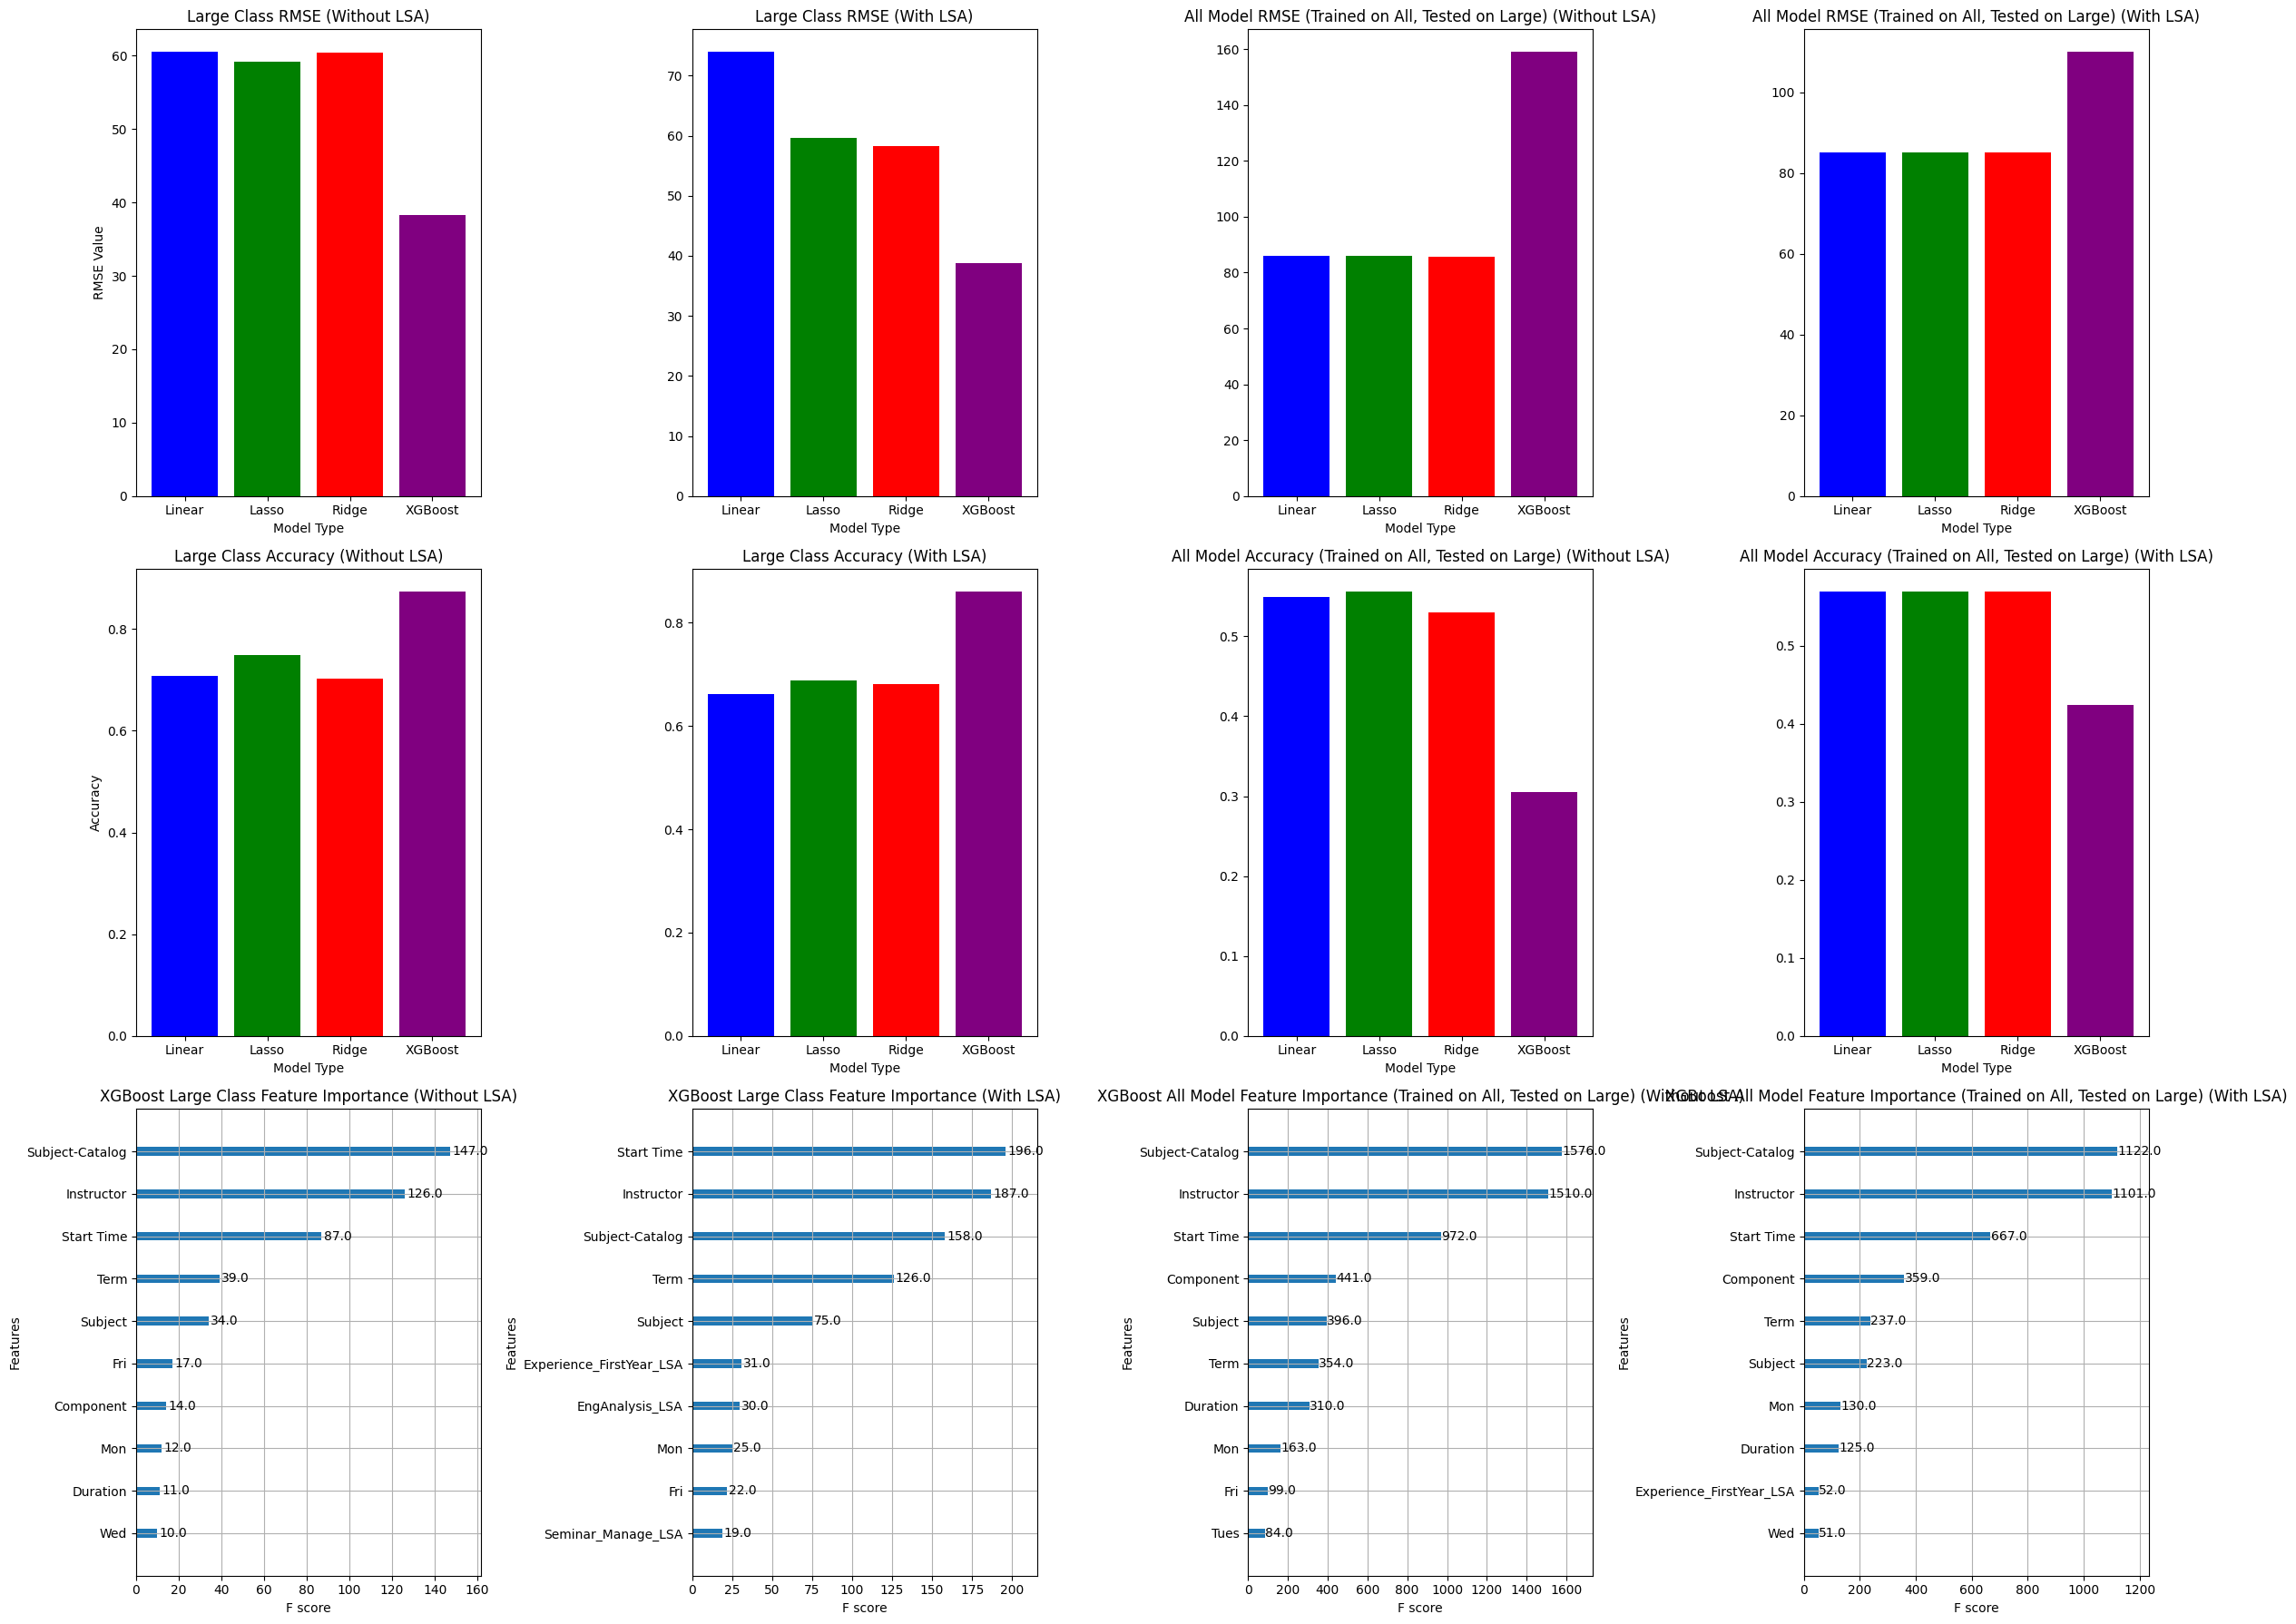

In [71]:
# Fetch the 'Enrollment Capacity' for the test indices to use as naive predictions
naive_predictions_enrollment_capacity_large = df_new.loc[y_large_test, 'Enrollment Capacity']

# Calculate RMSE for these naive predictions
naive_rmse_large = np.sqrt(mean_squared_error(y_large_test_actual, naive_predictions_enrollment_capacity_large))
print(f"Naive RMSE when predicting 'Enrollment Capacity' for large class size as the mean: {naive_rmse_large}")

# Calculate the mean of 'Total Enrollment' for large class size
mean_total_enrollment_large = large_class_df['Total Enrollment'].mean()
print(f"Mean of 'Total Enrollment' for large class size: {mean_total_enrollment_large}")

# Assume a naive prediction where every prediction equals the mean of 'Total Enrollment' for the large class size
naive_predictions_total_enrollment_large = np.full(y_large_test.shape, mean_total_enrollment_large)

# Calculate RMSE for these naive predictions
naive_rmse_total_enrollment_large = np.sqrt(mean_squared_error(y_large_test_actual, naive_predictions_total_enrollment_large))
print(f"Naive RMSE when predicting 'Total Enrollment' for large class size as the mean: {naive_rmse_total_enrollment_large}")

# Calculate the standard deviation for 'Total Enrollment' in large classes
std_deviation_large = large_class_df['Total Enrollment'].std()

# Calculate RMSE for models trained on all data
linear_train_rmse_all_no_lsa, linear_test_rmse_all_no_lsa = calculate_rmse(
    linear_model_all_no_lsa, X_large_train_no_lsa_scaled, y_large_train, X_large_test_no_lsa_scaled, y_large_test_actual)
lasso_train_rmse_all_no_lsa, lasso_test_rmse_all_no_lsa = calculate_rmse(
    lasso_model_all_no_lsa, X_large_train_no_lsa_scaled, y_large_train, X_large_test_no_lsa_scaled, y_large_test_actual)
ridge_train_rmse_all_no_lsa, ridge_test_rmse_all_no_lsa = calculate_rmse(
    ridge_model_all_no_lsa, X_large_train_no_lsa_scaled, y_large_train, X_large_test_no_lsa_scaled, y_large_test_actual)
xgboost_train_rmse_all_no_lsa, xgboost_test_rmse_all_no_lsa = calculate_rmse(
    xgboost_model_all_no_lsa, X_large_train_no_lsa_scaled, y_large_train, X_large_test_no_lsa_scaled, y_large_test_actual)

linear_train_rmse_all_lsa, linear_test_rmse_all_lsa = calculate_rmse(
    linear_model_all_lsa, X_large_train_lsa_scaled, y_large_train, X_large_test_lsa_scaled, y_large_test_actual)
lasso_train_rmse_all_lsa, lasso_test_rmse_all_lsa = calculate_rmse(
    lasso_model_all_lsa, X_large_train_lsa_scaled, y_large_train, X_large_test_lsa_scaled, y_large_test_actual)
ridge_train_rmse_all_lsa, ridge_test_rmse_all_lsa = calculate_rmse(
    ridge_model_all_lsa, X_large_train_lsa_scaled, y_large_train, X_large_test_lsa_scaled, y_large_test_actual)
xgboost_train_rmse_all_lsa, xgboost_test_rmse_all_lsa = calculate_rmse(
    xgboost_model_all_lsa, X_large_train_lsa_scaled, y_large_train, X_large_test_lsa_scaled, y_large_test_actual)

# Calculate accuracy metrics for different models
linear_accuracy_large_no_lsa = accuracy_metric(y_large_test_actual, linear_y_pred_large_no_lsa, std_deviation_large)
lasso_accuracy_large_no_lsa = accuracy_metric(y_large_test_actual, lasso_y_pred_large_no_lsa, std_deviation_large)
ridge_accuracy_large_no_lsa = accuracy_metric(y_large_test_actual, ridge_y_pred_large_no_lsa, std_deviation_large)
xgboost_accuracy_large_no_lsa = accuracy_metric(y_large_test_actual, xgboost_predictions_large_no_lsa, std_deviation_large)
naive_accuracy_large_no_lsa = accuracy_metric(y_large_test_actual, naive_predictions_total_enrollment_large, std_deviation_large)

linear_accuracy_large_lsa = accuracy_metric(y_large_test_actual, linear_y_pred_large_lsa, std_deviation_large)
lasso_accuracy_large_lsa = accuracy_metric(y_large_test_actual, lasso_y_pred_large_lsa, std_deviation_large)
ridge_accuracy_large_lsa = accuracy_metric(y_large_test_actual, ridge_y_pred_large_lsa, std_deviation_large)
xgboost_accuracy_large_lsa = accuracy_metric(y_large_test_actual, xgboost_predictions_large_lsa, std_deviation_large)

linear_accuracy_all_no_lsa = accuracy_metric(y_large_test_actual, linear_model_all_no_lsa.predict(X_large_test_no_lsa_scaled), std_deviation_large)
lasso_accuracy_all_no_lsa = accuracy_metric(y_large_test_actual, lasso_model_all_no_lsa.predict(X_large_test_no_lsa_scaled), std_deviation_large)
ridge_accuracy_all_no_lsa = accuracy_metric(y_large_test_actual, ridge_model_all_no_lsa.predict(X_large_test_no_lsa_scaled), std_deviation_large)
xgboost_accuracy_all_no_lsa = accuracy_metric(y_large_test_actual, xgboost_model_all_no_lsa.predict(X_large_test_no_lsa_scaled), std_deviation_large)

linear_accuracy_all_lsa = accuracy_metric(y_large_test_actual, linear_model_all_lsa.predict(X_large_test_lsa_scaled), std_deviation_large)
lasso_accuracy_all_lsa = accuracy_metric(y_large_test_actual, lasso_model_all_lsa.predict(X_large_test_lsa_scaled), std_deviation_large)
ridge_accuracy_all_lsa = accuracy_metric(y_large_test_actual, ridge_model_all_lsa.predict(X_large_test_lsa_scaled), std_deviation_large)
xgboost_accuracy_all_lsa = accuracy_metric(y_large_test_actual, xgboost_model_all_lsa.predict(X_large_test_lsa_scaled), std_deviation_large)

# Print the RMSE and accuracy results
print("\nRMSE for Different Class Sizes Without LSA:")
print("Large Class RMSE - Linear:", linear_test_rmse_large_no_lsa, "Lasso:", lasso_test_rmse_large_no_lsa, "Ridge:", ridge_test_rmse_large_no_lsa, "XGBoost:", xgboost_test_rmse_large_no_lsa)
print("All Model (Trained on All, Tested on Large) RMSE - Linear:", linear_test_rmse_all_no_lsa, "Lasso:", lasso_test_rmse_all_no_lsa, "Ridge:", ridge_test_rmse_all_no_lsa, "XGBoost:", xgboost_test_rmse_all_no_lsa)

print("\nRMSE for Different Class Sizes With LSA:")
print("Large Class RMSE - Linear:", linear_test_rmse_large_lsa, "Lasso:", lasso_test_rmse_large_lsa, "Ridge:", ridge_test_rmse_large_lsa, "XGBoost:", xgboost_test_rmse_large_lsa)
print("All Model (Trained on All, Tested on Large) RMSE - Linear:", linear_test_rmse_all_lsa, "Lasso:", lasso_test_rmse_all_lsa, "Ridge:", ridge_test_rmse_all_lsa, "XGBoost:", xgboost_test_rmse_all_lsa)

print("\nAccuracy for Different Class Sizes Without LSA:")
print("Large Class Accuracy - Linear:", linear_accuracy_large_no_lsa, "Lasso:", lasso_accuracy_large_no_lsa, "Ridge:", ridge_accuracy_large_no_lsa, "XGBoost:", xgboost_accuracy_large_no_lsa)
print("All Model (Trained on All, Tested on Large) Accuracy - Linear:", linear_accuracy_all_no_lsa, "Lasso:", lasso_accuracy_all_no_lsa, "Ridge:", ridge_accuracy_all_no_lsa, "XGBoost:", xgboost_accuracy_all_no_lsa)

print("\nAccuracy for Different Class Sizes With LSA:")
print("Large Class Accuracy - Linear:", linear_accuracy_large_lsa, "Lasso:", lasso_accuracy_large_lsa, "Ridge:", ridge_accuracy_large_lsa, "XGBoost:", xgboost_accuracy_large_lsa)
print("All Model (Trained on All, Tested on Large) Accuracy - Linear:", linear_accuracy_all_lsa, "Lasso:", lasso_accuracy_all_lsa, "Ridge:", ridge_accuracy_all_lsa, "XGBoost:", xgboost_accuracy_all_lsa)

# Define model names
model_names = ['Linear', 'Lasso', 'Ridge', 'XGBoost']

# Define RMSE values
test_rmses_large_no_lsa = [linear_test_rmse_large_no_lsa, lasso_test_rmse_large_no_lsa, ridge_test_rmse_large_no_lsa, xgboost_test_rmse_large_no_lsa]
test_rmses_large_lsa = [linear_test_rmse_large_lsa, lasso_test_rmse_large_lsa, ridge_test_rmse_large_lsa, xgboost_test_rmse_large_lsa]
test_rmses_all_no_lsa = [linear_test_rmse_all_no_lsa, lasso_test_rmse_all_no_lsa, ridge_test_rmse_all_no_lsa, xgboost_test_rmse_all_no_lsa]
test_rmses_all_lsa = [linear_test_rmse_all_lsa, lasso_test_rmse_all_lsa, ridge_test_rmse_all_lsa, xgboost_test_rmse_all_lsa]

# Define accuracy values
accuracies_large_no_lsa = [linear_accuracy_large_no_lsa, lasso_accuracy_large_no_lsa, ridge_accuracy_large_no_lsa, xgboost_accuracy_large_no_lsa]
accuracies_large_lsa = [linear_accuracy_large_lsa, lasso_accuracy_large_lsa, ridge_accuracy_large_lsa, xgboost_accuracy_large_lsa]
accuracies_all_no_lsa = [linear_accuracy_all_no_lsa, lasso_accuracy_all_no_lsa, ridge_accuracy_all_no_lsa, xgboost_accuracy_all_no_lsa]
accuracies_all_lsa = [linear_accuracy_all_lsa, lasso_accuracy_all_lsa, ridge_accuracy_all_lsa, xgboost_accuracy_all_lsa]

# Plot RMSE values
fig, axes = plt.subplots(3, 4, figsize=(24, 18), sharey=False)

axes[0, 0].bar(model_names, test_rmses_large_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 0].set_xlabel('Model Type')
axes[0, 0].set_ylabel('RMSE Value')
axes[0, 0].set_title('Large Class RMSE (Without LSA)')

axes[0, 1].bar(model_names, test_rmses_large_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 1].set_xlabel('Model Type')
axes[0, 1].set_title('Large Class RMSE (With LSA)')

axes[0, 2].bar(model_names, test_rmses_all_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 2].set_xlabel('Model Type')
axes[0, 2].set_title('All Model RMSE (Trained on All, Tested on Large) (Without LSA)')

axes[0, 3].bar(model_names, test_rmses_all_lsa, color=['blue', 'green', 'red', 'purple'])
axes[0, 3].set_xlabel('Model Type')
axes[0, 3].set_title('All Model RMSE (Trained on All, Tested on Large) (With LSA)')

# Plot accuracy values
axes[1, 0].bar(model_names, accuracies_large_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 0].set_xlabel('Model Type')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Large Class Accuracy (Without LSA)')

axes[1, 1].bar(model_names, accuracies_large_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 1].set_xlabel('Model Type')
axes[1, 1].set_title('Large Class Accuracy (With LSA)')

axes[1, 2].bar(model_names, accuracies_all_no_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 2].set_xlabel('Model Type')
axes[1, 2].set_title('All Model Accuracy (Trained on All, Tested on Large) (Without LSA)')

axes[1, 3].bar(model_names, accuracies_all_lsa, color=['blue', 'green', 'red', 'purple'])
axes[1, 3].set_xlabel('Model Type')
axes[1, 3].set_title('All Model Accuracy (Trained on All, Tested on Large) (With LSA)')

# Plot XGBoost feature importance
plot_importance(xgboost_model_large_no_lsa, ax=axes[2, 0], max_num_features=10, importance_type='weight')
axes[2, 0].set_title('XGBoost Large Class Feature Importance (Without LSA)')

plot_importance(xgboost_model_large_lsa, ax=axes[2, 1], max_num_features=10, importance_type='weight')
axes[2, 1].set_title('XGBoost Large Class Feature Importance (With LSA)')

plot_importance(xgboost_model_all_no_lsa, ax=axes[2, 2], max_num_features=10, importance_type='weight')
axes[2, 2].set_title('XGBoost All Model Feature Importance (Trained on All, Tested on Large) (Without LSA)')

plot_importance(xgboost_model_all_lsa, ax=axes[2, 3], max_num_features=10, importance_type='weight')
axes[2, 3].set_title('XGBoost All Model Feature Importance (Trained on All, Tested on Large) (With LSA)')

plt.tight_layout()
plt.show()

### All Classes

Naive RMSE when predicting 'Enrollment Capacity' for all class size as the mean: 21.615806896098594
Mean of 'Total Enrollment' for all class size: 15.07416529830323
Naive RMSE when predicting 'Total Enrollment' for all class size as the mean: 37.283362151593465
Linear Regression Accuracy - All Model: 0.8253968253968254
Lasso Regression Accuracy - All Model: 0.8279030910609858
Ridge Regression Accuracy - All Model: 0.8529657477025898
XGBoost Accuracy: 0.9465329991645781
Naive Accuracy (Guessing Enrollment Capacity) - All: 0.9440267335004177
Standard Deviation of testing set: 31.134767194868687
Linear Regression Accuracy with LSA - All Model: 0.8713450292397661
Lasso Regression Accuracy with LSA - All Model: 0.8713450292397661
Ridge Regression Accuracy with LSA - All Model: 0.8713450292397661
XGBoost Accuracy with LSA - All Model: 0.9456975772765246
Naive Accuracy (Guessing Enrollment Capacity) with LSA - All Model: 0.9440267335004177


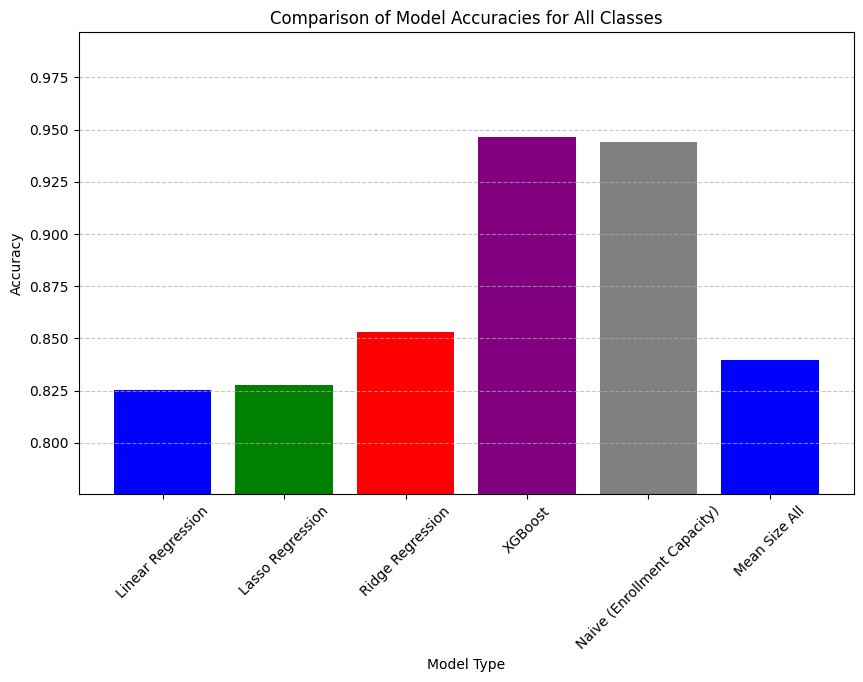

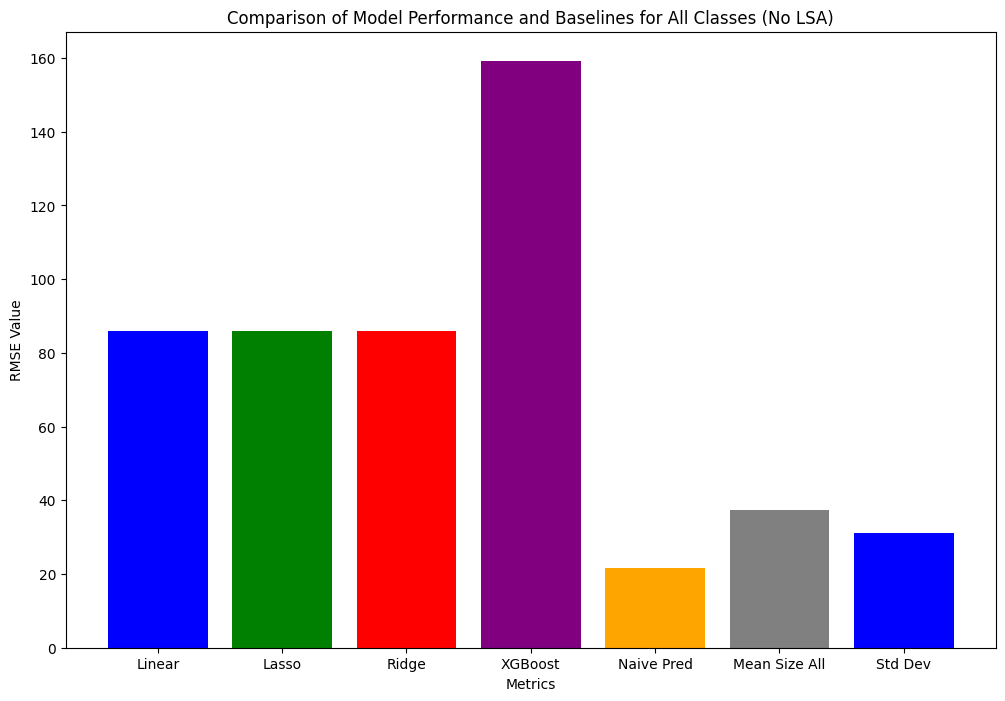

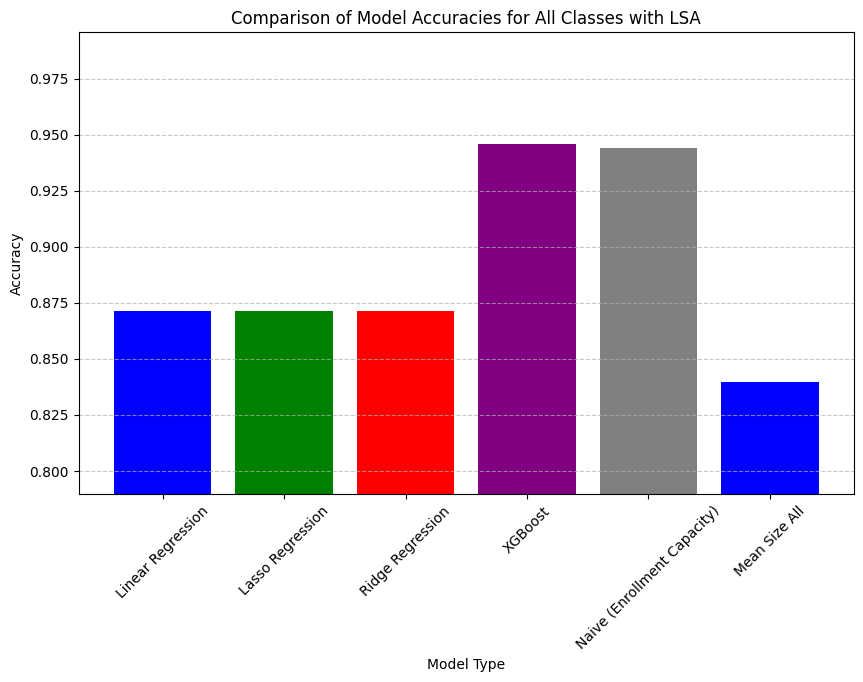

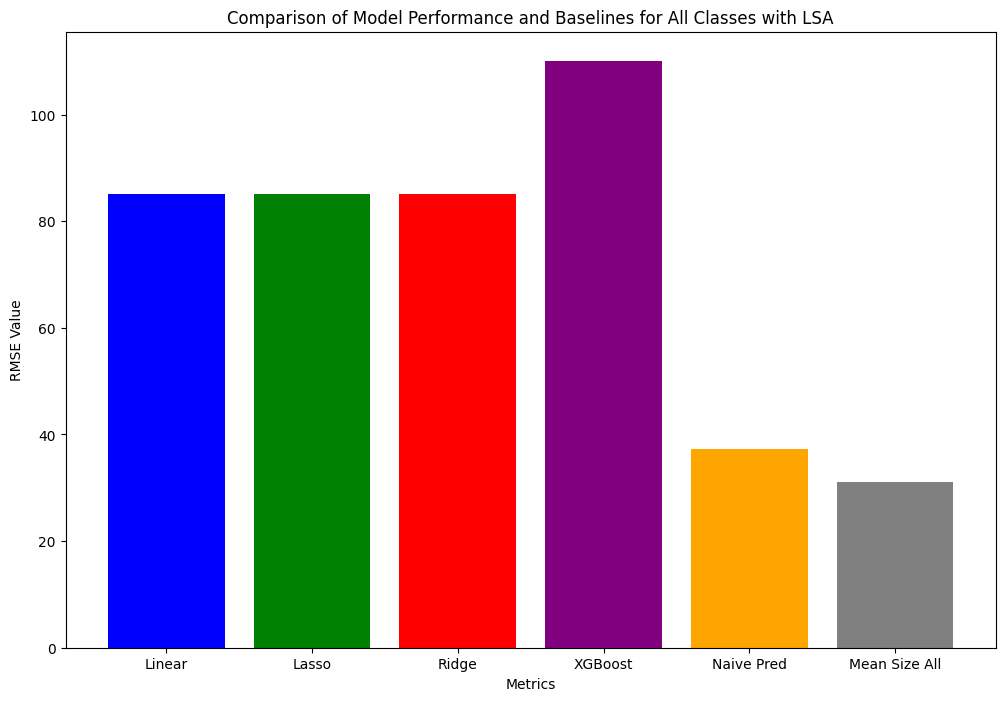

In [73]:
# Filter the dataset to only include entries for all class size
all_class_df = df_new[df_new['Class Size Category'] == 'All']

# Fetch the 'Enrollment Capacity' for the test indices to use as naive predictions
naive_predictions_enrollment_capacity_all = df_new.loc[y_all_test.index, 'Enrollment Capacity']

# Calculate RMSE for these naive predictions
naive_rmse_all = np.sqrt(mean_squared_error(y_all_test_actual, naive_predictions_enrollment_capacity_all ))
print(f"Naive RMSE when predicting 'Enrollment Capacity' for all class size as the mean: {naive_rmse_all}")

# Filter the dataset to only include entries for all class size
all_class_df = df_new[df_new['Class Size Category'] == 'Small']
mean_total_enrollment_all = all_class_df['Total Enrollment'].mean()
print(f"Mean of 'Total Enrollment' for all class size: {mean_total_enrollment_all}")

# Assume a naive prediction where every prediction equals the mean of 'Total Enrollment' for the all class size
naive_predictions_total_enrollment_all = np.full(y_all_test.shape, mean_total_enrollment_all)

# Calculate RMSE for these naive predictions
naive_rmse_total_enrollment_all = np.sqrt(mean_squared_error(y_all_test_actual, naive_predictions_total_enrollment_all))
print(f"Naive RMSE when predicting 'Total Enrollment' for all class size as the mean: {naive_rmse_total_enrollment_all}")

# Calculate the standard deviation for 'Total Enrollment' in all classes
std_deviation_all = df_new['Total Enrollment'].std()# Calculate accuracy metrics for different models
linear_accuracy_all = accuracy_metric(y_all_test_actual, linear_y_pred_all_no_lsa, std_deviation_all)
lasso_accuracy_all = accuracy_metric(y_all_test_actual, lasso_y_pred_all_no_lsa, std_deviation_all)
ridge_accuracy_all = accuracy_metric(y_all_test_actual, ridge_y_pred_all_no_lsa, std_deviation_all)
xgboost_accuracy_all = accuracy_metric(y_all_test_actual, xgboost_predictions_all_no_lsa, std_deviation_all)

# Calculate naive accuracy by guessing enrollment capacity (assuming `enrollment_capacity_test_all` is defined)
mean_size_accuracy_all = accuracy_metric(y_all_test_actual, mean_total_enrollment_all, std_deviation_all)
naive_accuracy_all = accuracy_metric(y_all_test_actual, naive_predictions_enrollment_capacity_all, std_deviation_all)

print("Linear Regression Accuracy - All Model:", linear_accuracy_all)
print("Lasso Regression Accuracy - All Model:", lasso_accuracy_all)
print("Ridge Regression Accuracy - All Model:", ridge_accuracy_all)
print("XGBoost Accuracy:", xgboost_accuracy_all)
print("Naive Accuracy (Guessing Enrollment Capacity) - All:", naive_accuracy_all)
print(f"Standard Deviation of testing set: {std_deviation_all}")

# Define the model names and their corresponding accuracies
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'XGBoost', 'Naive (Enrollment Capacity)','Mean Size All']
accuracies = [linear_accuracy_all, lasso_accuracy_all, ridge_accuracy_all, xgboost_accuracy_all, naive_accuracy_all,mean_size_accuracy_all]

# Accuracy metrics calculations using the LSA data
xgboost_accuracy_all_lsa = accuracy_metric(y_all_test_actual, xgboost_predictions_all_lsa, std_deviation_all)

linear_accuracy_all_lsa = accuracy_metric(y_all_test_actual, linear_y_pred_all_lsa, std_deviation_all)
lasso_accuracy_all_lsa = accuracy_metric(y_all_test_actual, lasso_y_pred_all_lsa, std_deviation_all)
ridge_accuracy_all_lsa = accuracy_metric(y_all_test_actual, ridge_y_pred_all_lsa, std_deviation_all)


print("Linear Regression Accuracy with LSA - All Model:", linear_accuracy_all_lsa)
print("Lasso Regression Accuracy with LSA - All Model:", lasso_accuracy_all_lsa)
print("Ridge Regression Accuracy with LSA - All Model:", ridge_accuracy_all_lsa)
print("XGBoost Accuracy with LSA - All Model:", xgboost_accuracy_all_lsa)
print("Naive Accuracy (Guessing Enrollment Capacity) with LSA - All Model:", naive_accuracy_all)

# Create a bar plot for model accuracies
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'gray'])
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies for All Classes')
plt.xticks(rotation=45)
plt.ylim([min(accuracies) - 0.05, max(accuracies) + 0.05])  # Adjusting y-limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bar plot for All Class Size
model_names_all = ['Linear', 'Lasso', 'Ridge', 'XGBoost', 'Naive Pred', 'Mean Size All','Std Dev']
test_rmses_all = [
    linear_test_rmse_all_no_lsa, lasso_test_rmse_all_no_lsa, ridge_test_rmse_all_no_lsa,
    xgboost_test_rmse_all_no_lsa, naive_rmse_all, naive_rmse_total_enrollment_all , std_deviation_all
]
colors_all = ['blue', 'green', 'red', 'purple', 'orange', 'gray']

plt.figure(figsize=(12, 8))
plt.bar(model_names_all, test_rmses_all, color=colors_all)
plt.xlabel('Metrics')
plt.ylabel('RMSE Value')
plt.title('Comparison of Model Performance and Baselines for All Classes (No LSA)')
plt.show()

# Define the model names and their corresponding accuracies using LSA data
models_lsa = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'XGBoost', 'Naive (Enrollment Capacity)','Mean Size All']
accuracies_lsa = [linear_accuracy_all_lsa, lasso_accuracy_all_lsa, ridge_accuracy_all_lsa, xgboost_accuracy_all_lsa, naive_accuracy_all,mean_size_accuracy_all]

# Create a bar plot for model accuracies with LSA data
plt.figure(figsize=(10, 6))
plt.bar(models_lsa, accuracies_lsa, color=['blue', 'green', 'red', 'purple', 'gray'])
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies for All Classes with LSA')
plt.xticks(rotation=45)
plt.ylim([min(accuracies_lsa) - 0.05, max(accuracies_lsa) + 0.05])  # Adjusting y-limits for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Bar plot for All Class Size with LSA
model_names_all_lsa = ['Linear', 'Lasso', 'Ridge', 'XGBoost', 'Naive Pred' ,'Mean Size All']
test_rmses_all_lsa = [
    linear_test_rmse_all_lsa, lasso_test_rmse_all_lsa, ridge_test_rmse_all_lsa,
    xgboost_test_rmse_all_lsa, naive_rmse_total_enrollment_all, std_deviation_all
]
colors_all_lsa = ['blue', 'green', 'red', 'purple', 'orange', 'gray']

plt.figure(figsize=(12, 8))
plt.bar(model_names_all_lsa, test_rmses_all_lsa, color=colors_all_lsa)
plt.xlabel('Metrics')
plt.ylabel('RMSE Value')
plt.title('Comparison of Model Performance and Baselines for All Classes with LSA')
plt.show()

In [74]:
 xgboost_test_rmse_all_lsa

110.0405402522438

# Results

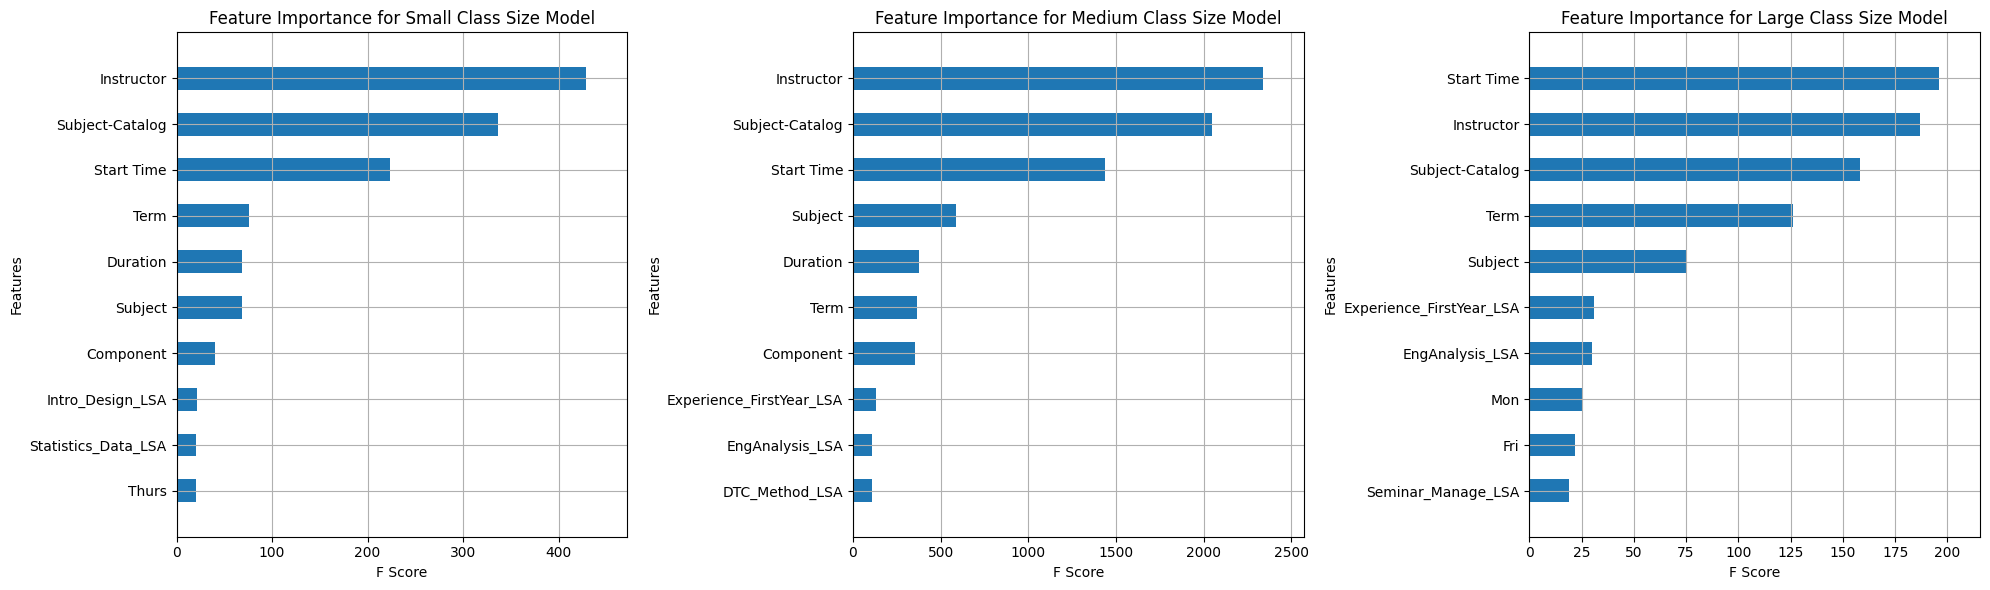

In [37]:
# Function to plot feature importance
def plot_feature_importance(model, title, subplot_index):
    ax = plt.subplot(1, 3, subplot_index)
    xgb.plot_importance(model, max_num_features=10, height=0.5, importance_type='weight', ax=ax, show_values=False)
    ax.set_title(f'Feature Importance for {title} Model')
    ax.set_xlabel('F Score')
    ax.set_ylabel('Features')

# Setup the figure size and layout
plt.figure(figsize=(20, 6))

# Plot feature importance for each model
plot_feature_importance(xgboost_model_small_lsa, 'Small Class Size', 1)
plot_feature_importance(xgboost_model_medium_lsa, 'Medium Class Size', 2)
plot_feature_importance(xgboost_model_large_lsa, 'Large Class Size', 3)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [38]:
# Data dictionary setup with specified order and variable names
data = {
    'Class Size': ['Small', 'Small', 'Small', 'Small', 'Medium', 'Medium', 'Medium', 'Medium',
                   'Large', 'Large', 'Large', 'Large', 'All', 'All', 'All', 'All'] * 2,
    'Model Type': ['Linear', 'Lasso', 'Ridge', 'XGBoost', 'Linear', 'Lasso', 'Ridge', 'XGBoost',
                   'Linear', 'Lasso', 'Ridge', 'XGBoost', 'Linear', 'Lasso', 'Ridge', 'XGBoost'] * 2,
    'LSA': ['No LSA'] * 16 + ['LSA'] * 16,
    'Mean CV RMSE': [
        # No LSA
        linear_mean_cv_rmse_small_no_lsa, lasso_cv_rmse_small_no_lsa, ridge_cv_rmse_small_no_lsa, xgboost_train_rmse_small_no_lsa,
        linear_mean_cv_rmse_medium_no_lsa, lasso_cv_rmse_medium_no_lsa, ridge_cv_rmse_medium_no_lsa, xgboost_train_rmse_medium_no_lsa,
        linear_mean_cv_rmse_large_no_lsa, lasso_cv_rmse_large_no_lsa, ridge_cv_rmse_large_no_lsa, xgboost_train_rmse_large_no_lsa,
        linear_mean_cv_rmse_all_no_lsa, lasso_cv_rmse_all_no_lsa, ridge_cv_rmse_all_no_lsa, xgboost_train_rmse_all_no_lsa,
        # LSA
        linear_mean_cv_rmse_small_lsa, lasso_cv_rmse_small_lsa, ridge_cv_rmse_small_lsa, xgboost_train_rmse_small_lsa,
        linear_mean_cv_rmse_medium_lsa, lasso_cv_rmse_medium_lsa, ridge_cv_rmse_medium_lsa, xgboost_train_rmse_medium_lsa,
        linear_mean_cv_rmse_large_lsa, lasso_cv_rmse_large_lsa, ridge_cv_rmse_large_lsa, xgboost_train_rmse_large_lsa,
        linear_mean_cv_rmse_all_lsa, lasso_cv_rmse_all_lsa, ridge_cv_rmse_all_lsa, xgboost_train_rmse_all_lsa,
    ],
    'Test RMSE': [
        # No LSA
        linear_test_rmse_small_no_lsa, lasso_test_rmse_small_no_lsa, ridge_test_rmse_small_no_lsa, xgboost_test_rmse_small_no_lsa,
        linear_test_rmse_medium_no_lsa, lasso_test_rmse_medium_no_lsa, ridge_test_rmse_medium_no_lsa, xgboost_test_rmse_medium_no_lsa,
        linear_test_rmse_large_no_lsa, lasso_test_rmse_large_no_lsa, ridge_test_rmse_large_no_lsa, xgboost_test_rmse_large_no_lsa,
        linear_test_rmse_all_no_lsa, lasso_test_rmse_all_no_lsa, ridge_test_rmse_all_no_lsa, xgboost_test_rmse_all_no_lsa,
        # LSA
        linear_test_rmse_small_lsa, lasso_test_rmse_small_lsa, ridge_test_rmse_small_lsa, xgboost_test_rmse_small_lsa,
        linear_test_rmse_medium_lsa, lasso_test_rmse_medium_lsa, ridge_test_rmse_medium_lsa, xgboost_test_rmse_medium_lsa,
        linear_test_rmse_large_lsa, lasso_test_rmse_large_lsa, ridge_test_rmse_large_lsa, xgboost_test_rmse_large_lsa,
        linear_test_rmse_all_lsa, lasso_test_rmse_all_lsa, ridge_test_rmse_all_lsa, xgboost_test_rmse_all_lsa
        ],
    'Accuracy': [
        # Assuming you have accuracy metrics calculated similarly to RMSE
        # No LSA
        linear_accuracy_small_no_lsa, lasso_accuracy_small_no_lsa, ridge_accuracy_small_no_lsa, xgboost_accuracy_small_no_lsa,
        linear_accuracy_medium_no_lsa, lasso_accuracy_medium_no_lsa, ridge_accuracy_medium_no_lsa, xgboost_accuracy_medium_no_lsa,
        linear_accuracy_large_no_lsa, lasso_accuracy_large_no_lsa, ridge_accuracy_large_no_lsa, xgboost_accuracy_large_no_lsa,
        linear_accuracy_all_no_lsa, lasso_accuracy_all_no_lsa, ridge_accuracy_all_no_lsa, xgboost_accuracy_all_no_lsa,
        # LSA
        linear_accuracy_small_lsa, lasso_accuracy_small_lsa, ridge_accuracy_small_lsa, xgboost_accuracy_small_lsa,
        linear_accuracy_medium_lsa, lasso_accuracy_medium_lsa, ridge_accuracy_medium_lsa, xgboost_accuracy_medium_lsa,
        linear_accuracy_large_lsa, lasso_accuracy_large_lsa, ridge_accuracy_large_lsa, xgboost_accuracy_large_lsa,
        linear_accuracy_all_lsa, lasso_accuracy_all_lsa, ridge_accuracy_all_lsa, xgboost_accuracy_all_lsa
    ]
}

# Create DataFrame
results_df = pd.DataFrame(data)

# Sort the DataFrame by 'Class Size', 'Model Type', and 'LSA'
results_df = results_df.sort_values(by=['Class Size', 'Model Type', 'LSA'])
results_df.reset_index(drop=True, inplace=True)

# Display the DataFrame for checking
print(results_df)

   Class Size Model Type     LSA  Mean CV RMSE   Test RMSE  Accuracy
0         All      Lasso     LSA     26.511167   85.122201  0.871345
1         All      Lasso  No LSA     29.795517   85.963129  0.556291
2         All     Linear     LSA     26.451197   85.123443  0.871345
3         All     Linear  No LSA     29.746752   86.015373  0.549669
4         All      Ridge     LSA     26.509658   85.123443  0.871345
5         All      Ridge  No LSA     29.792057   85.827564  0.529801
6         All    XGBoost     LSA    102.010449  110.040540  0.945698
7         All    XGBoost  No LSA    154.720418  159.160300  0.304636
8       Large      Lasso     LSA     43.906925   59.678497  0.688742
9       Large      Lasso  No LSA     52.960308   59.185507  0.748344
10      Large     Linear     LSA     83.356497   74.001006  0.662252
11      Large     Linear  No LSA     52.899476   60.556551  0.708609
12      Large      Ridge     LSA     43.549478   58.324604  0.682119
13      Large      Ridge  No LSA  

### Residual plots

In [39]:
# Small Class Size Residuals
residuals_linear_small = y_small_test_actual - linear_y_pred_small_no_lsa
residuals_lasso_small = y_small_test_actual - lasso_y_pred_small_no_lsa
residuals_ridge_small = y_small_test_actual - ridge_y_pred_small_no_lsa
residuals_xgboost_small = y_small_test_actual - xgboost_predictions_small_no_lsa

# Medium Class Size Residuals
residuals_linear_medium = y_medium_test_actual - linear_y_pred_medium_no_lsa
residuals_lasso_medium = y_medium_test_actual - lasso_y_pred_medium_no_lsa
residuals_ridge_medium = y_medium_test_actual - ridge_y_pred_medium_no_lsa
residuals_xgboost_medium = y_medium_test_actual - xgboost_predictions_medium_no_lsa

# Large Class Size Residuals
residuals_linear_large = y_large_test_actual - linear_y_pred_large_no_lsa
residuals_lasso_large = y_large_test_actual - lasso_y_pred_large_no_lsa
residuals_ridge_large = y_large_test_actual - ridge_y_pred_large_no_lsa
residuals_xgboost_large = y_large_test_actual - xgboost_predictions_large_no_lsa

# Small Class Size Residuals with LSA
residuals_linear_small_lsa = y_small_test_actual - linear_y_pred_small_lsa
residuals_lasso_small_lsa = y_small_test_actual - lasso_y_pred_small_lsa
residuals_ridge_small_lsa = y_small_test_actual - ridge_y_pred_small_lsa
residuals_xgboost_small_lsa = y_small_test_actual - xgboost_predictions_small_lsa

# Medium Class Size Residuals with LSA
residuals_linear_medium_lsa = y_medium_test_actual - linear_y_pred_medium_lsa
residuals_lasso_medium_lsa = y_medium_test_actual - lasso_y_pred_medium_lsa
residuals_ridge_medium_lsa = y_medium_test_actual - ridge_y_pred_medium_lsa
residuals_xgboost_medium_lsa = y_medium_test_actual - xgboost_predictions_medium_lsa

# Large Class Size Residuals with LSA
residuals_linear_large_lsa = y_large_test_actual - linear_y_pred_large_lsa
residuals_lasso_large_lsa = y_large_test_actual - lasso_y_pred_large_lsa
residuals_ridge_large_lsa = y_large_test_actual - ridge_y_pred_large_lsa
residuals_xgboost_large_lsa = y_large_test_actual - xgboost_predictions_large_lsa

# All Class Size Residuals
residuals_linear_all = y_all_test_actual - linear_y_pred_all_no_lsa
residuals_lasso_all = y_all_test_actual - lasso_y_pred_all_no_lsa
residuals_ridge_all = y_all_test_actual - ridge_y_pred_all_no_lsa
residuals_xgboost_all = y_all_test_actual - xgboost_predictions_all_no_lsa

# All Class Size Residuals with LSA
residuals_linear_all_lsa = y_all_test_actual - linear_y_pred_all_lsa
residuals_lasso_all_lsa = y_all_test_actual - lasso_y_pred_all_lsa
residuals_ridge_all_lsa = y_all_test_actual - ridge_y_pred_all_lsa
residuals_xgboost_all_lsa = y_all_test_actual - xgboost_predictions_all_lsa

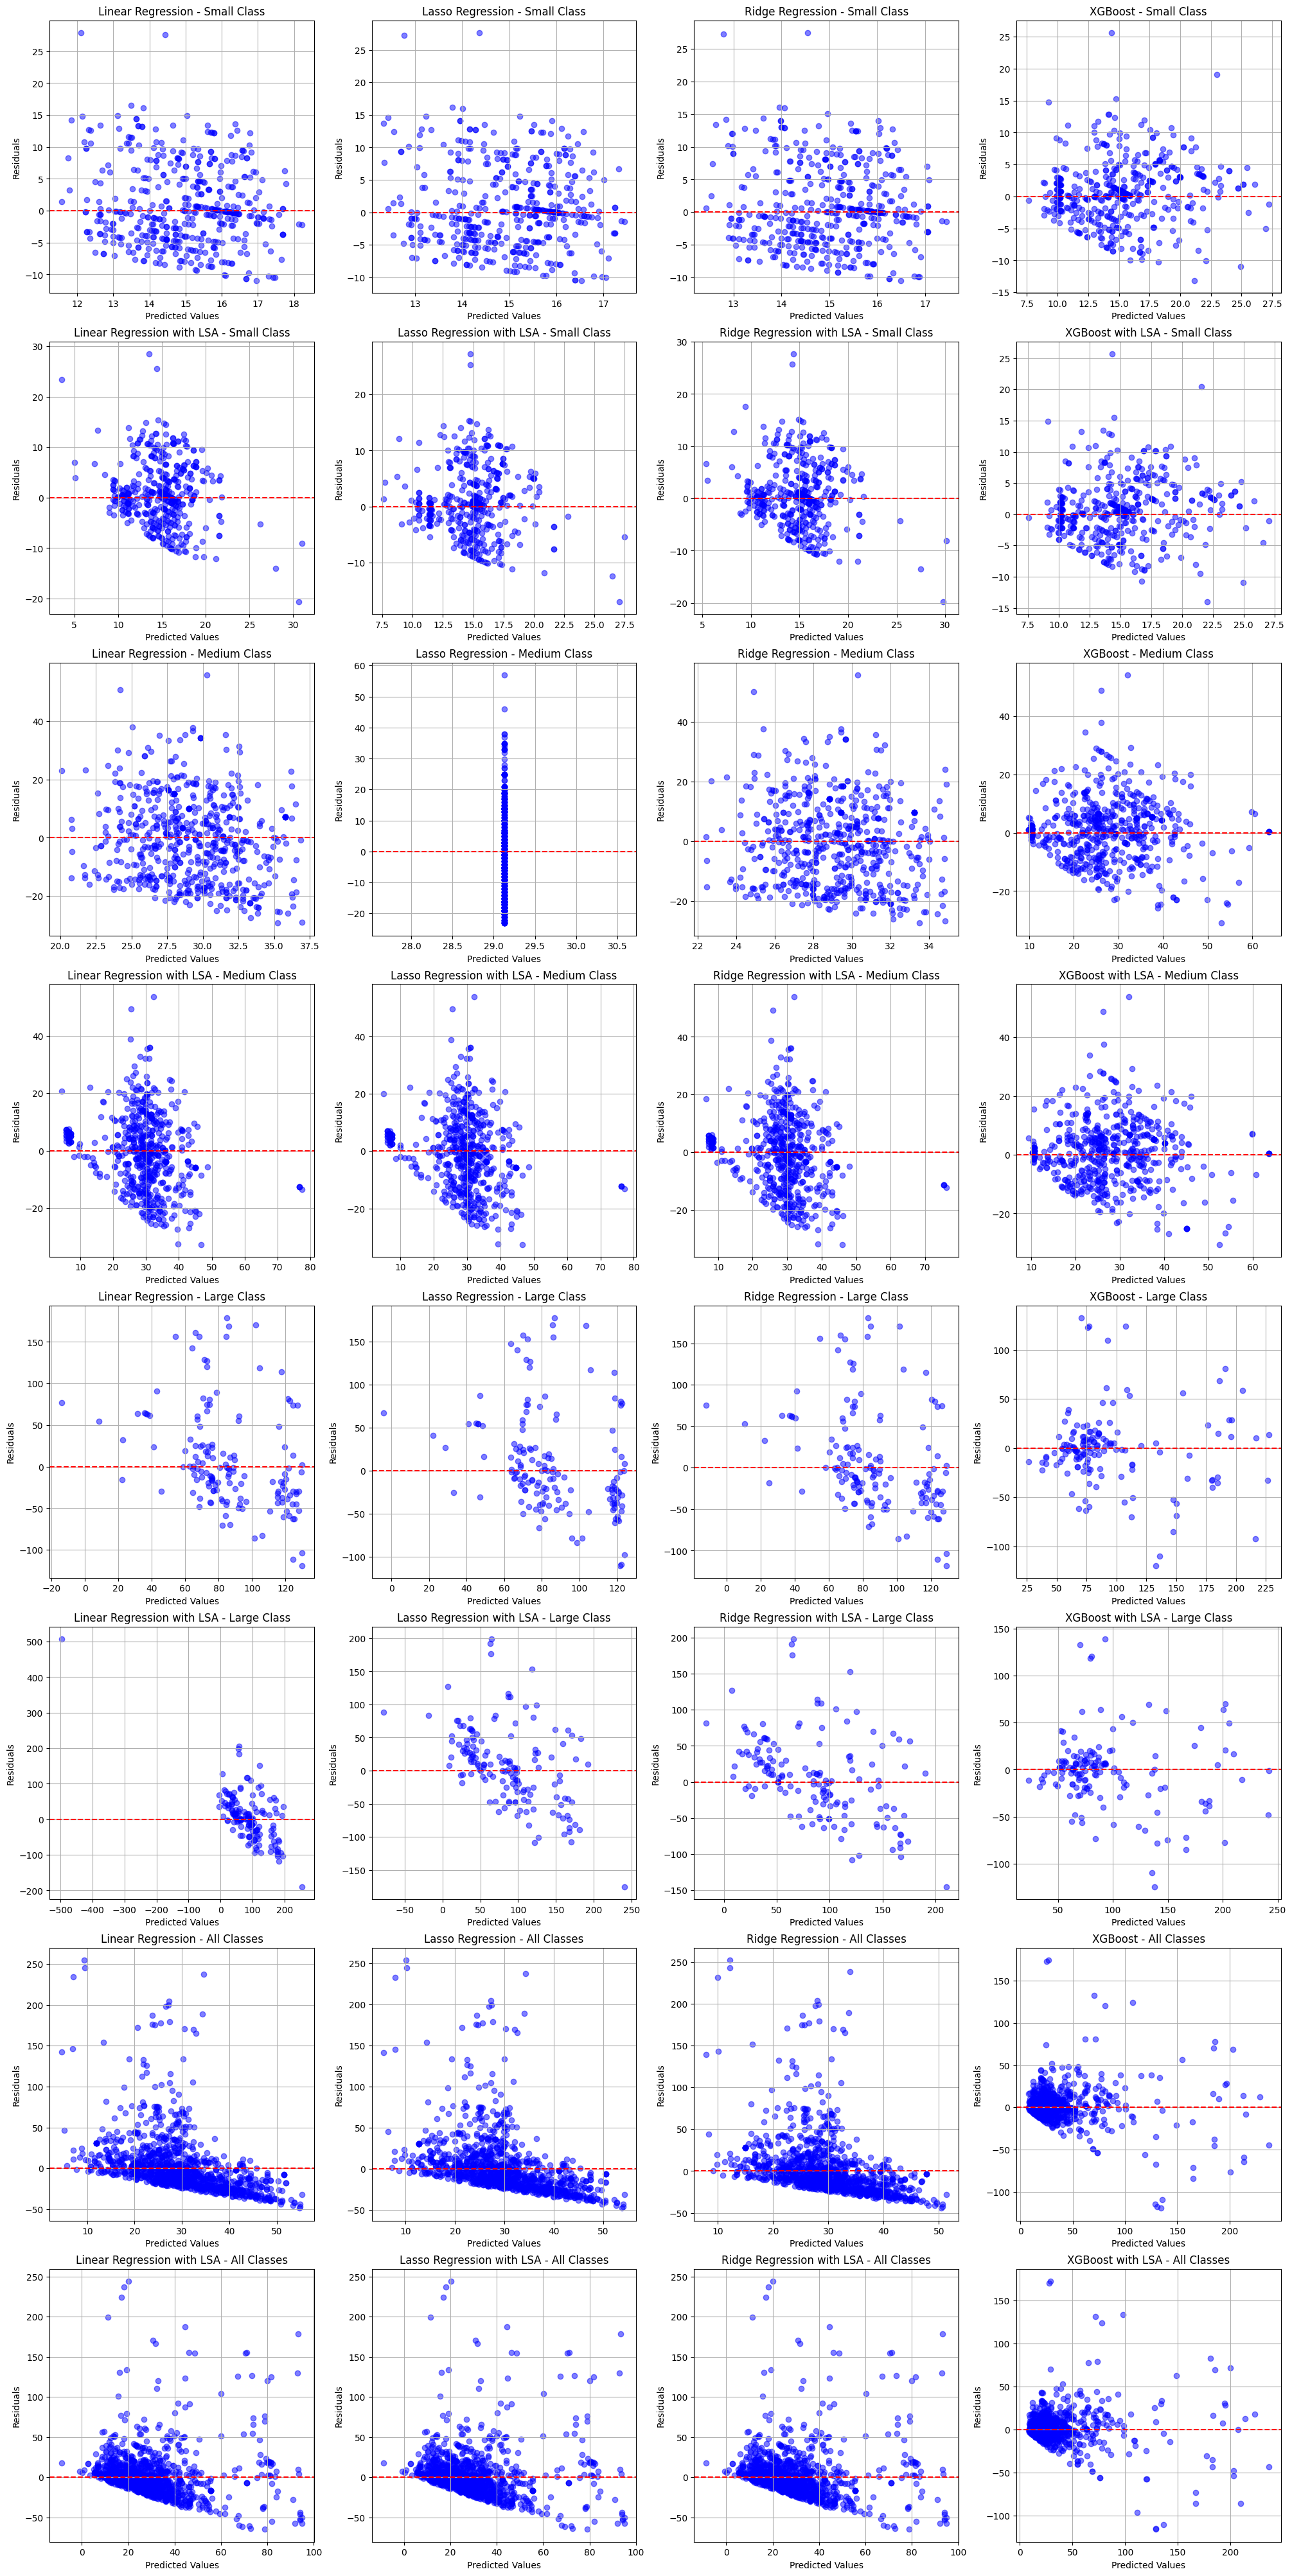

In [40]:
def plot_residuals_scatter(ax, predicted, residuals, title):
    ax.scatter(predicted, residuals, color='blue', alpha=0.5)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(title)
    ax.grid(True)

fig, axes = plt.subplots(8, 4, figsize=(20, 40), constrained_layout=True)

# Plotting for Small Class Size without LSA
plot_residuals_scatter(axes[0, 0], linear_y_pred_small_no_lsa, residuals_linear_small, 'Linear Regression - Small Class')
plot_residuals_scatter(axes[0, 1], lasso_y_pred_small_no_lsa, residuals_lasso_small, 'Lasso Regression - Small Class')
plot_residuals_scatter(axes[0, 2], ridge_y_pred_small_no_lsa, residuals_ridge_small, 'Ridge Regression - Small Class')
plot_residuals_scatter(axes[0, 3], xgboost_predictions_small_no_lsa, residuals_xgboost_small, 'XGBoost - Small Class')

# Plotting for Small Class Size with LSA
plot_residuals_scatter(axes[1, 0], linear_y_pred_small_lsa, residuals_linear_small_lsa, 'Linear Regression with LSA - Small Class')
plot_residuals_scatter(axes[1, 1], lasso_y_pred_small_lsa, residuals_lasso_small_lsa, 'Lasso Regression with LSA - Small Class')
plot_residuals_scatter(axes[1, 2], ridge_y_pred_small_lsa, residuals_ridge_small_lsa, 'Ridge Regression with LSA - Small Class')
plot_residuals_scatter(axes[1, 3], xgboost_predictions_small_lsa, residuals_xgboost_small_lsa, 'XGBoost with LSA - Small Class')

# Plotting for Medium Class Size without LSA
plot_residuals_scatter(axes[2, 0], linear_y_pred_medium_no_lsa, residuals_linear_medium, 'Linear Regression - Medium Class')
plot_residuals_scatter(axes[2, 1], lasso_y_pred_medium_no_lsa, residuals_lasso_medium, 'Lasso Regression - Medium Class')
plot_residuals_scatter(axes[2, 2], ridge_y_pred_medium_no_lsa, residuals_ridge_medium, 'Ridge Regression - Medium Class')
plot_residuals_scatter(axes[2, 3], xgboost_predictions_medium_no_lsa, residuals_xgboost_medium, 'XGBoost - Medium Class')

# Plotting for Medium Class Size with LSA
plot_residuals_scatter(axes[3, 0], linear_y_pred_medium_lsa, residuals_linear_medium_lsa, 'Linear Regression with LSA - Medium Class')
plot_residuals_scatter(axes[3, 1], lasso_y_pred_medium_lsa, residuals_lasso_medium_lsa, 'Lasso Regression with LSA - Medium Class')
plot_residuals_scatter(axes[3, 2], ridge_y_pred_medium_lsa, residuals_ridge_medium_lsa, 'Ridge Regression with LSA - Medium Class')
plot_residuals_scatter(axes[3, 3], xgboost_predictions_medium_lsa, residuals_xgboost_medium_lsa, 'XGBoost with LSA - Medium Class')

# Plotting for Large Class Size without LSA
plot_residuals_scatter(axes[4, 0], linear_y_pred_large_no_lsa, residuals_linear_large, 'Linear Regression - Large Class')
plot_residuals_scatter(axes[4, 1], lasso_y_pred_large_no_lsa, residuals_lasso_large, 'Lasso Regression - Large Class')
plot_residuals_scatter(axes[4, 2], ridge_y_pred_large_no_lsa, residuals_ridge_large, 'Ridge Regression - Large Class')
plot_residuals_scatter(axes[4, 3], xgboost_predictions_large_no_lsa, residuals_xgboost_large, 'XGBoost - Large Class')

# Plotting for Large Class Size with LSA
plot_residuals_scatter(axes[5, 0], linear_y_pred_large_lsa, residuals_linear_large_lsa, 'Linear Regression with LSA - Large Class')
plot_residuals_scatter(axes[5, 1], lasso_y_pred_large_lsa, residuals_lasso_large_lsa, 'Lasso Regression with LSA - Large Class')
plot_residuals_scatter(axes[5, 2], ridge_y_pred_large_lsa, residuals_ridge_large_lsa, 'Ridge Regression with LSA - Large Class')
plot_residuals_scatter(axes[5, 3], xgboost_predictions_large_lsa, residuals_xgboost_large_lsa, 'XGBoost with LSA - Large Class')

# Plotting for All Class Size without LSA
plot_residuals_scatter(axes[6, 0], linear_y_pred_all_no_lsa, residuals_linear_all, 'Linear Regression - All Classes')
plot_residuals_scatter(axes[6, 1], lasso_y_pred_all_no_lsa, residuals_lasso_all, 'Lasso Regression - All Classes')
plot_residuals_scatter(axes[6, 2], ridge_y_pred_all_no_lsa, residuals_ridge_all, 'Ridge Regression - All Classes')
plot_residuals_scatter(axes[6, 3], xgboost_predictions_all_no_lsa, residuals_xgboost_all, 'XGBoost - All Classes')

# Plotting for All Class Size with LSA
plot_residuals_scatter(axes[7, 0], linear_y_pred_all_lsa, residuals_linear_all_lsa, 'Linear Regression with LSA - All Classes')
plot_residuals_scatter(axes[7, 1], lasso_y_pred_all_lsa, residuals_lasso_all_lsa, 'Lasso Regression with LSA - All Classes')
plot_residuals_scatter(axes[7, 2], ridge_y_pred_all_lsa, residuals_ridge_all_lsa, 'Ridge Regression with LSA - All Classes')
plot_residuals_scatter(axes[7, 3], xgboost_predictions_all_lsa, residuals_xgboost_all_lsa, 'XGBoost with LSA - All Classes')

plt.show()

In [41]:
# Data dictionary setup with specified order and variable names
data = {
    'Class Size': ['Small', 'Small', 'Small', 'Small', 'Medium', 'Medium', 'Medium', 'Medium',
                   'Large', 'Large', 'Large', 'Large', 'All', 'All', 'All', 'All'] * 2,
    'Model Type': ['Linear', 'Lasso', 'Ridge', 'XGBoost'] * 4 * 2,
    'LSA': ['No LSA']*16 + ['LSA']*16,
    'Mean CV RMSE': [
        # No LSA
        linear_mean_cv_rmse_small_no_lsa, lasso_cv_rmse_small_no_lsa, ridge_cv_rmse_small_no_lsa, xgboost_train_rmse_small_no_lsa,
        linear_mean_cv_rmse_medium_no_lsa, lasso_cv_rmse_medium_no_lsa, ridge_cv_rmse_medium_no_lsa, xgboost_train_rmse_medium_no_lsa,
        linear_mean_cv_rmse_large_no_lsa, lasso_cv_rmse_large_no_lsa, ridge_cv_rmse_large_no_lsa, xgboost_train_rmse_large_no_lsa,
        linear_mean_cv_rmse_all_no_lsa, lasso_cv_rmse_all_no_lsa, ridge_cv_rmse_all_no_lsa, xgboost_train_rmse_all_no_lsa,
        # LSA
        linear_mean_cv_rmse_small_lsa, lasso_cv_rmse_small_lsa, ridge_cv_rmse_small_lsa, xgboost_train_rmse_small_lsa,
        linear_mean_cv_rmse_medium_lsa, lasso_cv_rmse_medium_lsa, ridge_cv_rmse_medium_lsa, xgboost_train_rmse_medium_lsa,
        linear_mean_cv_rmse_large_lsa, lasso_cv_rmse_large_lsa, ridge_cv_rmse_large_lsa, xgboost_train_rmse_large_lsa,
        linear_mean_cv_rmse_all_lsa, lasso_cv_rmse_all_lsa, ridge_cv_rmse_all_lsa, xgboost_train_rmse_all_lsa
    ],
    'Test RMSE': [
        # No LSA
        linear_test_rmse_small_no_lsa, lasso_test_rmse_small_no_lsa, ridge_test_rmse_small_no_lsa, xgboost_test_rmse_small_no_lsa,
        linear_test_rmse_medium_no_lsa, lasso_test_rmse_medium_no_lsa, ridge_test_rmse_medium_no_lsa, xgboost_test_rmse_medium_no_lsa,
        linear_test_rmse_large_no_lsa, lasso_test_rmse_large_no_lsa, ridge_test_rmse_large_no_lsa, xgboost_test_rmse_large_no_lsa,
        linear_test_rmse_all_no_lsa, lasso_test_rmse_all_no_lsa, ridge_test_rmse_all_no_lsa, xgboost_test_rmse_all_no_lsa,
        # LSA
        linear_test_rmse_small_lsa, lasso_test_rmse_small_lsa, ridge_test_rmse_small_lsa, xgboost_test_rmse_small_lsa,
        linear_test_rmse_medium_lsa, lasso_test_rmse_medium_lsa, ridge_test_rmse_medium_lsa, xgboost_test_rmse_medium_lsa,
        linear_test_rmse_large_lsa, lasso_test_rmse_large_lsa, ridge_test_rmse_large_lsa, xgboost_test_rmse_large_lsa,
        linear_test_rmse_all_lsa, lasso_test_rmse_all_lsa, ridge_test_rmse_all_lsa, xgboost_test_rmse_all_lsa
        ],
    'Accuracy': [
        # No LSA
        linear_accuracy_small_no_lsa, lasso_accuracy_small_no_lsa, ridge_accuracy_small_no_lsa, xgboost_accuracy_small_no_lsa,
        linear_accuracy_medium_no_lsa, lasso_accuracy_medium_no_lsa, ridge_accuracy_medium_no_lsa, xgboost_accuracy_medium_no_lsa,
        linear_accuracy_large_no_lsa, lasso_accuracy_large_no_lsa, ridge_accuracy_large_no_lsa, xgboost_accuracy_large_no_lsa,
        linear_accuracy_all_no_lsa, lasso_accuracy_all_no_lsa, ridge_accuracy_all_no_lsa, xgboost_accuracy_all_no_lsa,
        # LSA
        linear_accuracy_small_lsa, lasso_accuracy_small_lsa, ridge_accuracy_small_lsa, xgboost_accuracy_small_lsa,
        linear_accuracy_medium_lsa, lasso_accuracy_medium_lsa, ridge_accuracy_medium_lsa, xgboost_accuracy_medium_lsa,
        linear_accuracy_large_lsa, lasso_accuracy_large_lsa, ridge_accuracy_large_lsa, xgboost_accuracy_large_lsa,
        linear_accuracy_all_lsa, lasso_accuracy_all_lsa, ridge_accuracy_all_lsa, xgboost_accuracy_all_lsa
    ]
}

# Create DataFrame
results_df = pd.DataFrame(data)

# Function to calculate scaled RMSE based on the standard deviation of each class size
def calculate_scaled_rmse(row, std_devs):
    class_size = row['Class Size']
    return row['Test RMSE'] / std_devs[class_size]

# Standard deviation values for each class size
std_devs = {
    'Small': std_deviation_small,
    'Medium': std_deviation_medium,
    'Large': std_deviation_large,
    'All': std_deviation_all
}

# Apply the function to calculate Scaled Test RMSE
results_df['Scaled Test RMSE'] = results_df.apply(calculate_scaled_rmse, axis=1, args=(std_devs,))

# Sort the DataFrame by 'Class Size', 'Model Type', and 'LSA'
results_df = results_df.sort_values(by=['Class Size', 'Model Type', 'LSA'])

# Optionally, reset the index for better readability
results_df.reset_index(drop=True, inplace=True)

# Display the DataFrame for checking
print(results_df)

   Class Size Model Type     LSA  Mean CV RMSE   Test RMSE  Accuracy  \
0         All      Lasso     LSA     26.511167   85.122201  0.871345   
1         All      Lasso  No LSA     29.795517   85.963129  0.556291   
2         All     Linear     LSA     26.451197   85.123443  0.871345   
3         All     Linear  No LSA     29.746752   86.015373  0.549669   
4         All      Ridge     LSA     26.509658   85.123443  0.871345   
5         All      Ridge  No LSA     29.792057   85.827564  0.529801   
6         All    XGBoost     LSA    102.010449  110.040540  0.945698   
7         All    XGBoost  No LSA    154.720418  159.160300  0.304636   
8       Large      Lasso     LSA     43.906925   59.678497  0.688742   
9       Large      Lasso  No LSA     52.960308   59.185507  0.748344   
10      Large     Linear     LSA     83.356497   74.001006  0.662252   
11      Large     Linear  No LSA     52.899476   60.556551  0.708609   
12      Large      Ridge     LSA     43.549478   58.324604  0.68

#### Optimal Model Choices

In [42]:
# Group by 'Class Size', 'Model Type', and 'LSA', find the minimum 'Test RMSE' for each group
best_rmse = results_df.groupby(['Class Size', 'Model Type', 'LSA'])['Test RMSE'].min().reset_index()

# Sort the results by 'Class Size' and 'Test RMSE'
best_rmse_sorted = best_rmse.sort_values(by=['Class Size', 'Test RMSE'])

# Use groupby on 'Class Size' and use head(2) to get the top 2 entries for each class size
top_models = best_rmse_sorted.groupby('Class Size').head(2)

# Create a DataFrame for naive RMSEs
naive_data = {
    'Class Size': ['Small', 'Medium', 'Large'],
    'Model Type': ['Naive', 'Naive', 'Naive'],
    'LSA': ['No LSA', 'No LSA', 'No LSA'],
    'Test RMSE': [naive_rmse_small, naive_rmse_medium, naive_rmse_large]
}

naive_df = pd.DataFrame(naive_data)

# Append the naive RMSEs to the top models DataFrame
top_models = pd.concat([top_models, naive_df], ignore_index=True)

# Standard deviation values for each class size
std_devs = {
    'Small': std_deviation_small,
    'Medium': std_deviation_medium,
    'Large': std_deviation_large,
    'All': std_deviation_all
}

# Function to calculate scaled RMSE based on the standard deviation of each class size
def calculate_scaled_rmse(row, std_devs):
    class_size = row['Class Size']
    return row['Test RMSE'] / std_devs[class_size]

# Apply the function to calculate Scaled Test RMSE
top_models['Scaled Test RMSE'] = top_models.apply(calculate_scaled_rmse, axis=1, args=(std_devs,))

# Display the DataFrame
print(top_models)

   Class Size Model Type     LSA  Test RMSE  Scaled Test RMSE
0         All      Lasso     LSA  85.122201          2.733992
1         All      Ridge     LSA  85.123443          2.734032
2       Large    XGBoost  No LSA  38.301052          0.674154
3       Large    XGBoost     LSA  38.726858          0.681648
4      Medium    XGBoost     LSA  10.636367          0.688876
5      Medium    XGBoost  No LSA  10.640047          0.689114
6       Small    XGBoost  No LSA   4.840693          0.742637
7       Small    XGBoost     LSA   4.872787          0.747561
8       Small      Naive  No LSA   7.144659          1.096102
9      Medium      Naive  No LSA  14.845111          0.961460
10      Large      Naive  No LSA  51.841646          0.912487


Lets observe the optimal hyperparameter selection for reference

In [43]:
print(xgboost_model_small_lsa.get_params)
print(xgboost_model_medium_no_lsa.get_params)
print(xgboost_model_large_no_lsa.get_params)

<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=10,
             enable_categorical=True, eval_metric='rmse', feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)>
<bound method XGBModel.get_params of XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_round

Lets also observe the order in which the model takes in input data in order to guide or front-end implementation

In [44]:
# Assuming your models are already loaded and named accordingly
print("Number of predictors for xgboost_model_small_lsa:",(xgboost_model_small_lsa.get_booster().feature_names))

Number of predictors for xgboost_model_small_lsa: ['Term', 'Subject', 'Component', 'Instructor', 'Start Time', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 'Subject-Catalog', 'Duration', 'Experience_FirstYear_LSA', 'Communication_Design_LSA', 'Topics_PersonalDev_LSA', 'Intro_Design_LSA', 'Design_Project_LSA', 'EngAnalysis_LSA', 'DTC_Method_LSA', 'Computing_Program_LSA', 'Seminar_Manage_LSA', 'Statistics_Data_LSA', 'Material_Process_LSA', 'Systems_Physics_LSA', 'Mechanics_Fluids_LSA', 'Project_Management_LSA', 'Selection_MechEng_LSA', 'Selection_Optimization_LSA', 'Optimization_Modeling_LSA', 'Analysis_Program_LSA', 'Probabilities_Program_LSA', 'Analysis_Human_LSA', 'Data_Structure_LSA', 'Mechanical_Manufacturing_LSA', 'Thermodynamic_Env_LSA', 'Environmental_Modeling_LSA', 'Principles_Entrepreneurial_LSA', 'Discourse_Statistics_LSA', 'Machine_Learning_LSA', 'Modeling_Stochastic_LSA', 'Fundamentals_Transport_LSA', 'Construction_Manage_LSA', 'Develop_Career_LSA', 'Advance_Communica

In [45]:
# Group by 'Class Size', 'Model Type', and 'LSA', find the maximum 'Accuracy' for each group
best_accuracy = results_df.groupby(['Class Size', 'Model Type', 'LSA'])['Accuracy'].max().reset_index()

# Sort the results by 'Class Size' and 'Accuracy' in descending order (since we want the highest accuracies)
best_accuracy_sorted = best_accuracy.sort_values(by=['Class Size', 'Accuracy'], ascending=[True, False])

# Use groupby on 'Class Size' and use head(2) to get the top 2 entries for each class size
top_accuracy_models = best_accuracy_sorted.groupby('Class Size').head(2)

# Adding naive accuracy values as new rows to top_accuracy_models
new_rows = pd.DataFrame({
    'Class Size': ['Small', 'Medium', 'Large'],
    'Model Type': ['Enrollment Capacity', 'Enrollment Capacity', 'Enrollment Capacity'],
    'LSA': ['N/A', 'N/A', 'N/A'],
    'Accuracy': [naive_accuracy_small_no_lsa, naive_accuracy_medium_no_lsa, naive_accuracy_large_no_lsa]
})

top_accuracy_models = pd.concat([top_accuracy_models, new_rows], ignore_index=True)

# Display the updated DataFrame
print(top_accuracy_models)

   Class Size           Model Type     LSA  Accuracy
0         All              XGBoost     LSA  0.945698
1         All                Lasso     LSA  0.871345
2       Large              XGBoost  No LSA  0.874172
3       Large              XGBoost     LSA  0.860927
4      Medium              XGBoost     LSA  0.873096
5      Medium              XGBoost  No LSA  0.871404
6       Small              XGBoost  No LSA  0.830769
7       Small              XGBoost     LSA  0.824176
8       Small  Enrollment Capacity     N/A  0.707692
9      Medium  Enrollment Capacity     N/A  0.673435
10      Large  Enrollment Capacity     N/A  0.761589


Finally, lets observe the MAE so we can easily intrepret the results of our models

In [48]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for small class
mae_small = mean_absolute_error(y_small_test_actual, xgboost_predictions_small_lsa)

# Calculate MAE for medium class
mae_medium = mean_absolute_error(y_medium_test_actual, xgboost_predictions_medium_lsa)

# Calculate MAE for large class
mae_large = mean_absolute_error(y_large_test_actual, xgboost_predictions_large_lsa)

print("MAE Small:", mae_small)
print("MAE Medium:", mae_medium)
print("MAE Large:", mae_large)

MAE Small: 3.5746367601247933
MAE Medium: 7.991447387411308
MAE Large: 25.670011937223524


Save optimal models to pickle files

In [47]:
import joblib

joblib.dump(xgboost_model_small_lsa, 'small_model.pkl')
joblib.dump(xgboost_model_medium_lsa, 'medium_model.pkl')
joblib.dump(xgboost_model_large_lsa, 'large_model.pkl')

['large_model.pkl']